This code creates and stores a single model ensemble created from a selection of models. We used a customized CNN, and pretrained models including VGG19, InceptionResnetV2 and SqueezeNet, with their ImageNet weights initialized and fine-tuned end-to-end. The optimal model ensemble is chosen and saved to make further predictions. Five fold cross validation is performed on a patient-specific case.

In [96]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow import keras
import tensorflow.keras.backend as K

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [131]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras_squeezenet_tf2 import SqueezeNet
from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [98]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [99]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 1 #60
batch_size = 64 #16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")


In [100]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [101]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1.]


In [102]:
#%% define custom model and instantiate it

def custom_cnn(model_input):
    x = BatchNormalization()(model_input)
    x = Conv2D(64, (5, 5), padding='same', activation='relu', name = 'custom_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = 'maxpool1')(x)
    x = Dropout(0.25, name = 'conv_dropout1')(x)
    x = BatchNormalization(name = 'custom_batchnorm1')(x)
    x = Conv2D(128, (5, 5), padding='same', activation='relu', name = 'custom_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool2')(x)
    x = Dropout(0.25, name = 'conv_dropout2')(x)
    x = BatchNormalization(name = 'custom_batchnorm2')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name = 'custom_conv3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool3')(x)
    x = Dropout(0.25, name = 'conv_dropout3')(x)
    x = GlobalAveragePooling2D(name = 'custom_GAP')(x)
    x = Dense(256, activation='relu', name = 'custom_dense1')(x)
    x = Dropout(0.5, name = 'dense_dropout1')(x)
    x = Dense(num_classes, activation='softmax', name = 'custom_dense2')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
#plot_model(custom_model, to_file='custom_model.png',show_shapes=True, show_layer_names=False)


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
batch_normalization_1022 (Ba (None, 100, 100, 3)       12        
_________________________________________________________________
custom_conv1 (Conv2D)        (None, 100, 100, 64)      4864      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 50, 50, 64)        0         
_________________________________________________________________
custom_batchnorm1 (BatchNorm (None, 50, 50, 64)        256       
_________________________________________________________________
custom_conv2 (Conv2D)        (None, 50, 50, 128)       2

In [103]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
#plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [104]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
#plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_9[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [105]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
#plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1015 (Conv2D)            (None, 49, 49, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1023 (Batch (None, 49, 49, 32)   96          conv2d_1015[0][0]                
__________________________________________________________________________________________________
activation_1015 (Activation)    (None, 49, 49, 32)   0           batch_normalization_1023[0][0]   
_____________________________________________________________________________

mixed_7a (Concatenate)          (None, 1, 1, 2080)   0           activation_1172[0][0]            
                                                                 activation_1174[0][0]            
                                                                 activation_1177[0][0]            
                                                                 max_pooling2d_23[0][0]           
__________________________________________________________________________________________________
conv2d_1179 (Conv2D)            (None, 1, 1, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1187 (Batch (None, 1, 1, 192)    576         conv2d_1179[0][0]                
__________________________________________________________________________________________________
activation_1179 (Activation)    (None, 1, 1, 192)    0           batch_normalization_1187[0][0]   
__________

In [106]:
#%% compile and train the custom model

adam = Adam(lr=0.001)  
metric = 'val_accuracy'
custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1) 


344/344 [==============================] - 61s 174ms/step - loss: 0.6833 - accuracy: 0.6495 - val_loss: 0.5460 - val_accuracy: 0.7594


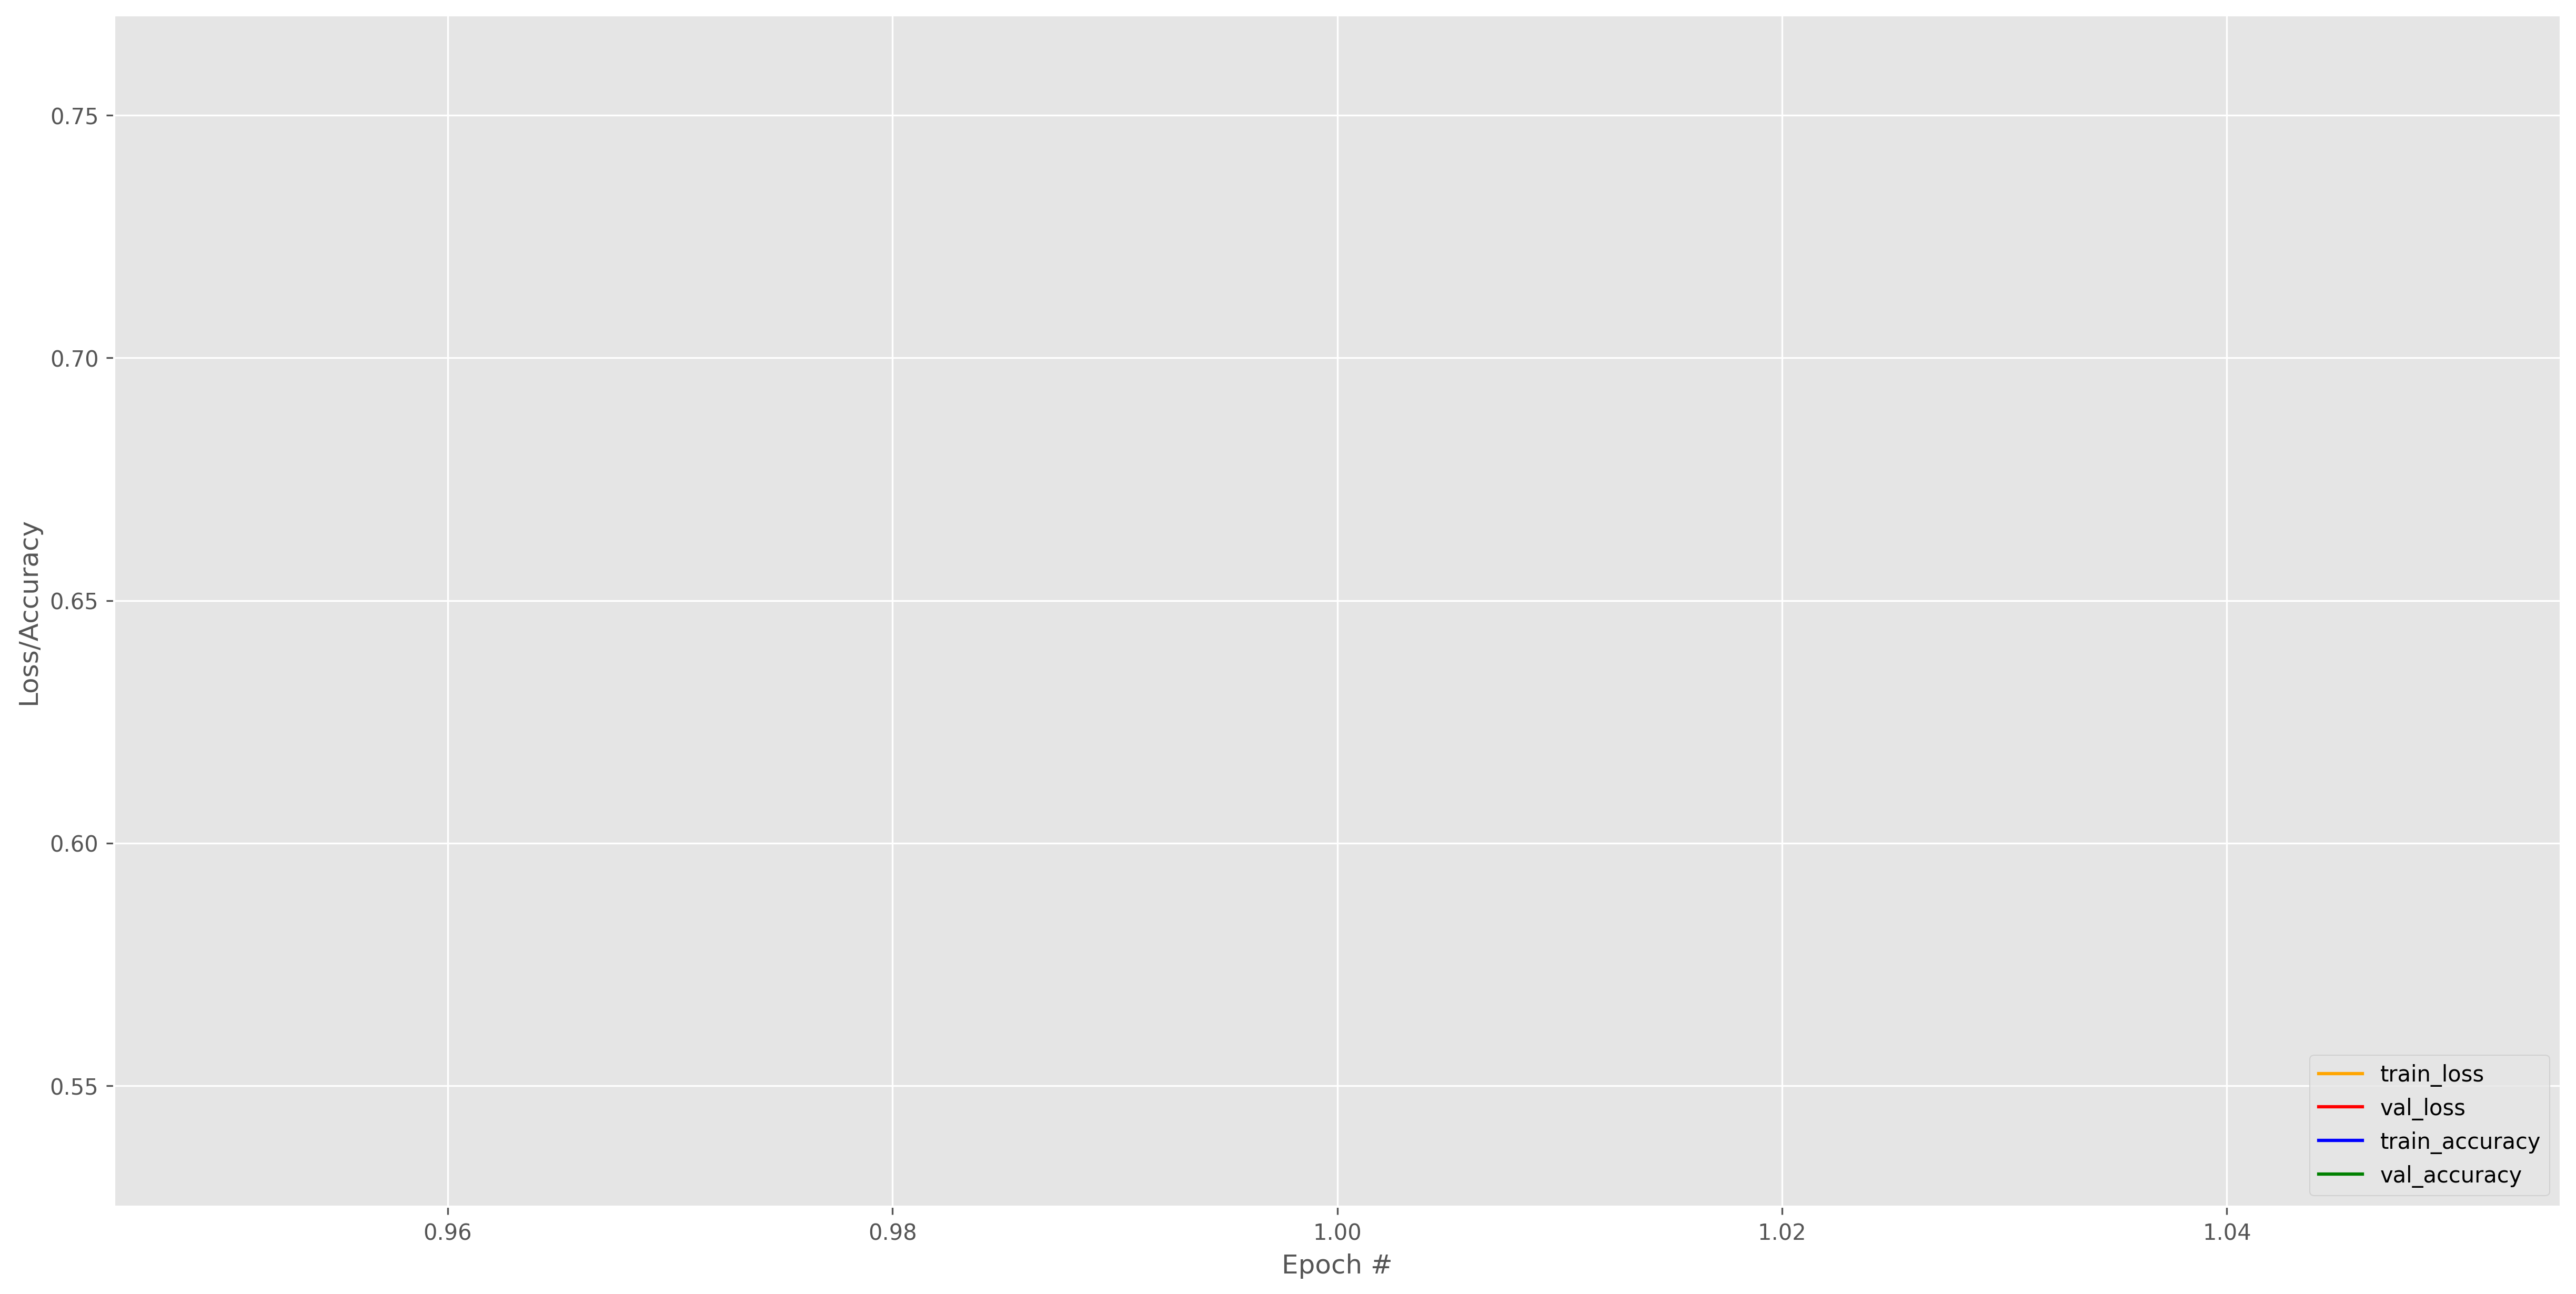

In [107]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("custom_plot.png")

In [108]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
metric = 'val_accuracy'
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + vgg19_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + vgg19_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = vgg19_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    


344/344 [==============================] - 62s 178ms/step - loss: 0.3815 - accuracy: 0.8097 - val_loss: 0.1675 - val_accuracy: 0.9386


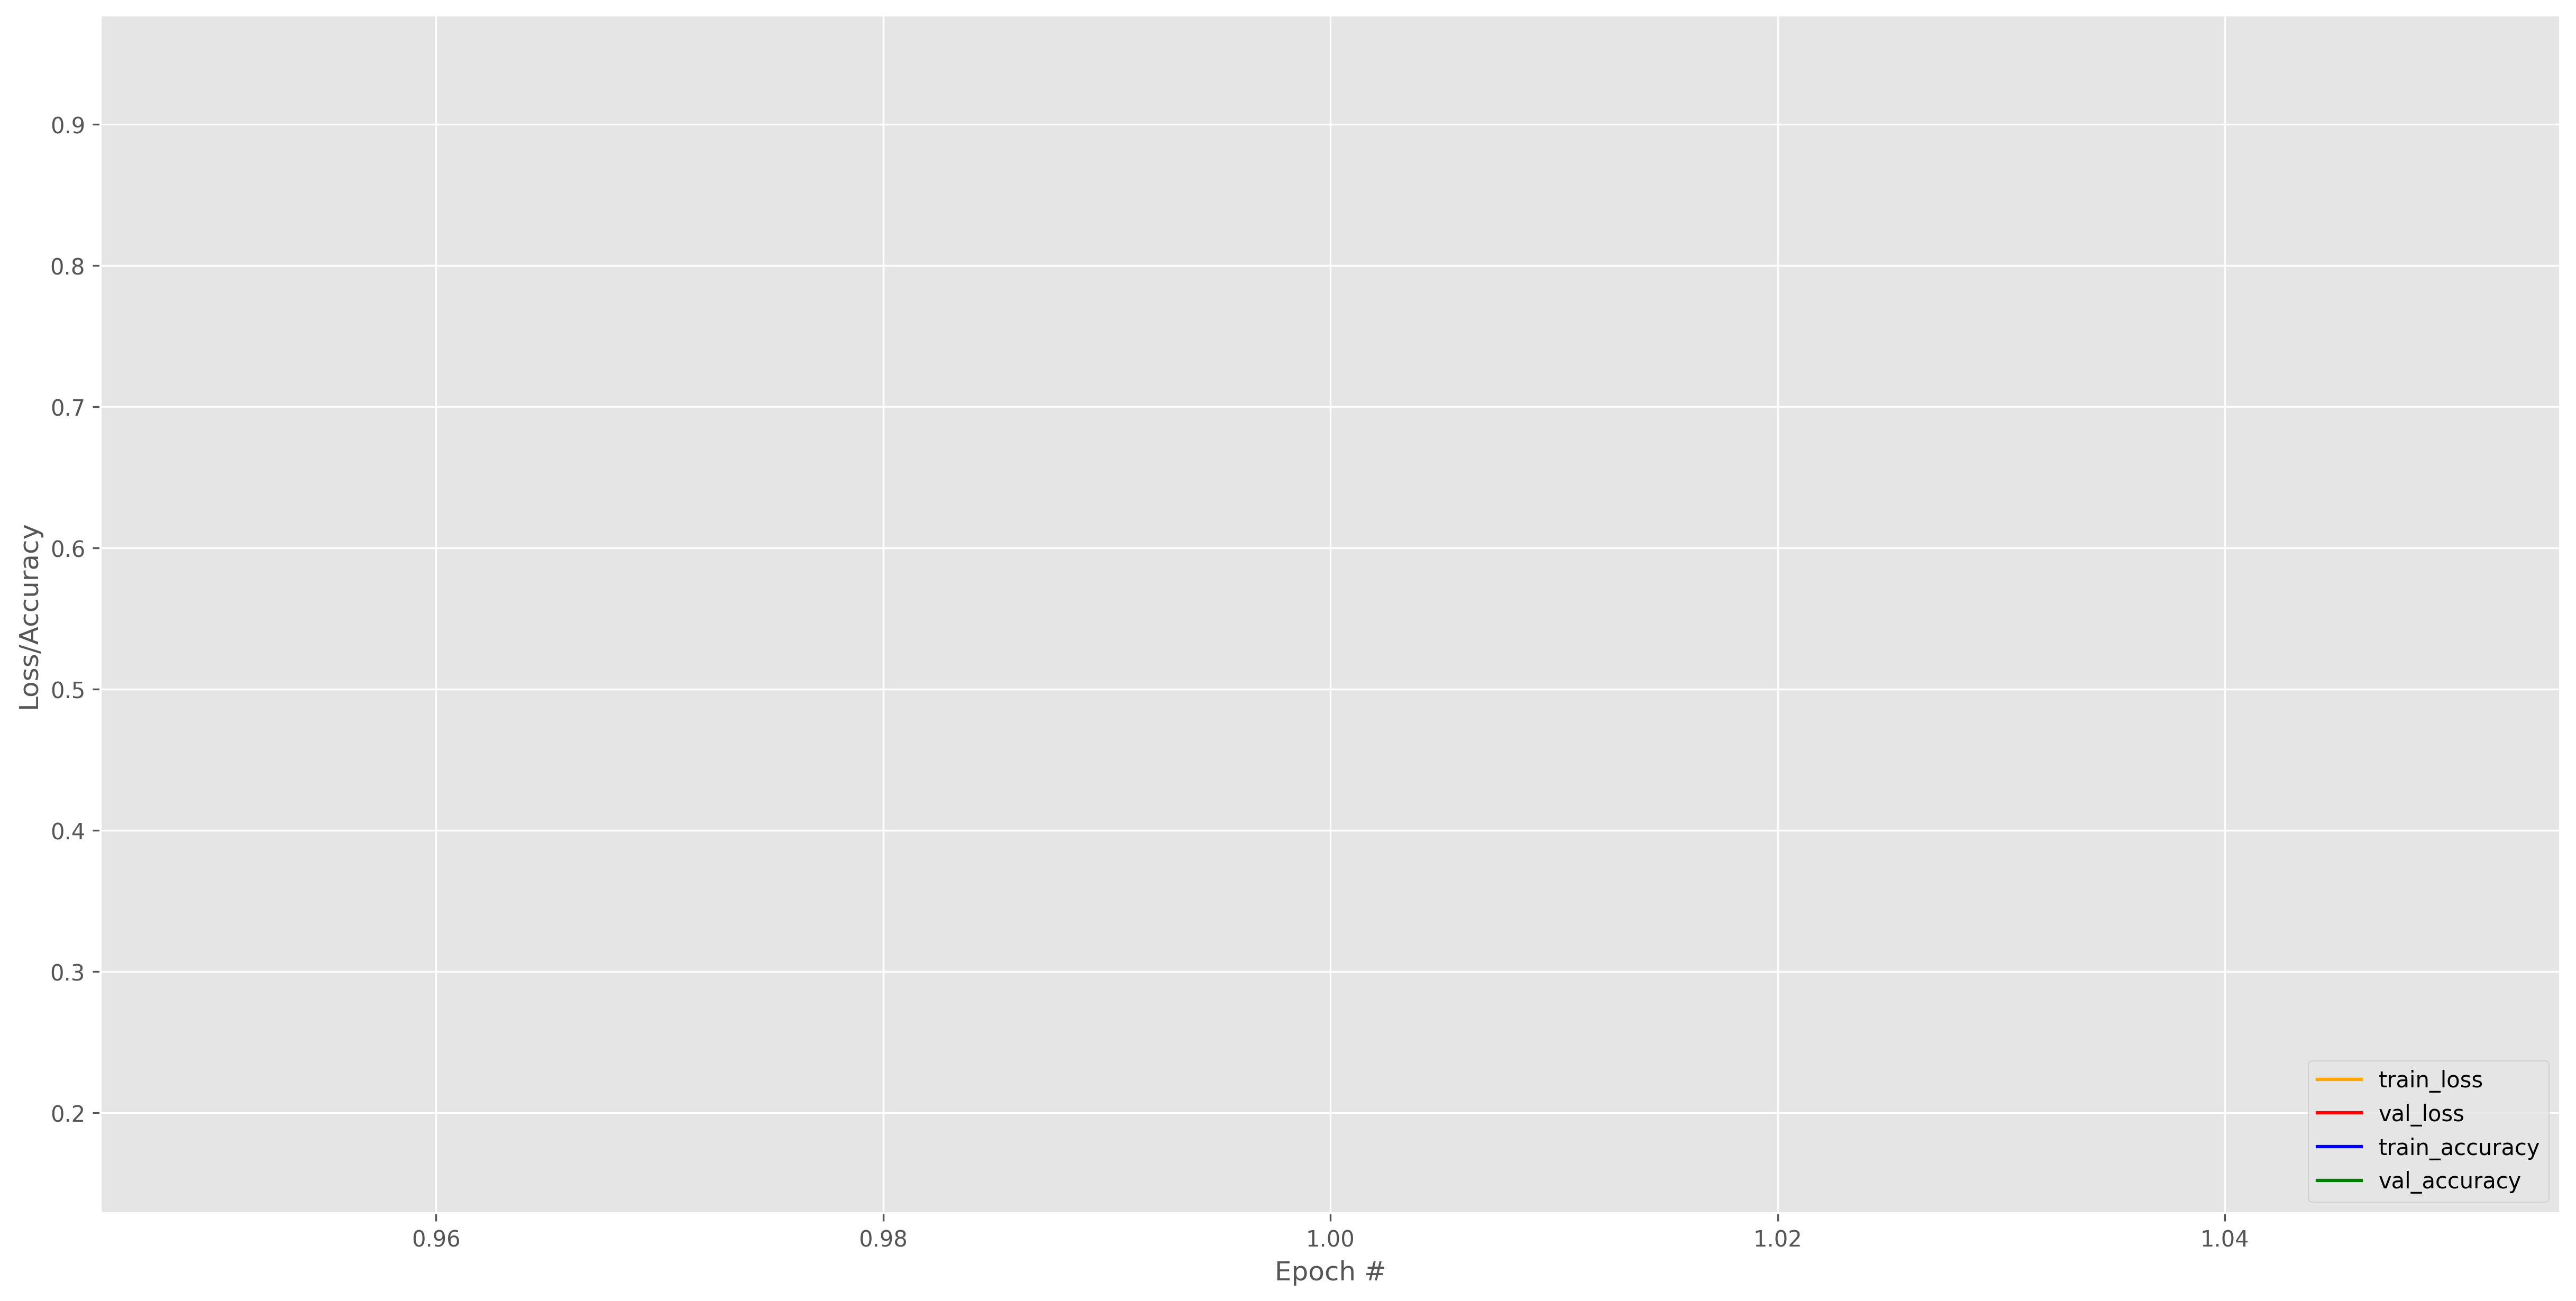

In [109]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("VGG19_custom_plot.png")

In [110]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + squeeze_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + squeeze_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = squeeze_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

344/344 [==============================] - 61s 173ms/step - loss: 0.4595 - accuracy: 0.8047 - val_loss: 0.1414 - val_accuracy: 0.9517


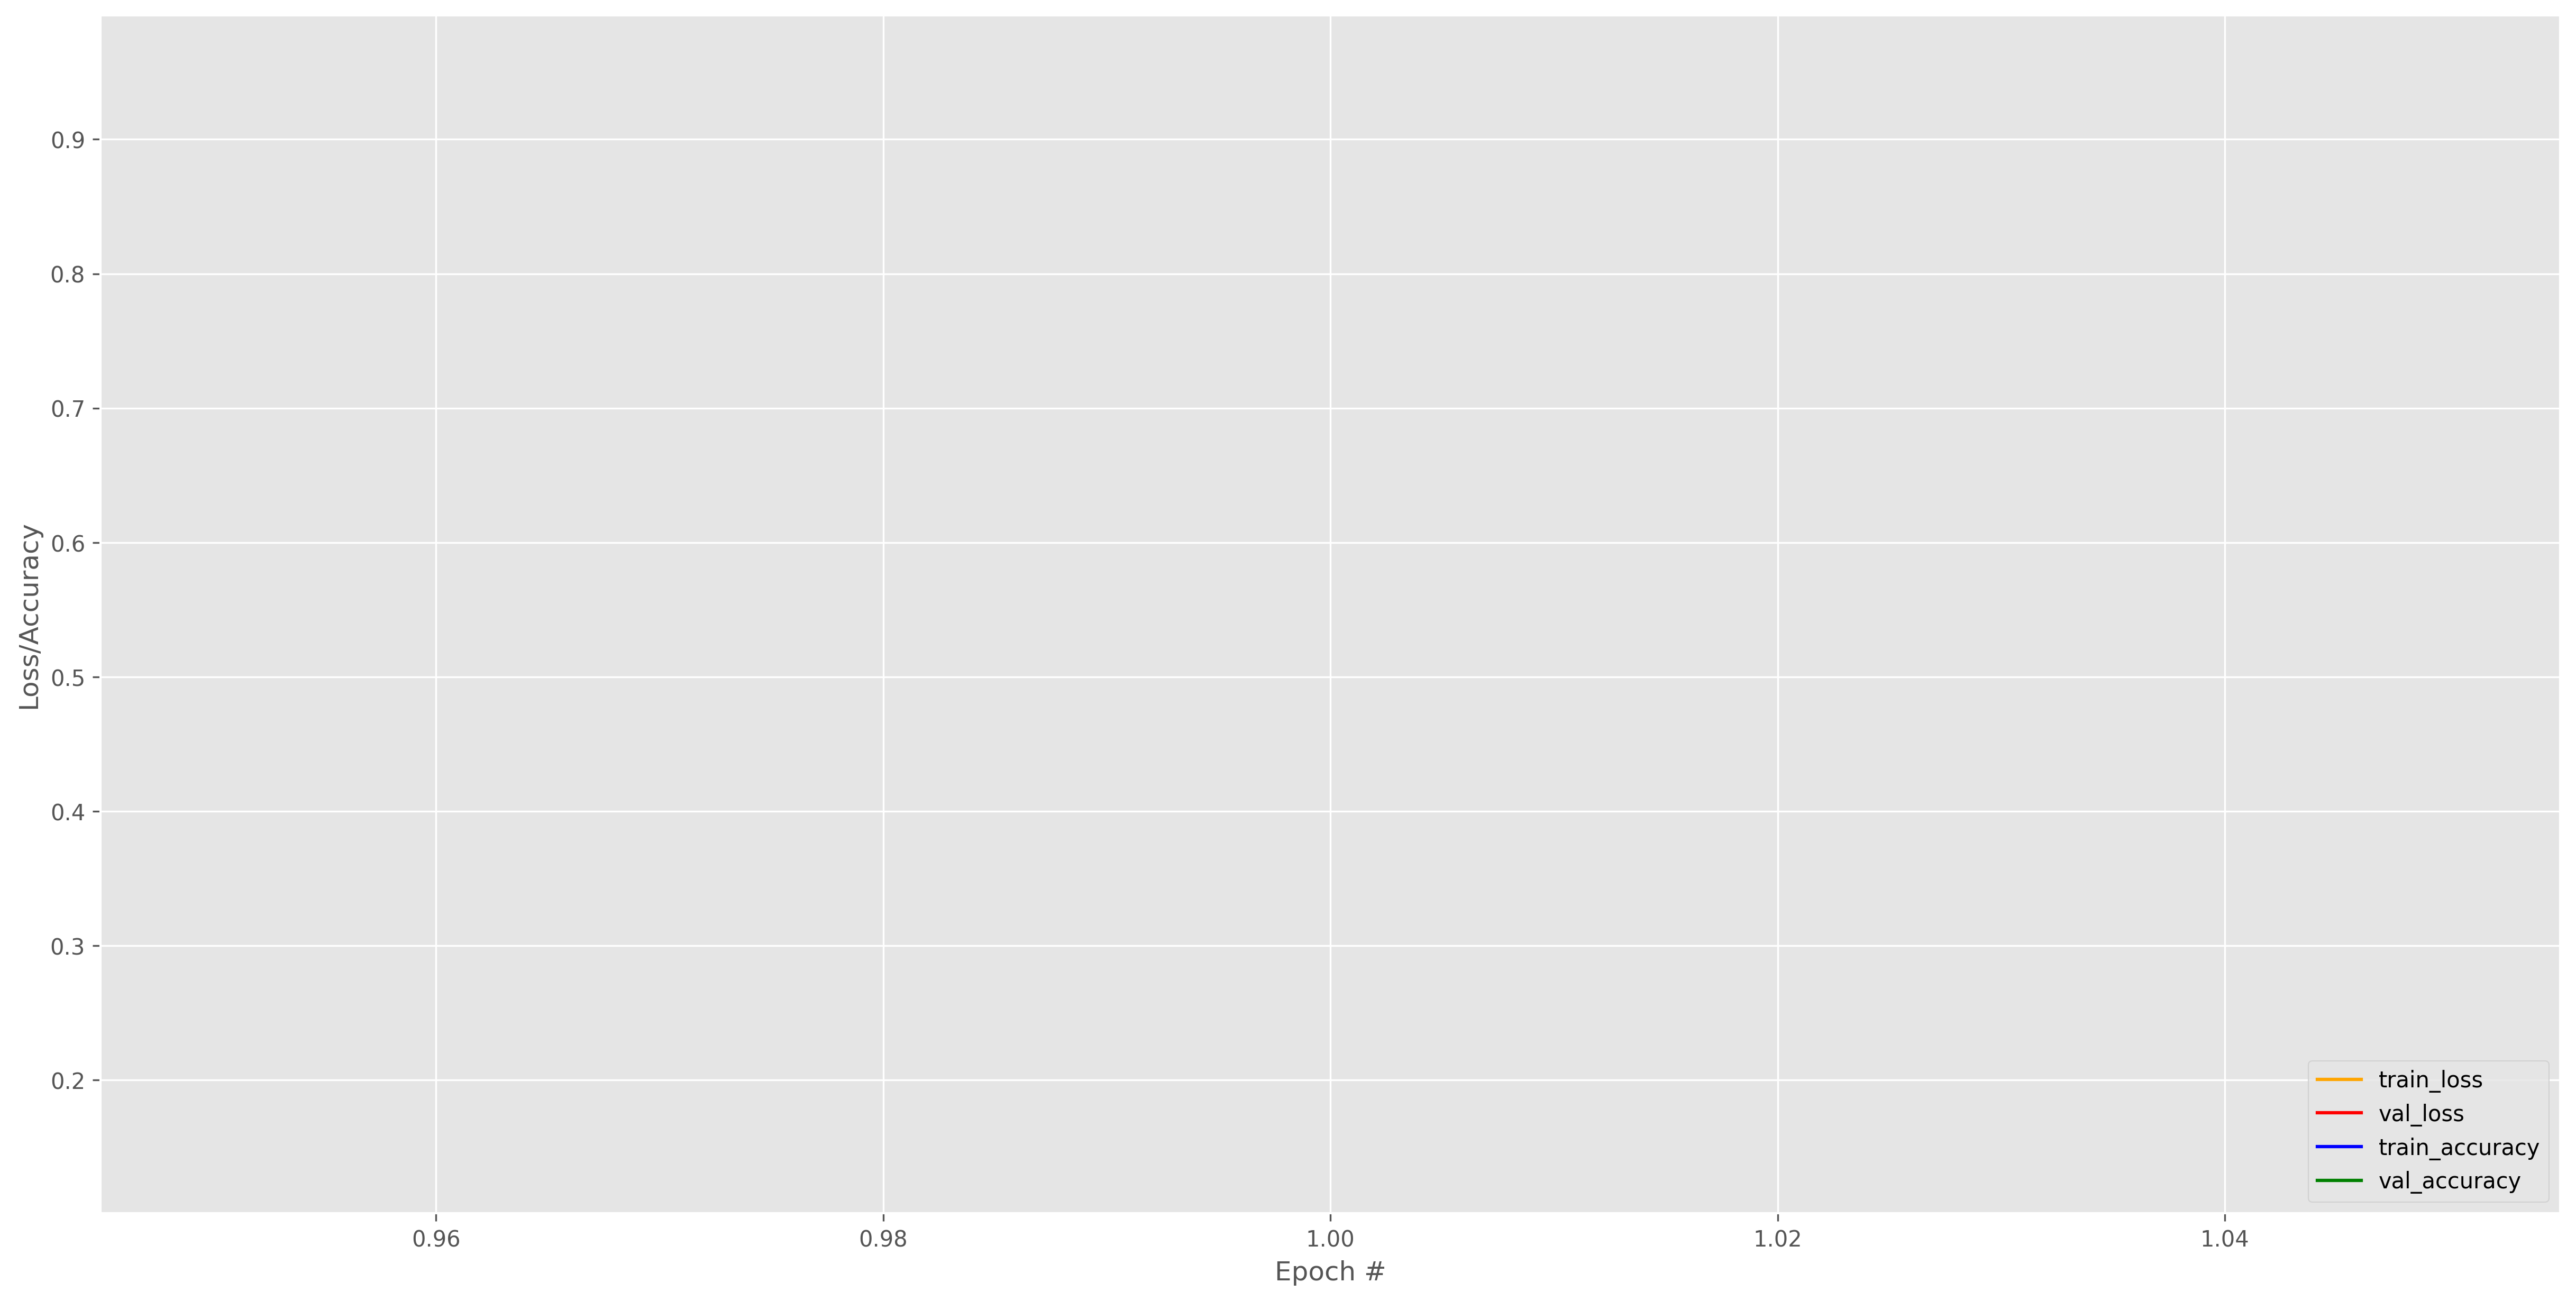

In [111]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("SqueezeNet_custom_plot.png")

In [112]:
#%% compile and train the InceptionResnetV2 model

adam = Adam(lr=0.0001)  
inceptionresnet_custom_model.compile(optimizer=adam,
                                     loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + inceptionresnet_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + inceptionresnet_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = inceptionresnet_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

344/344 [==============================] - 82s 195ms/step - loss: 0.4156 - accuracy: 0.8100 - val_loss: 0.1379 - val_accuracy: 0.9528


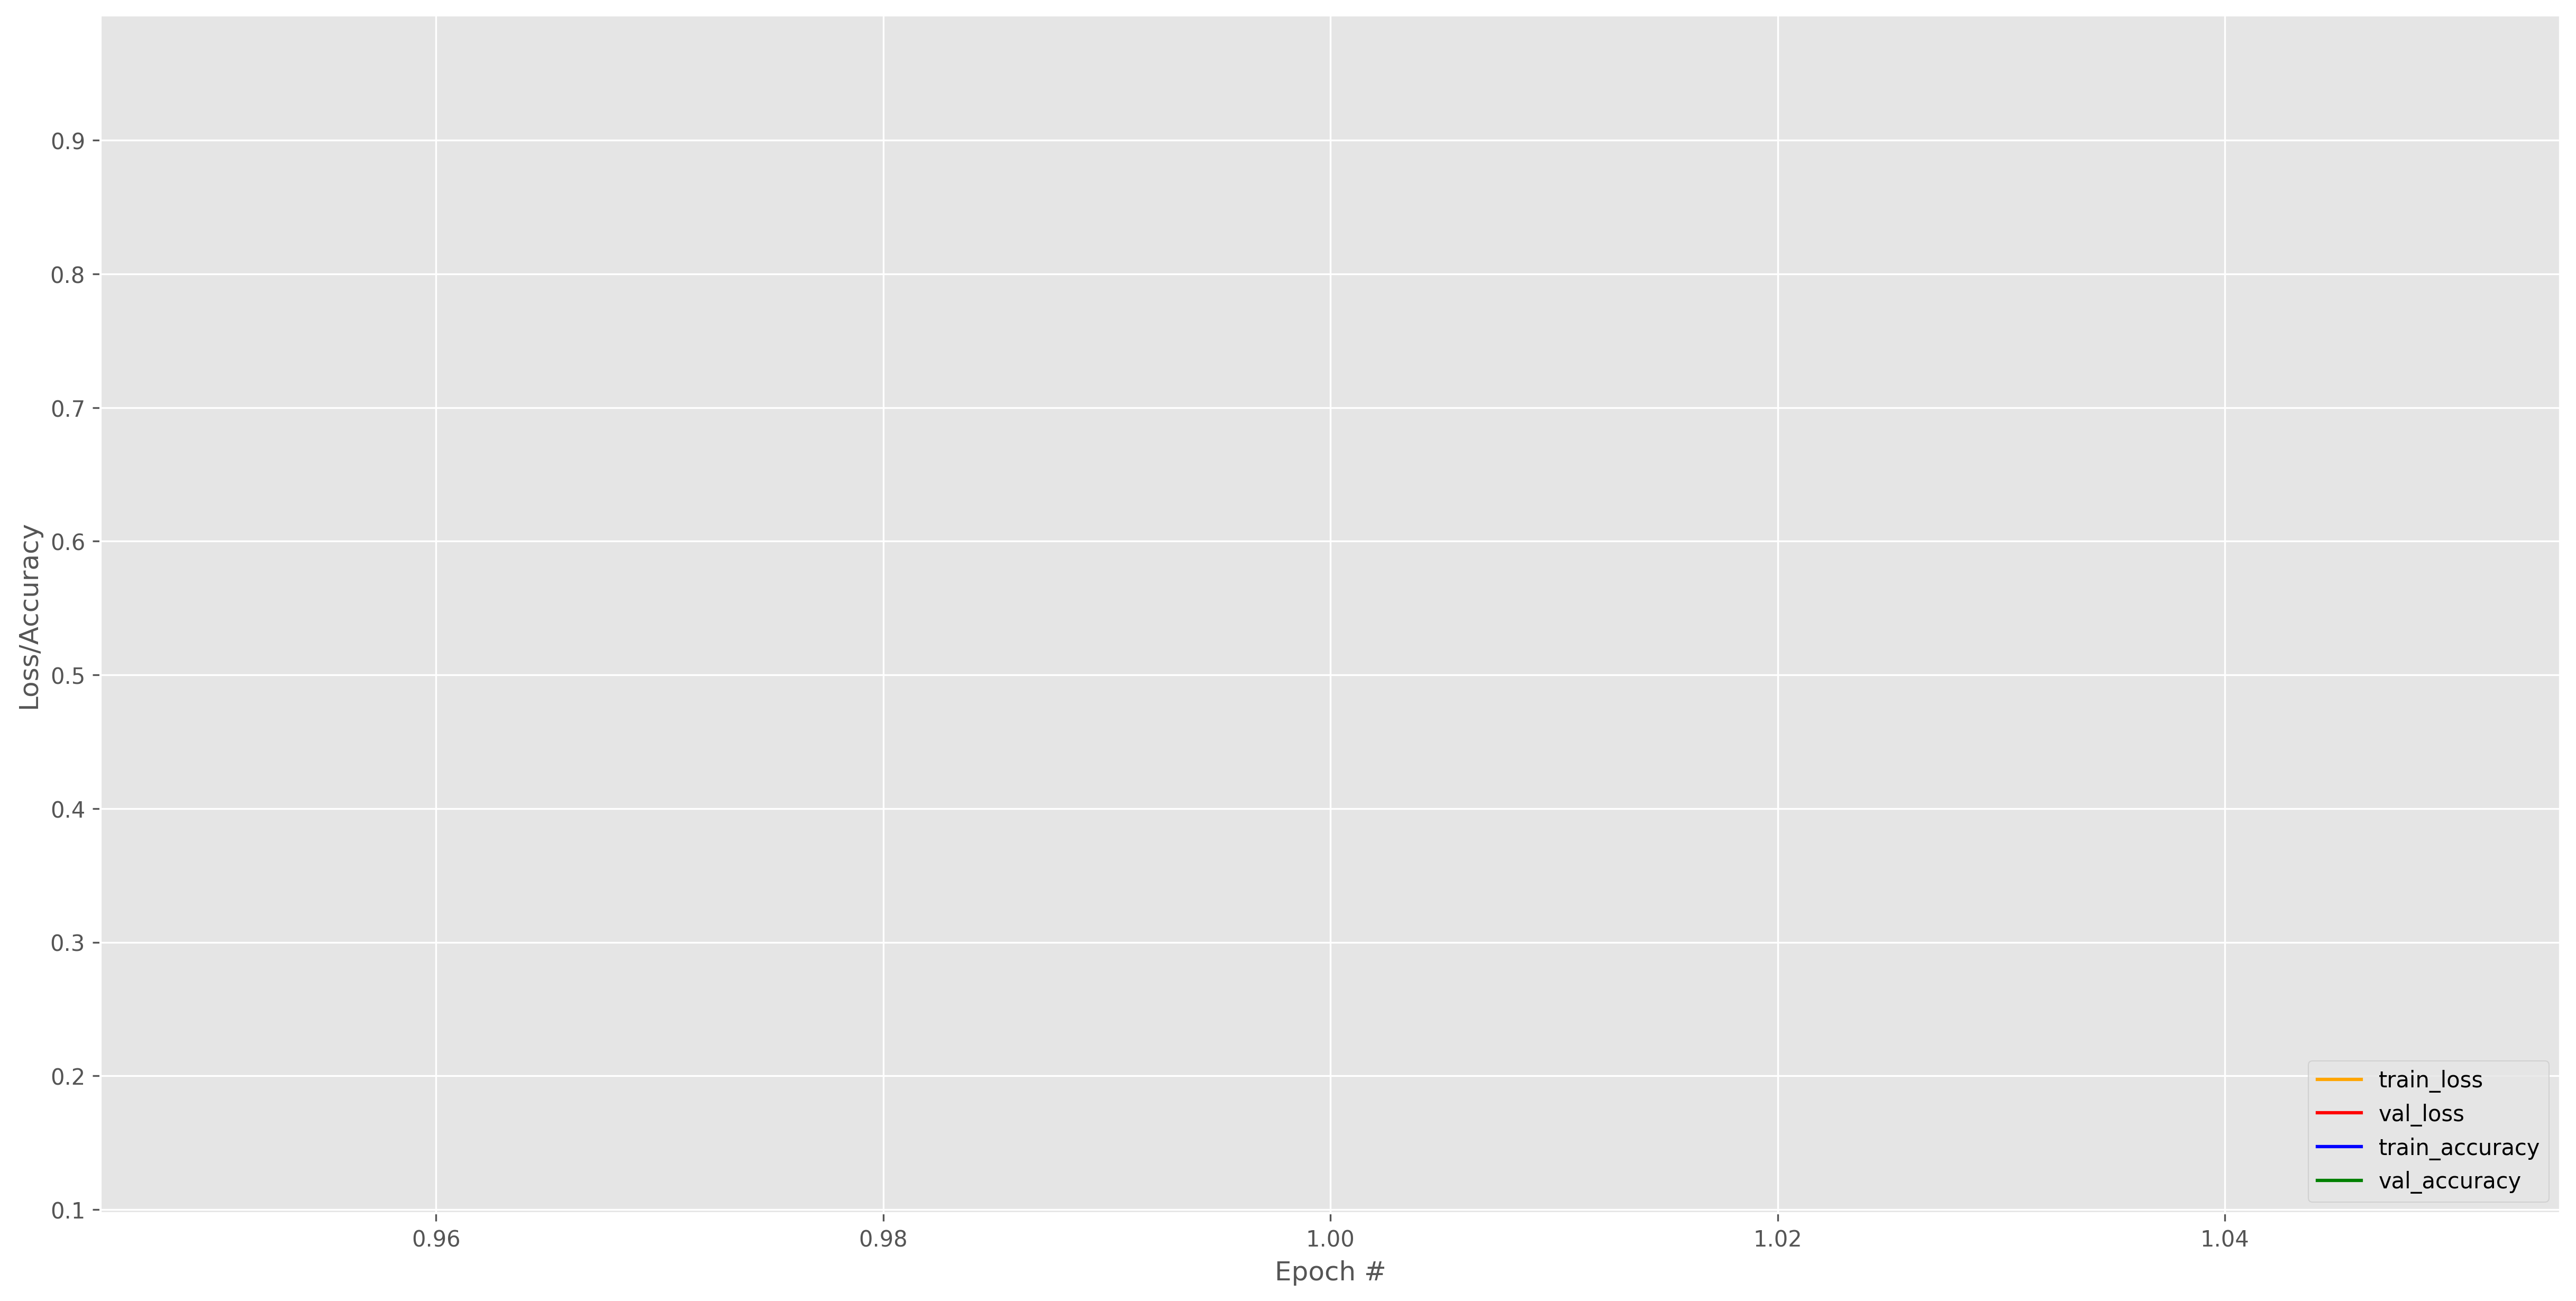

In [113]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("InceptionResnet_custom_plot.png")

In [114]:
#Evaluate the model by loading the best weights
custom_model.load_weights('weights/custom_cnn.h5')

#evaluate accuracy
custom_y_pred = custom_model.predict(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,custom_y_pred.argmax(axis=-1))
print('The accuracy of the Custom model is: ', accuracy)

#evaluate mean squared error
custom_mse = mean_squared_error(Y_test,custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Custom model is: ', custom_mse)

#evaluate mean squared log error
custom_msle = mean_squared_log_error(Y_test,custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Custom model is: ', custom_msle)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


The accuracy of the Custom model is:  0.7597968069666183
The Mean Squared Error of the Custom model is:  0.24020319303338172
The Mean Squared Log Error of the Custom model is:  0.11540634804566376


                   precision    recall  f1-score   support

class 0(abnormal)     0.9931    0.5232    0.6854      1378
  class 1(normal)     0.6764    0.9964    0.8058      1378

         accuracy                         0.7598      2756
        macro avg     0.8347    0.7598    0.7456      2756
     weighted avg     0.8347    0.7598    0.7456      2756

Confusion matrix, without normalization
[[ 721  657]
 [   5 1373]]


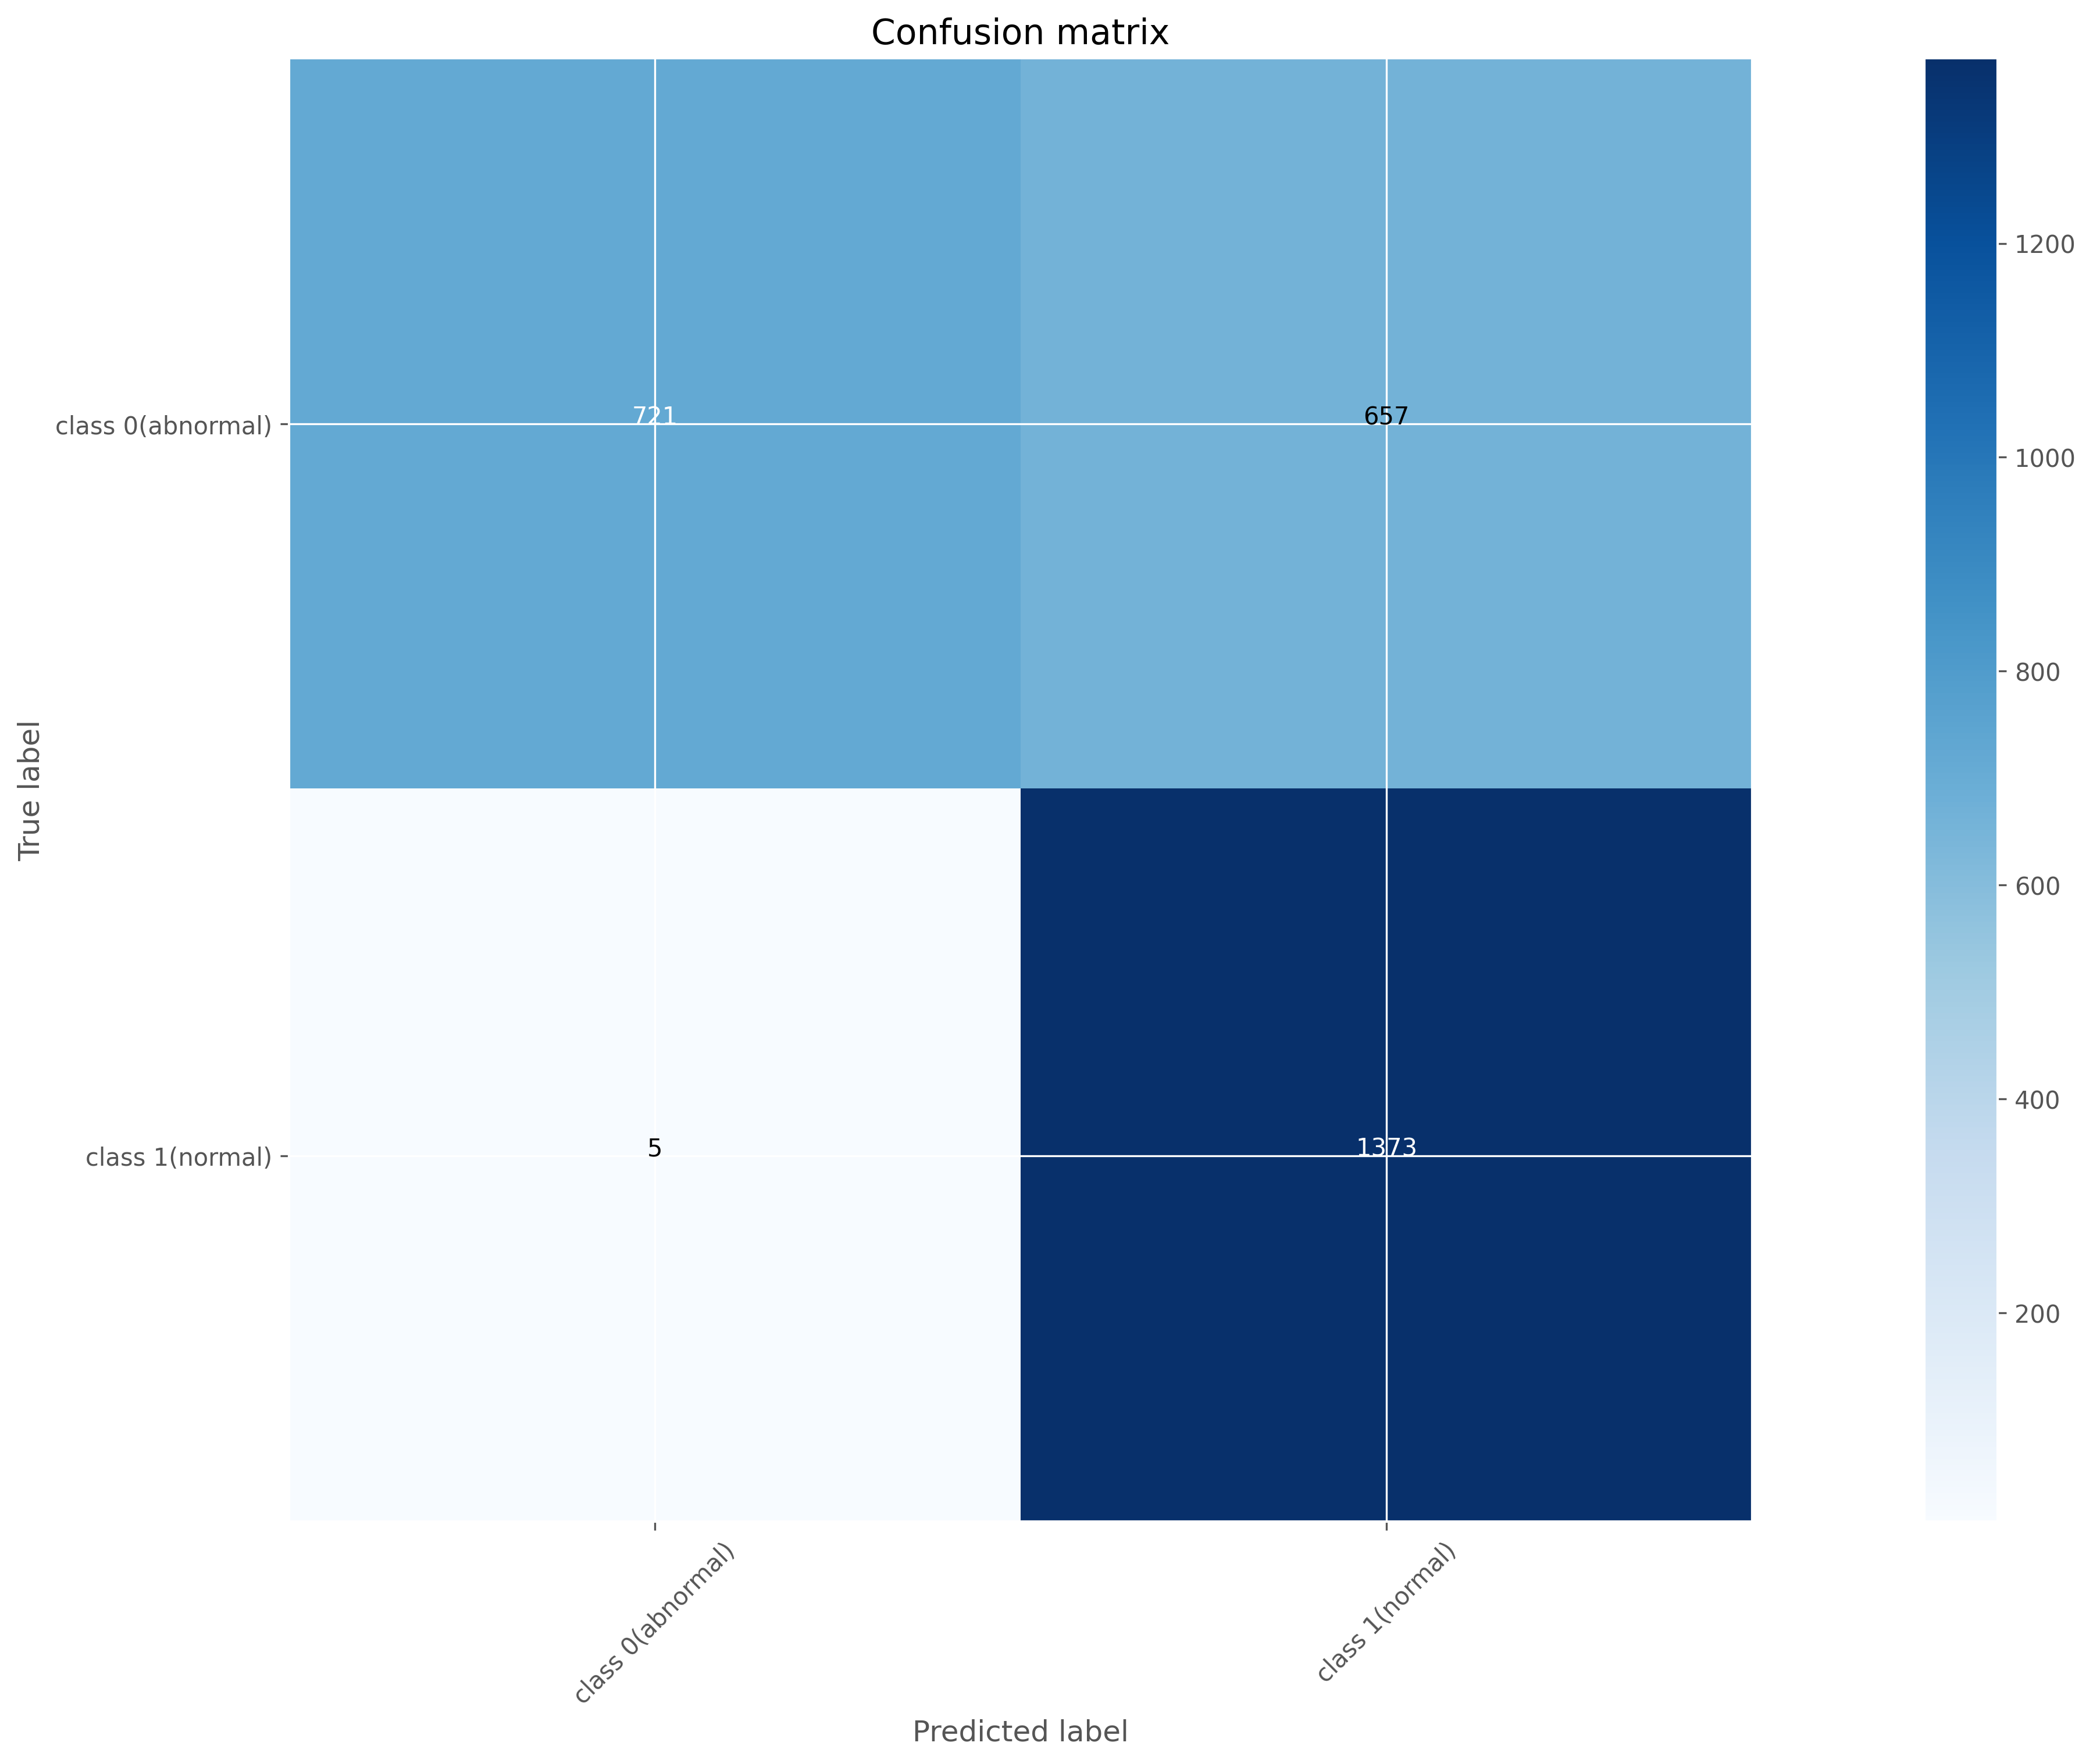

In [115]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


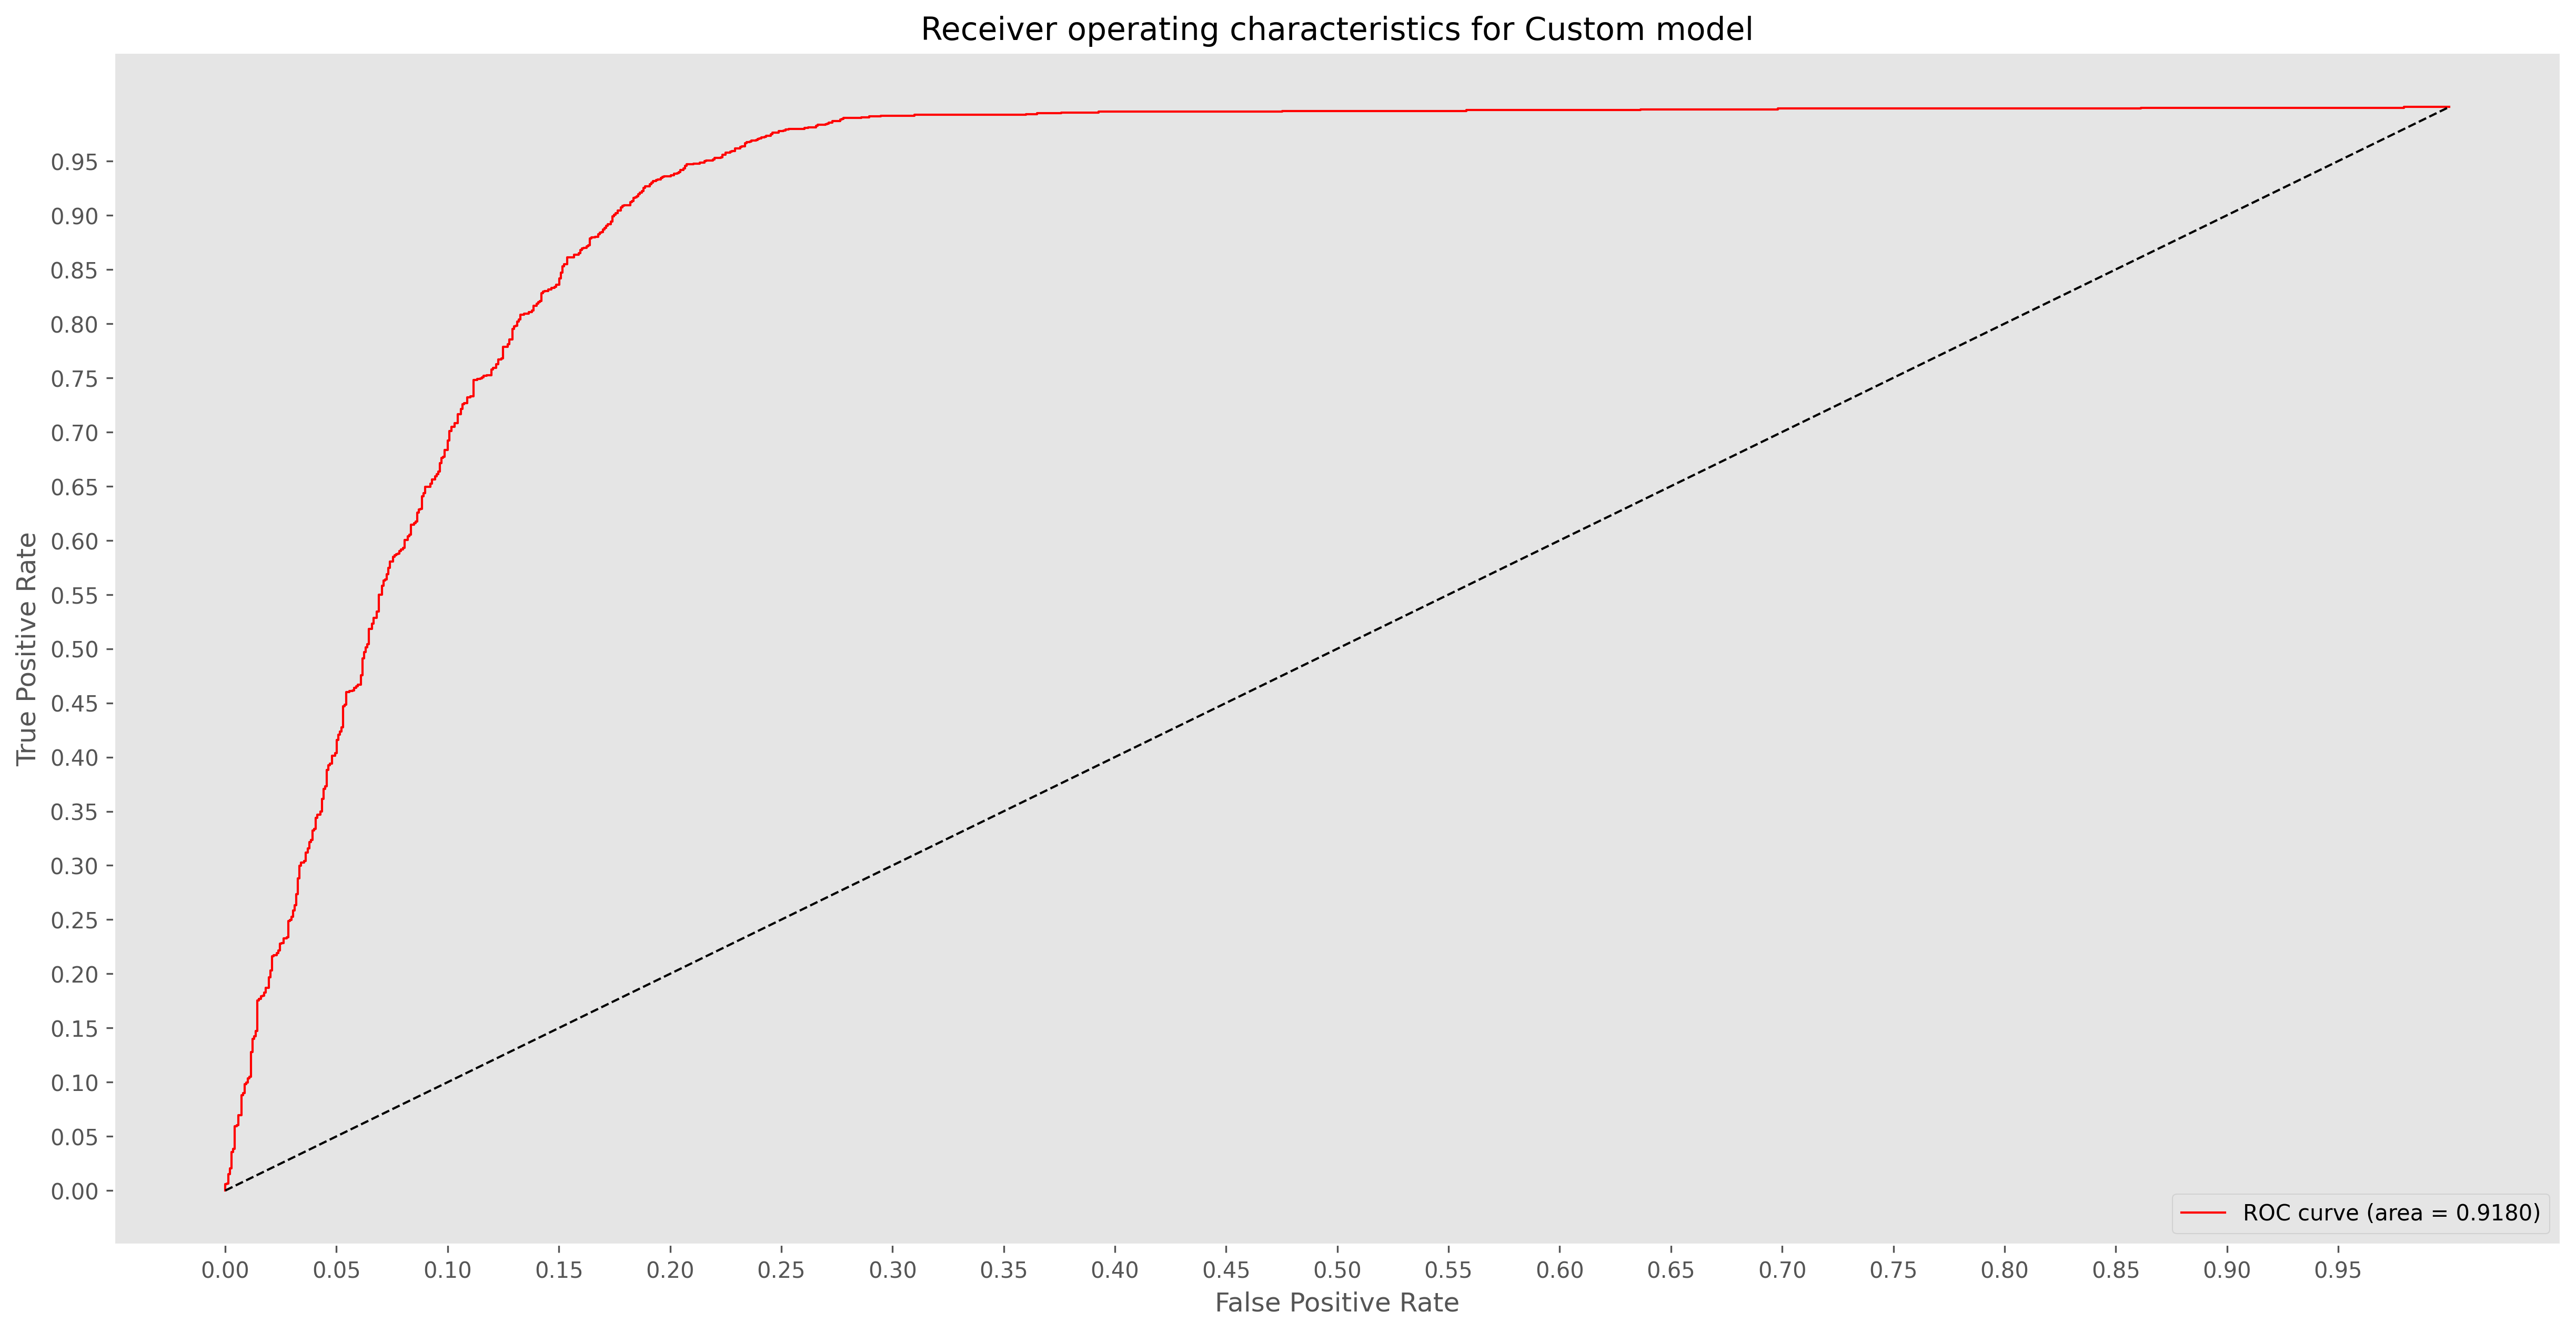

In [116]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Custom model')
plt.legend(loc="lower right")
plt.show()

In [117]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


The accuracy of the VGG19 Custom model is:  0.9386792452830188
The Mean Squared Error of the VGG19 Custom model is:  0.06132075471698113
The Mean Squared Log Error of the VGG19 Custom model is:  0.02946174141951235


                   precision    recall  f1-score   support

class 0(abnormal)     0.9060    0.9790    0.9411      1378
  class 1(normal)     0.9771    0.8984    0.9361      1378

         accuracy                         0.9387      2756
        macro avg     0.9415    0.9387    0.9386      2756
     weighted avg     0.9415    0.9387    0.9386      2756

Confusion matrix, without normalization
[[1349   29]
 [ 140 1238]]


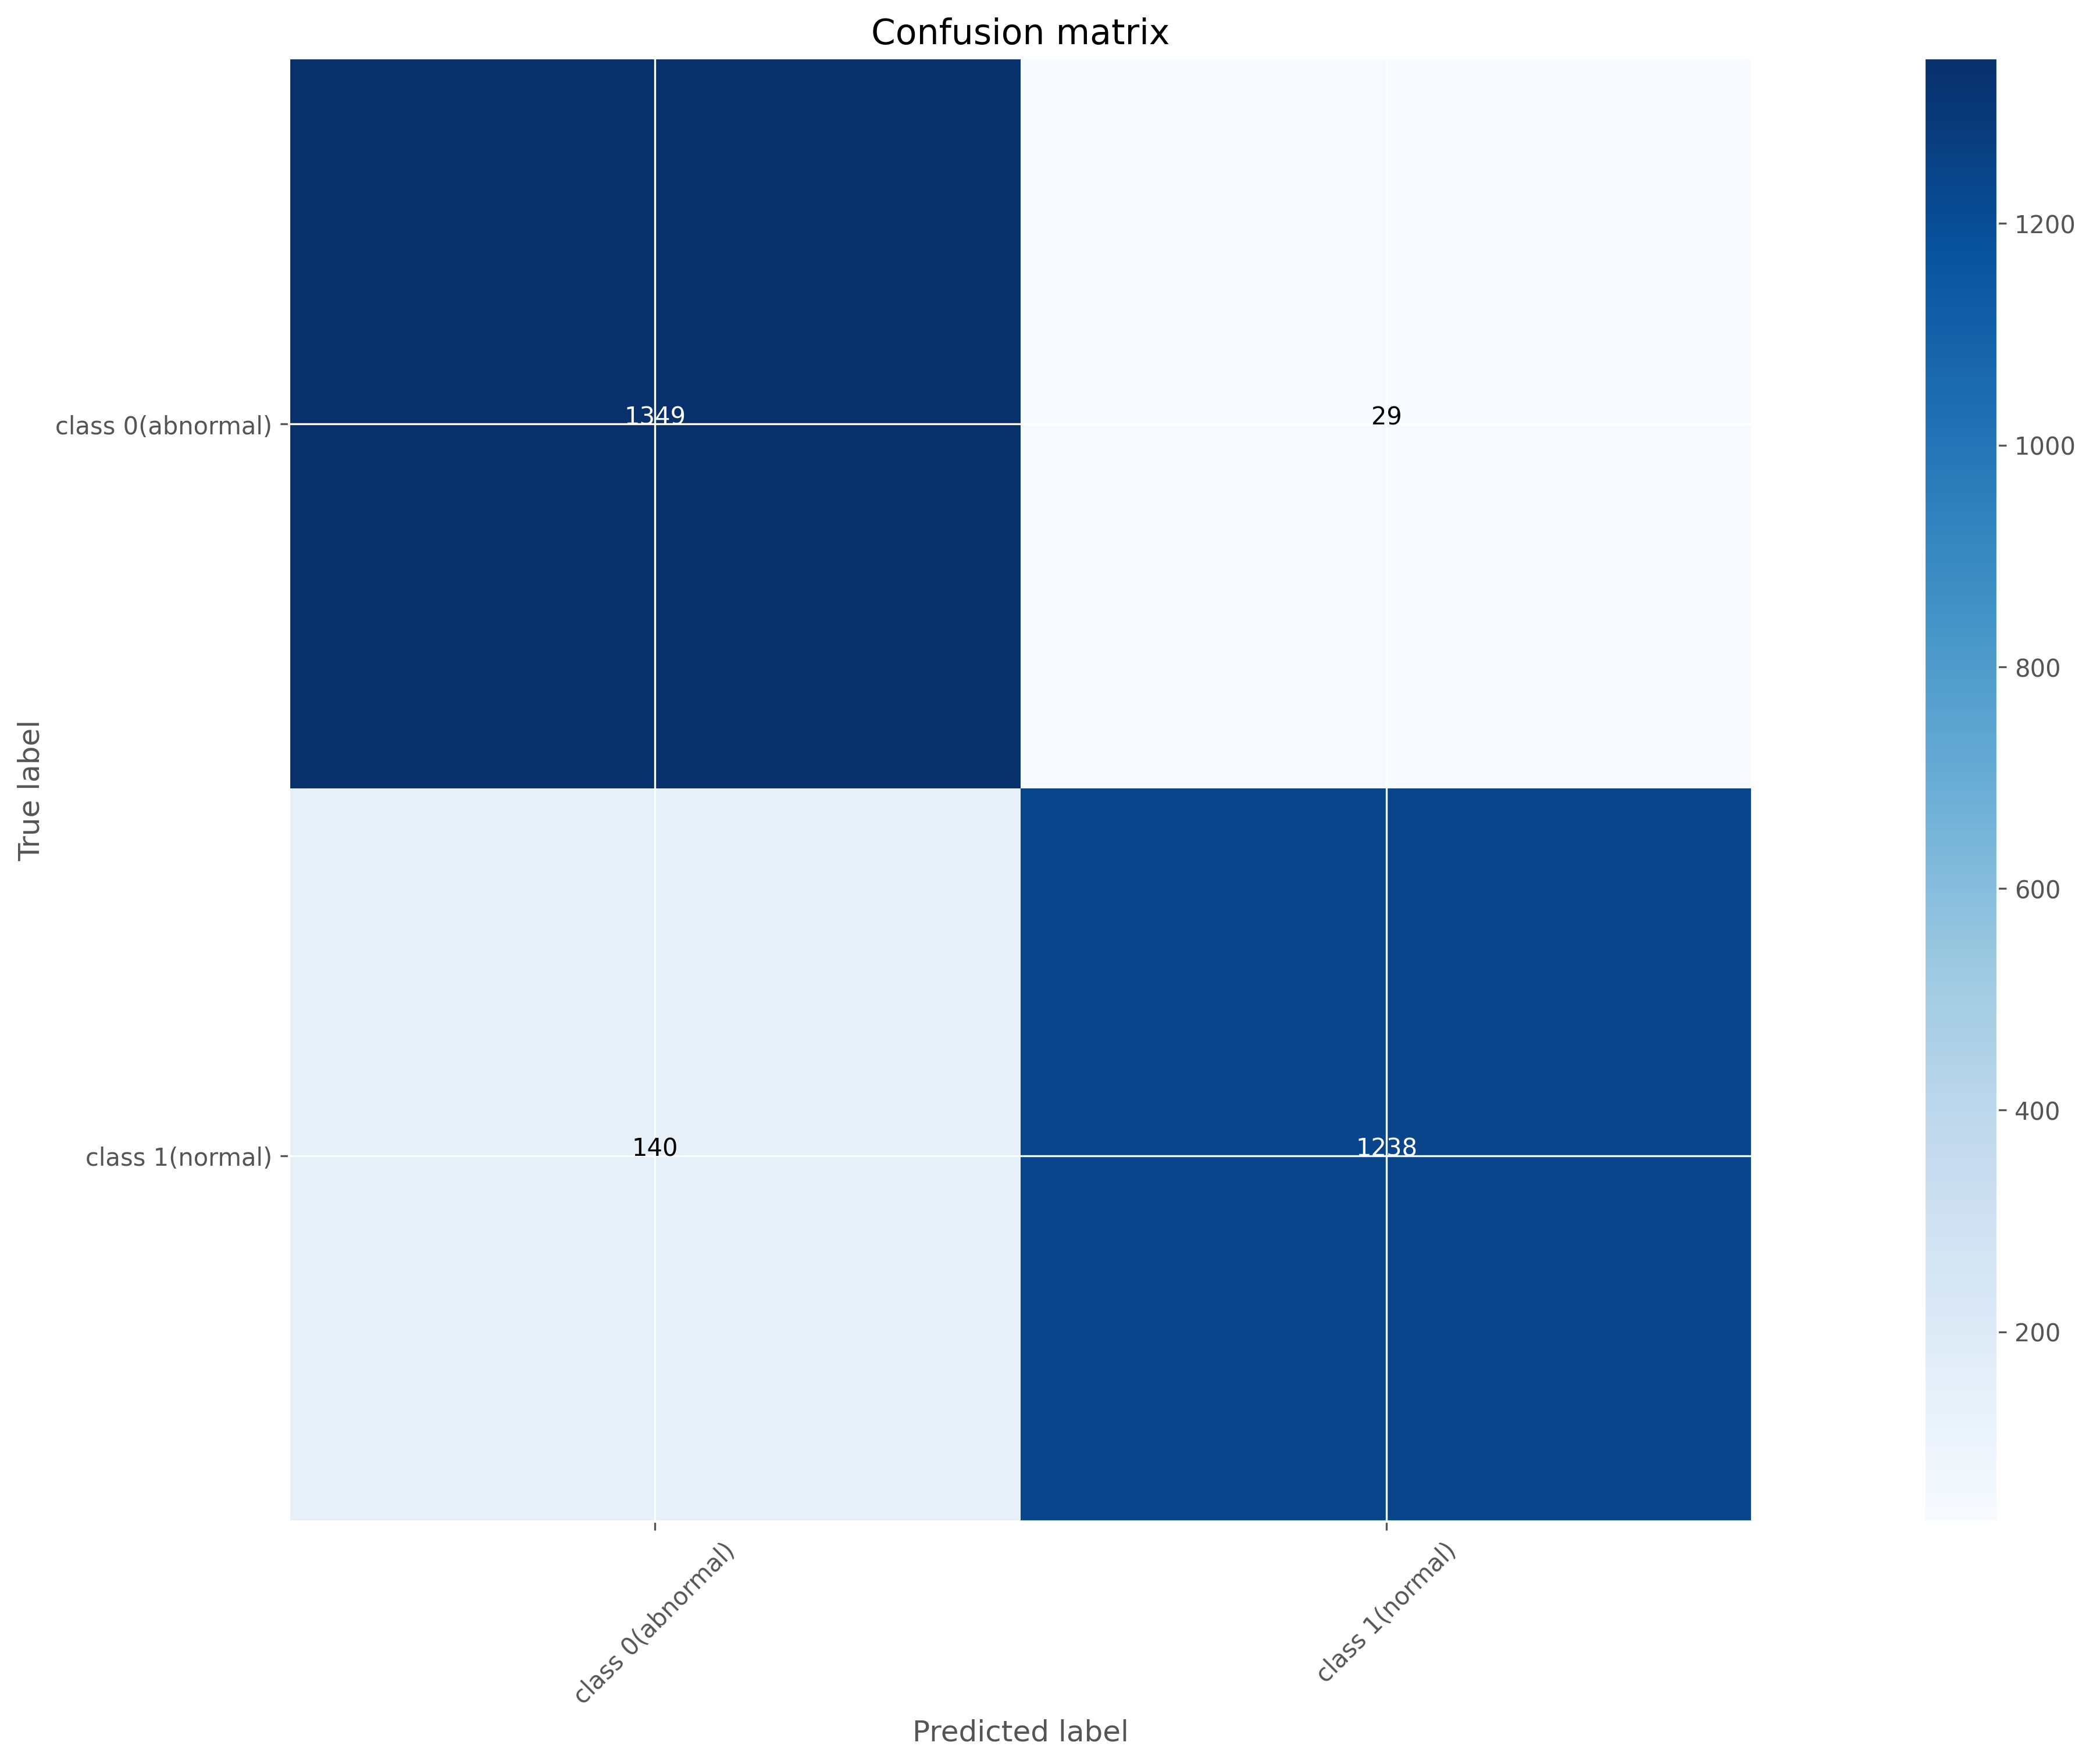

In [118]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


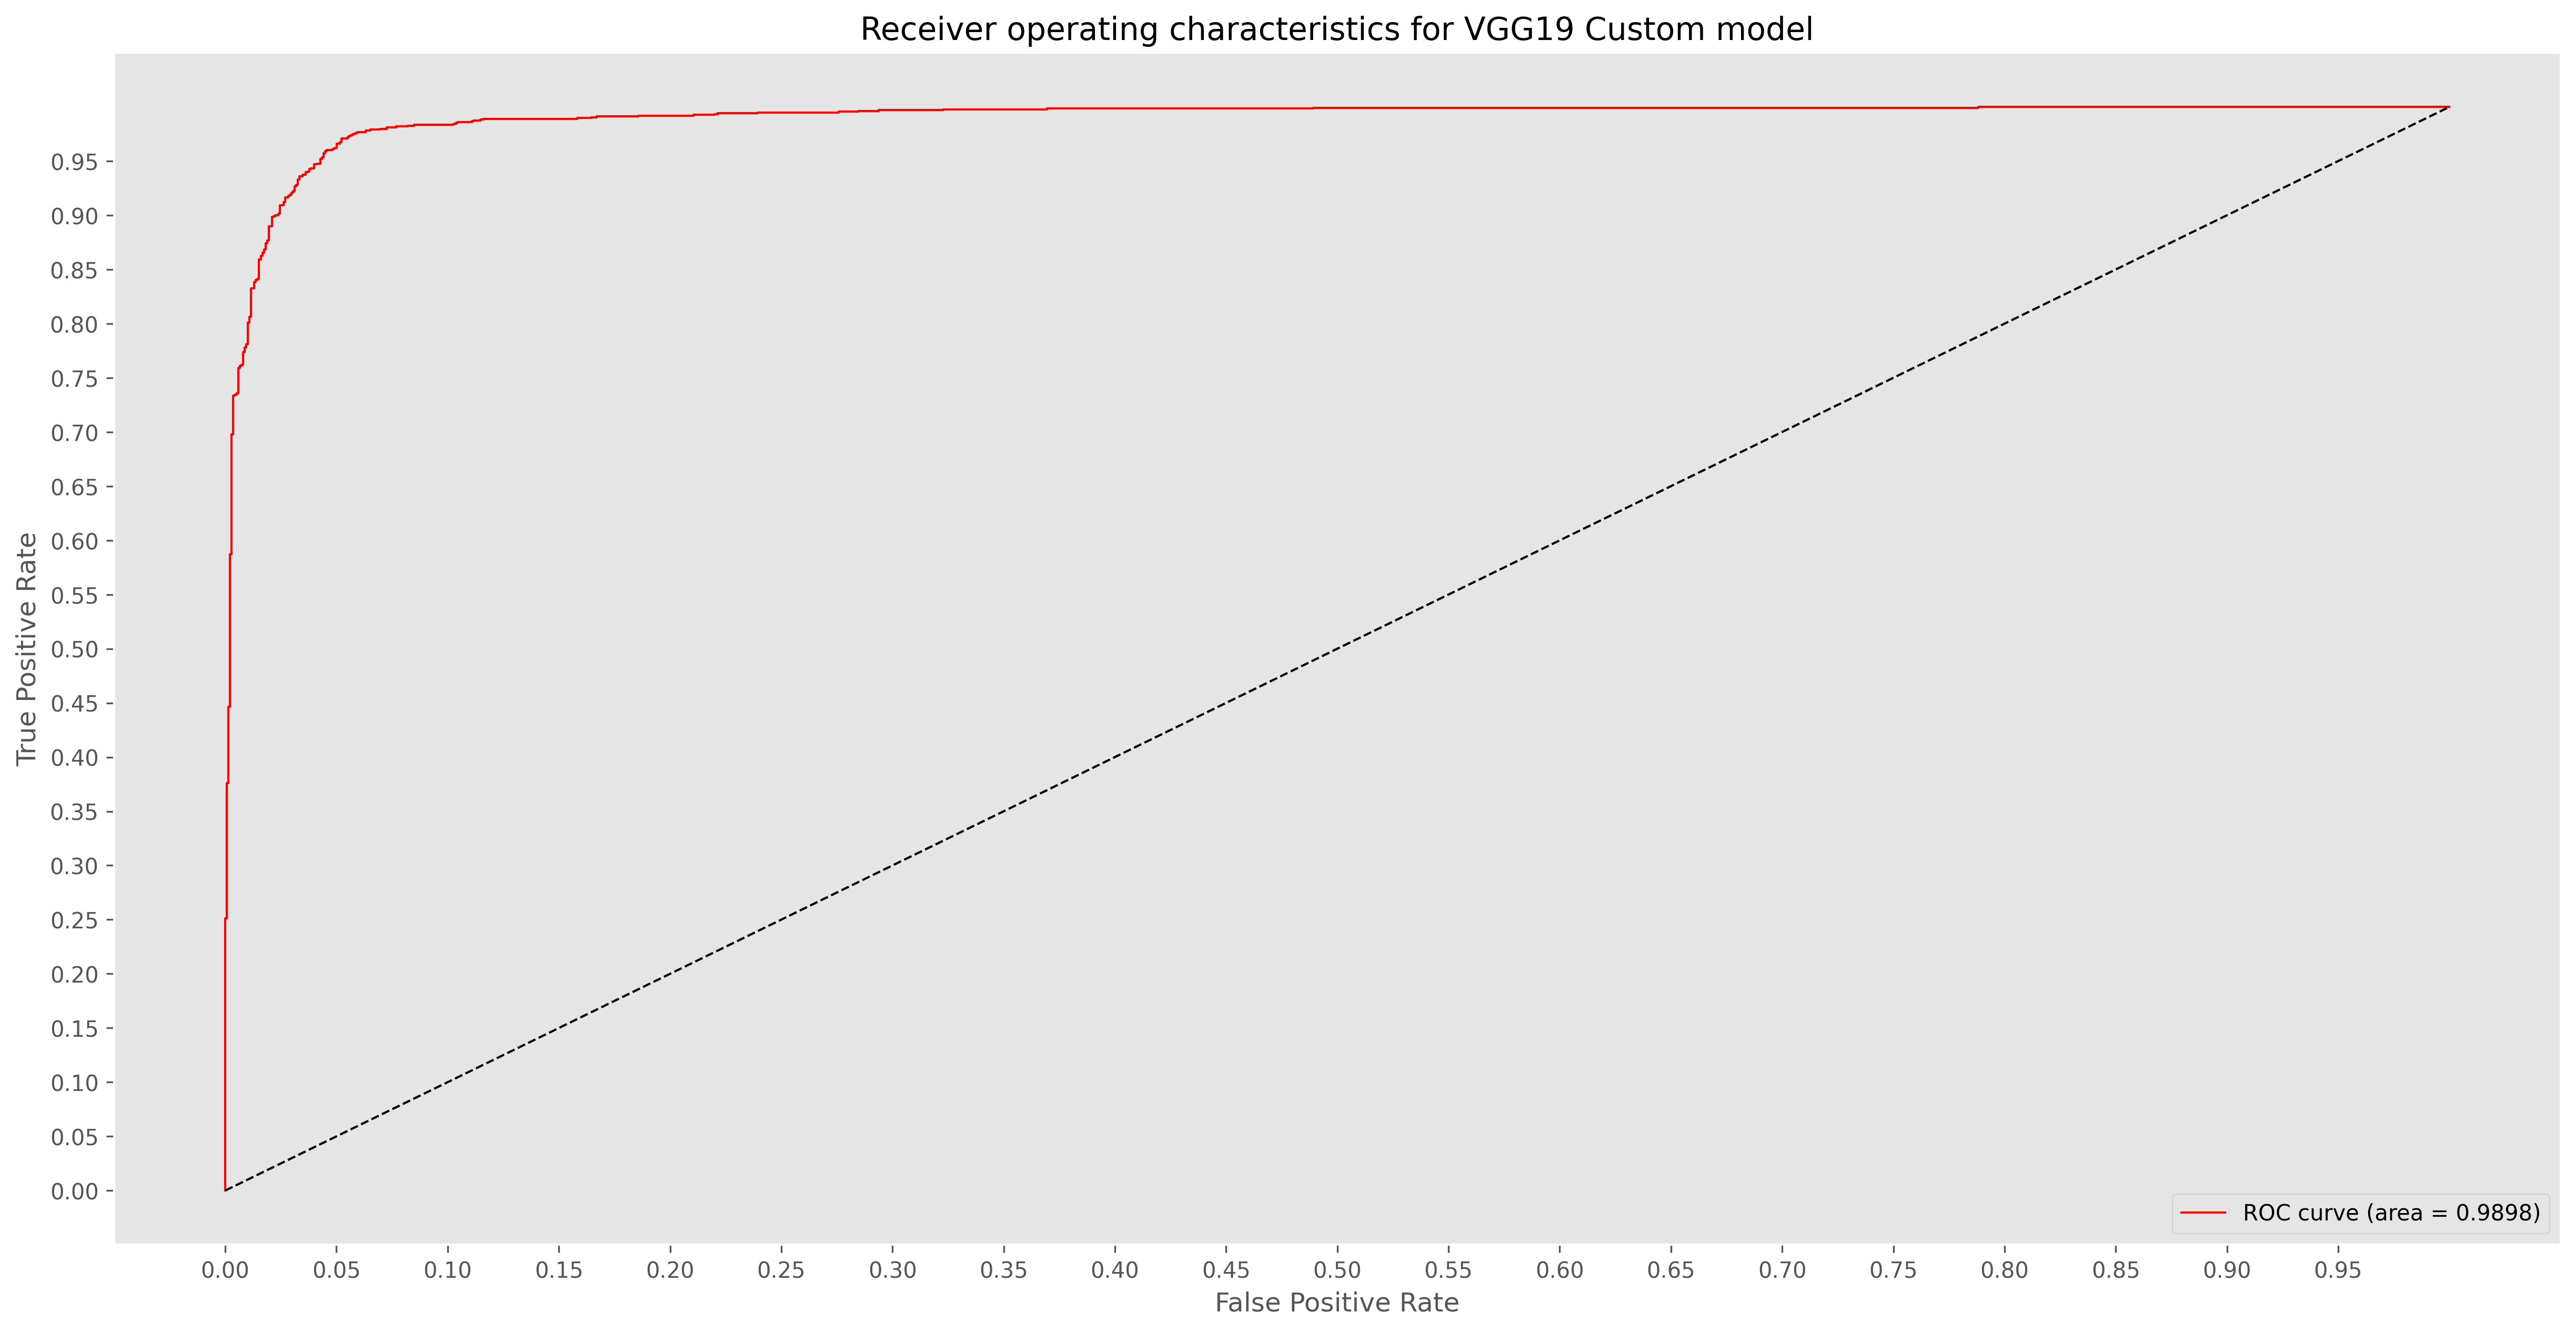

In [119]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, vgg19_custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for VGG19 Custom model')
plt.legend(loc="lower right")
plt.show()


In [120]:
#Evaluate the model by loading the best weights 
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')

#evaluate accuracy

squeeze_y_pred = squeeze_custom_model.predict(validation_generator,
                                                        nb_validation_samples/batch_size, workers=1)
squeeze_accuracy = accuracy_score(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The accuracy of the SqueezeNet Custom model is: ', squeeze_accuracy)

#evaluate mean squared error

squeeze_custom_mse = mean_squared_error(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the SqueezeNet Custom model is: ', squeeze_custom_mse)

#evaluate mean squared log error

squeeze_custom_msle = mean_squared_log_error(Y_test,squeeze_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the SqueezeNet Custom model is: ', squeeze_custom_msle)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


The accuracy of the SqueezeNet Custom model is:  0.9517416545718432
The Mean Squared Error of the SqueezeNet Custom model is:  0.04825834542815675
The Mean Squared Log Error of the SqueezeNet Custom model is:  0.02318586750766356


                   precision    recall  f1-score   support

class 0(abnormal)     0.9734    0.9289    0.9506      1378
  class 1(normal)     0.9320    0.9746    0.9528      1378

         accuracy                         0.9517      2756
        macro avg     0.9527    0.9517    0.9517      2756
     weighted avg     0.9527    0.9517    0.9517      2756

Confusion matrix, without normalization
[[1280   98]
 [  35 1343]]


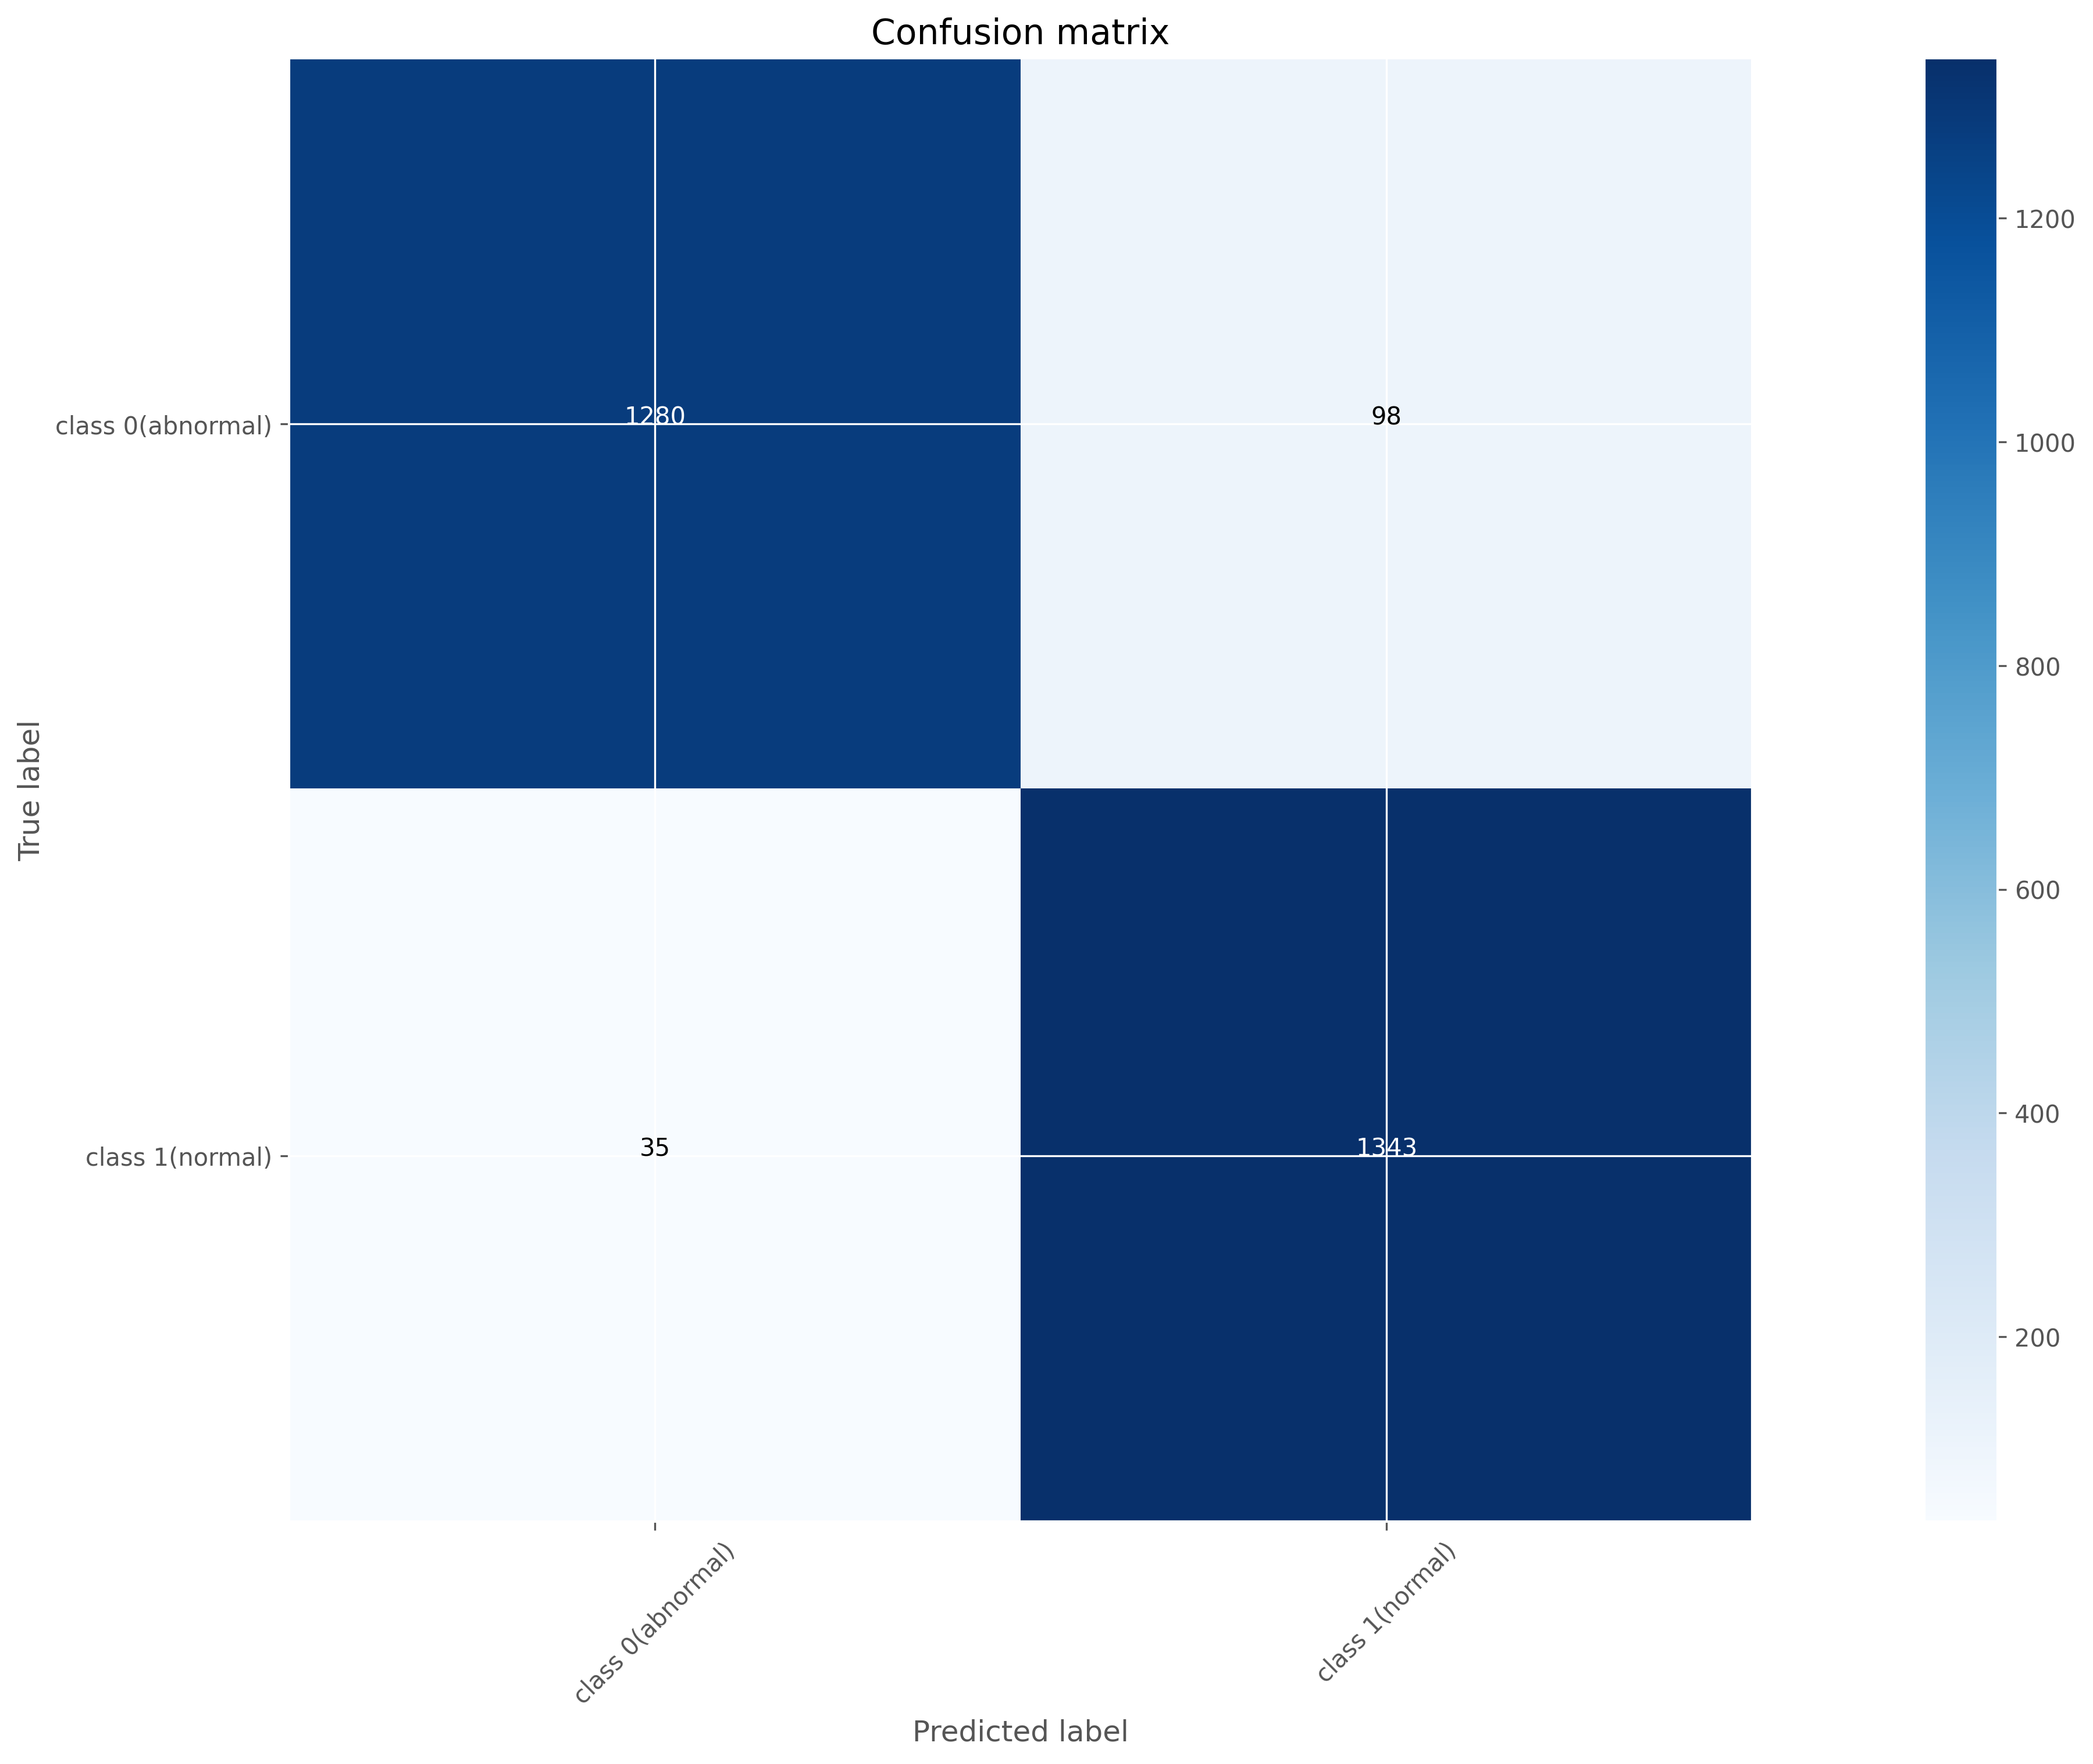

In [121]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,squeeze_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,squeeze_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


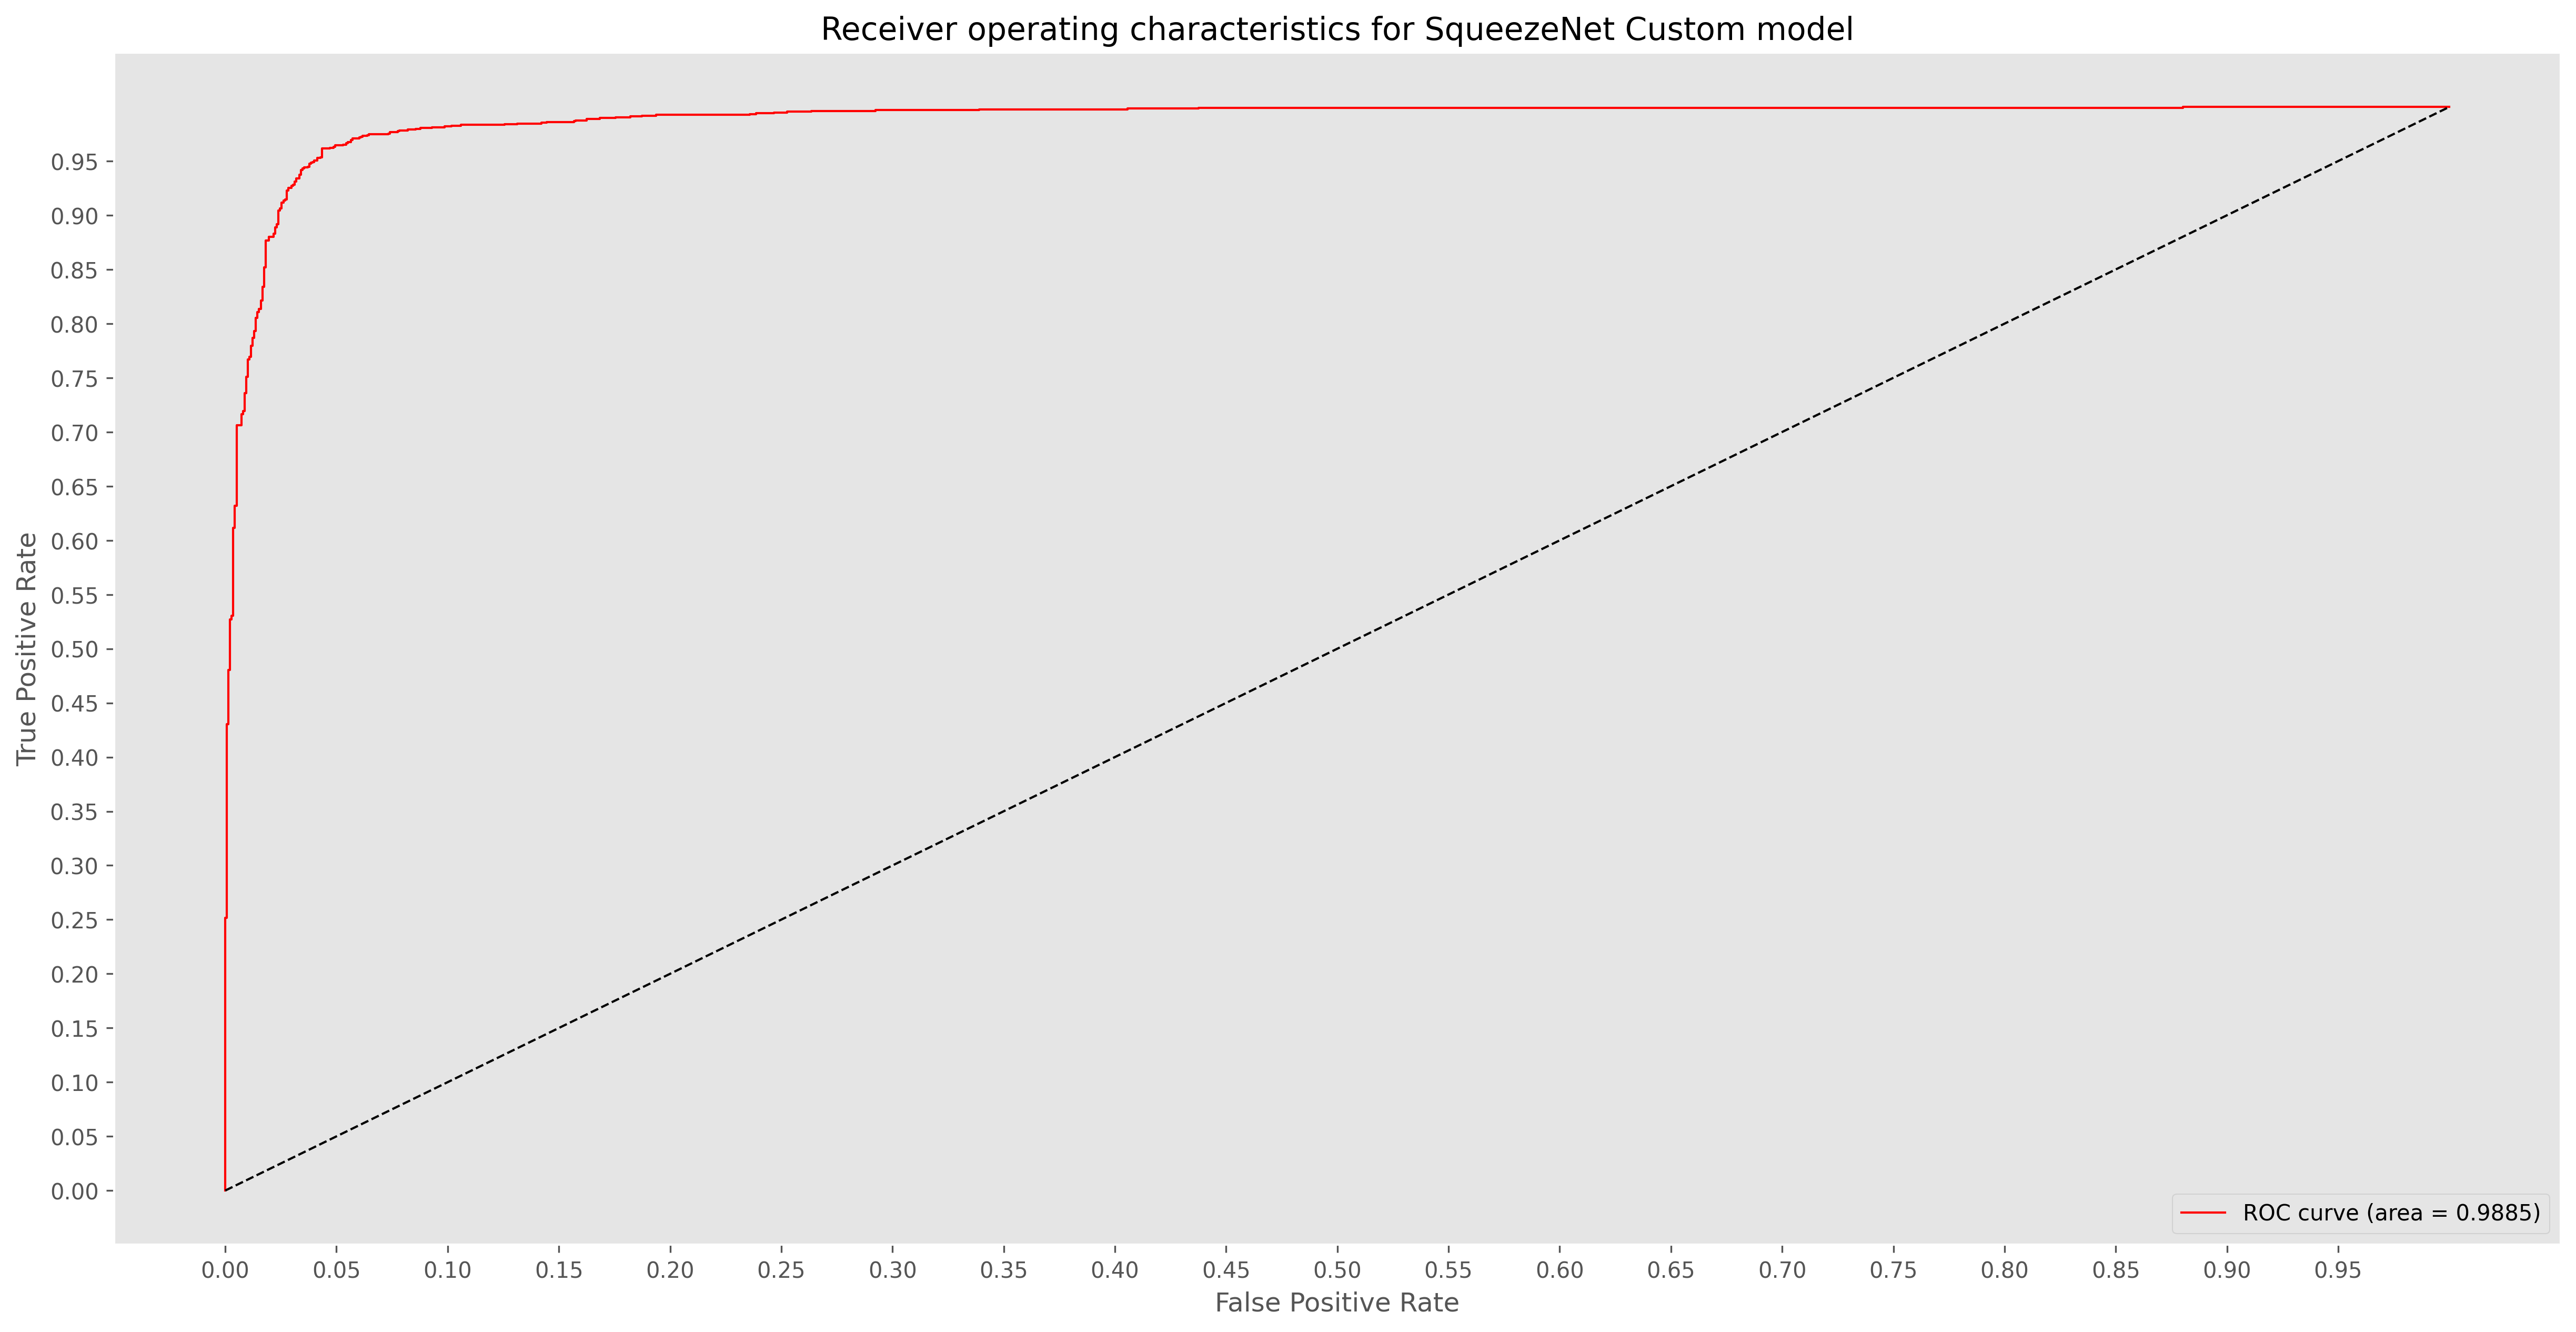

In [122]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, squeeze_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for SqueezeNet Custom model')
plt.legend(loc="lower right")
plt.show()


In [123]:
#Evaluate the model by loading the best weights 
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

#evaluate accuracy
incepres_y_pred = inceptionresnet_custom_model.predict(validation_generator,
                                                                 nb_validation_samples/batch_size, workers=1)
incepres_accuracy = accuracy_score(Y_test,incepres_y_pred.argmax(axis=-1))
print('The accuracy of the InceptionResNetV2 Custom model is: ', incepres_accuracy)

#evaluate mean squared error
incepres_custom_mse = mean_squared_error(Y_test,incepres_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the InceptionResNetv2 Custom model is: ', incepres_custom_mse)

#evaluate mean squared log error
incepres_custom_msle = mean_squared_log_error(Y_test,incepres_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the InceptionResNetv2 Custom model is: ', incepres_custom_msle)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


The accuracy of the InceptionResNetV2 Custom model is:  0.9528301886792453
The Mean Squared Error of the InceptionResNetv2 Custom model is:  0.04716981132075472
The Mean Squared Log Error of the InceptionResNetv2 Custom model is:  0.022662878015009498


                   precision    recall  f1-score   support

class 0(abnormal)     0.9685    0.9361    0.9520      1378
  class 1(normal)     0.9382    0.9695    0.9536      1378

         accuracy                         0.9528      2756
        macro avg     0.9533    0.9528    0.9528      2756
     weighted avg     0.9533    0.9528    0.9528      2756

Confusion matrix, without normalization
[[1290   88]
 [  42 1336]]


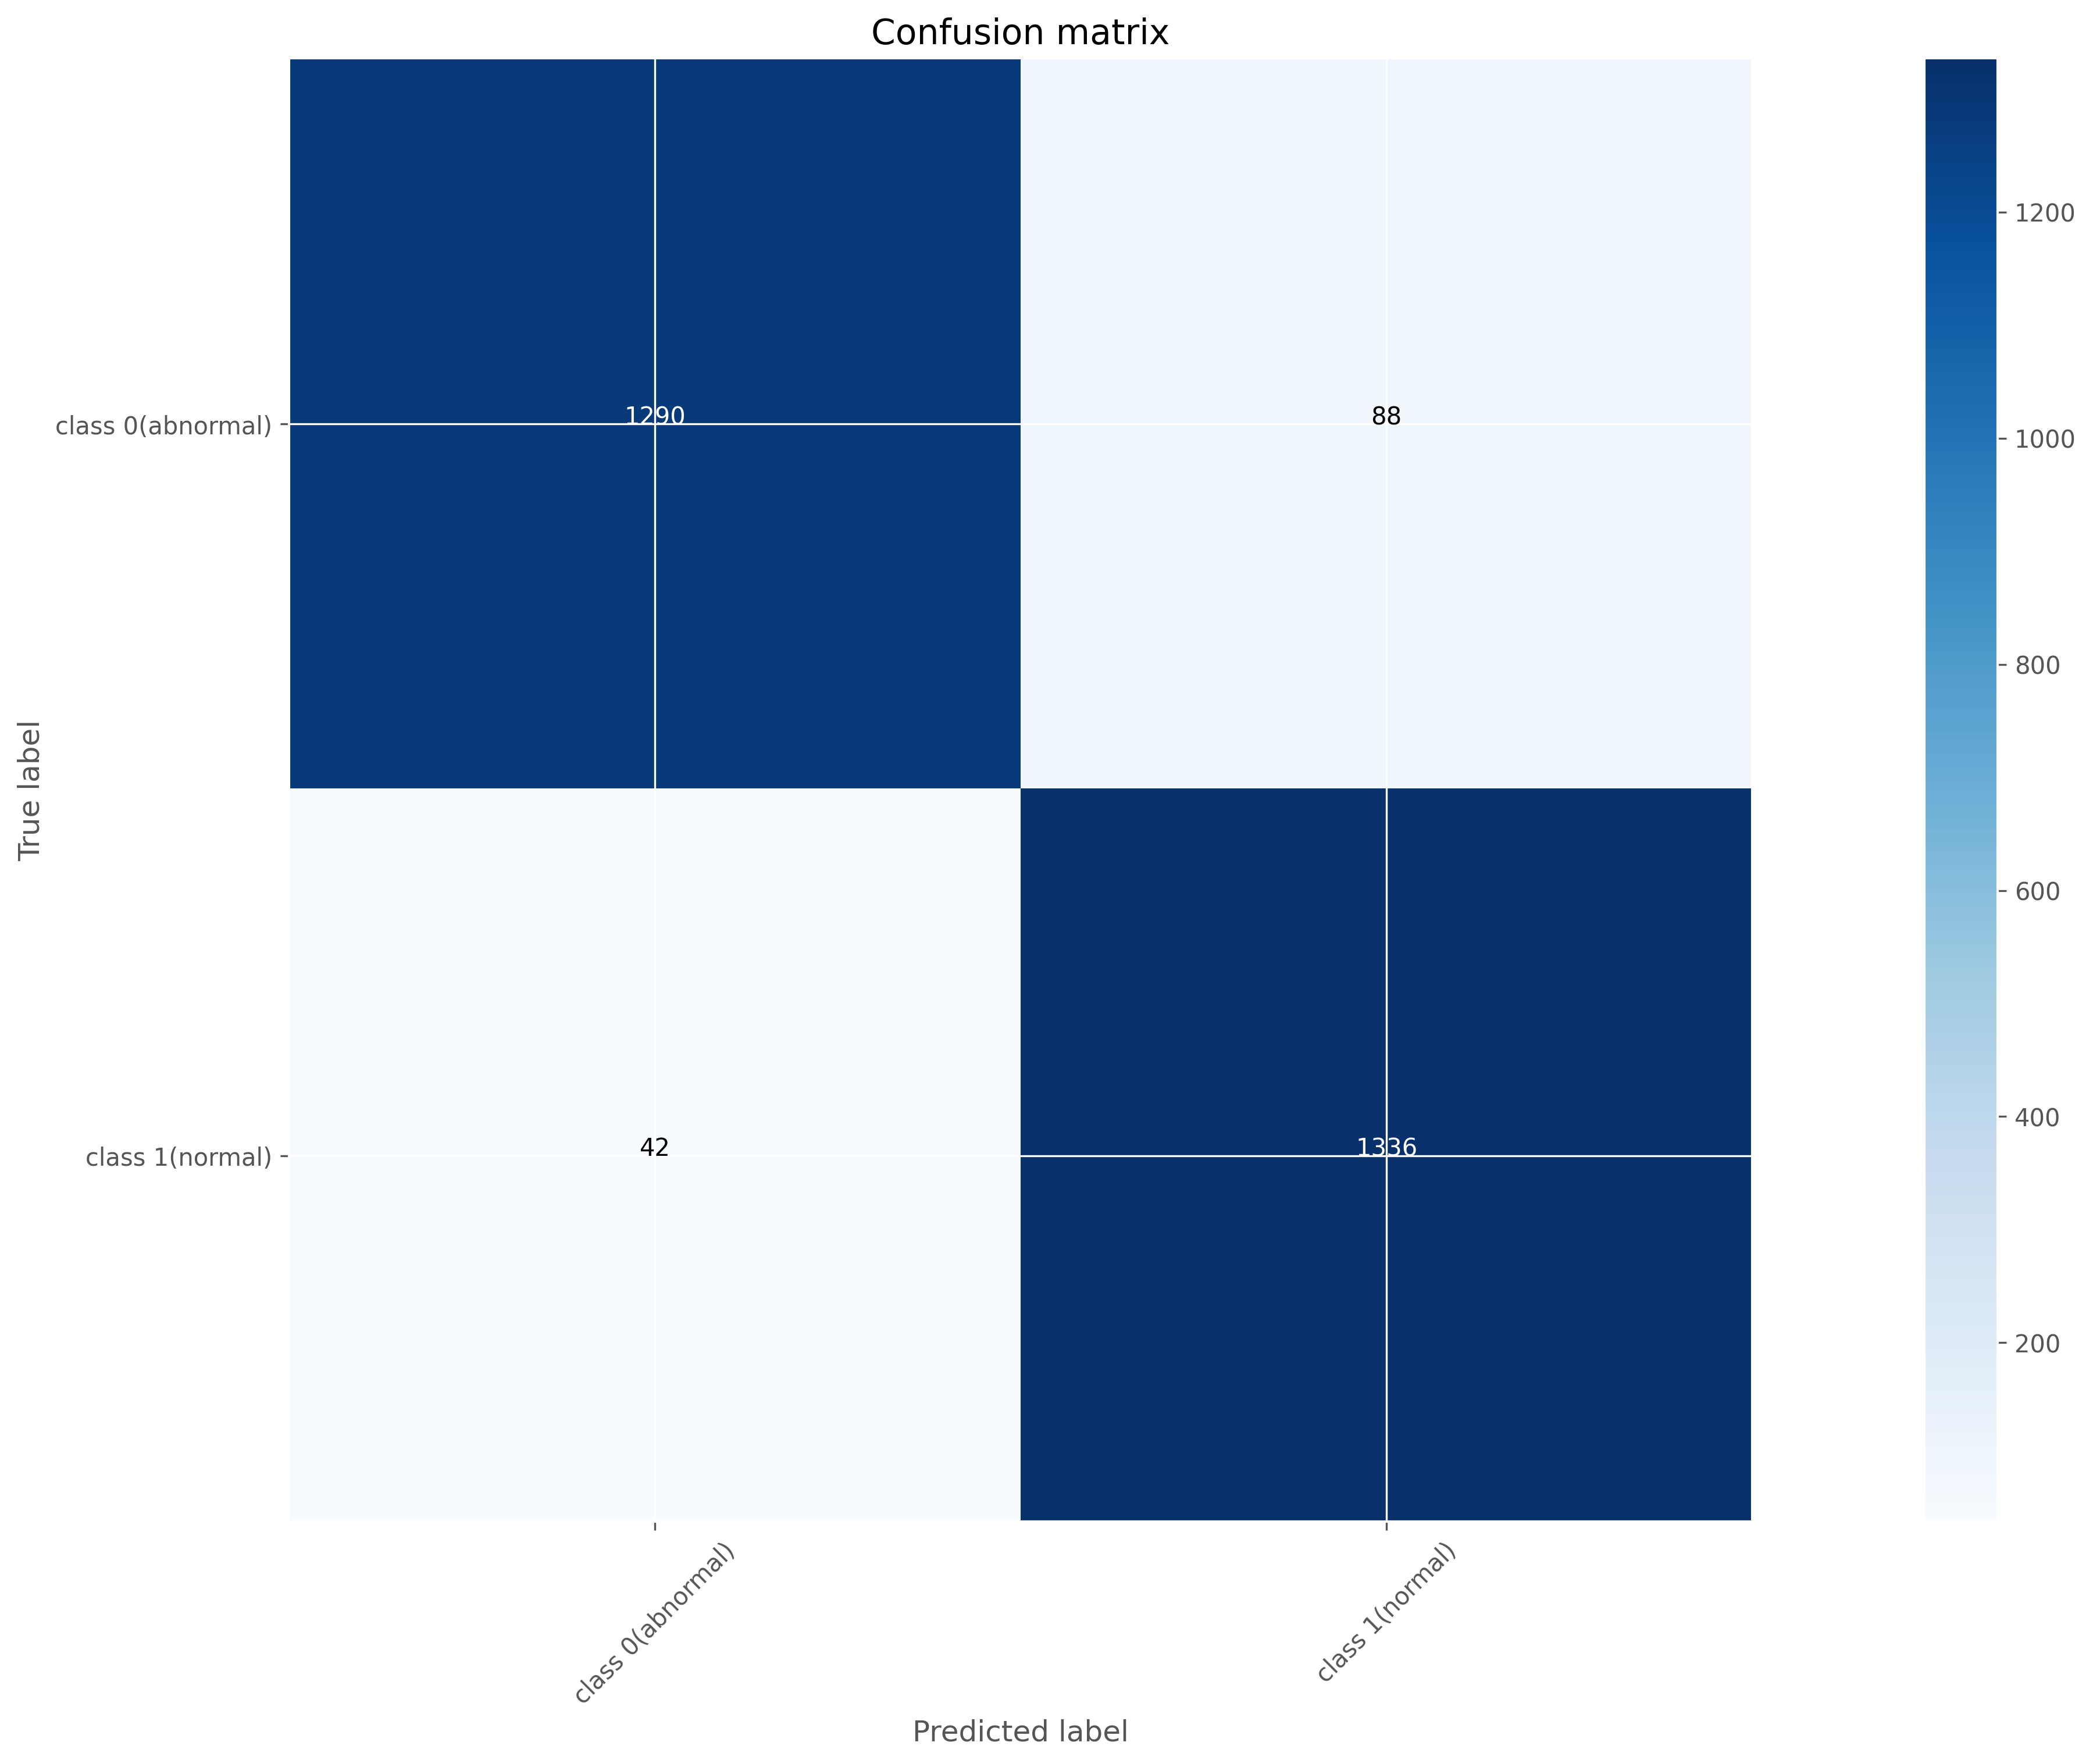

In [124]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,incepres_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,incepres_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


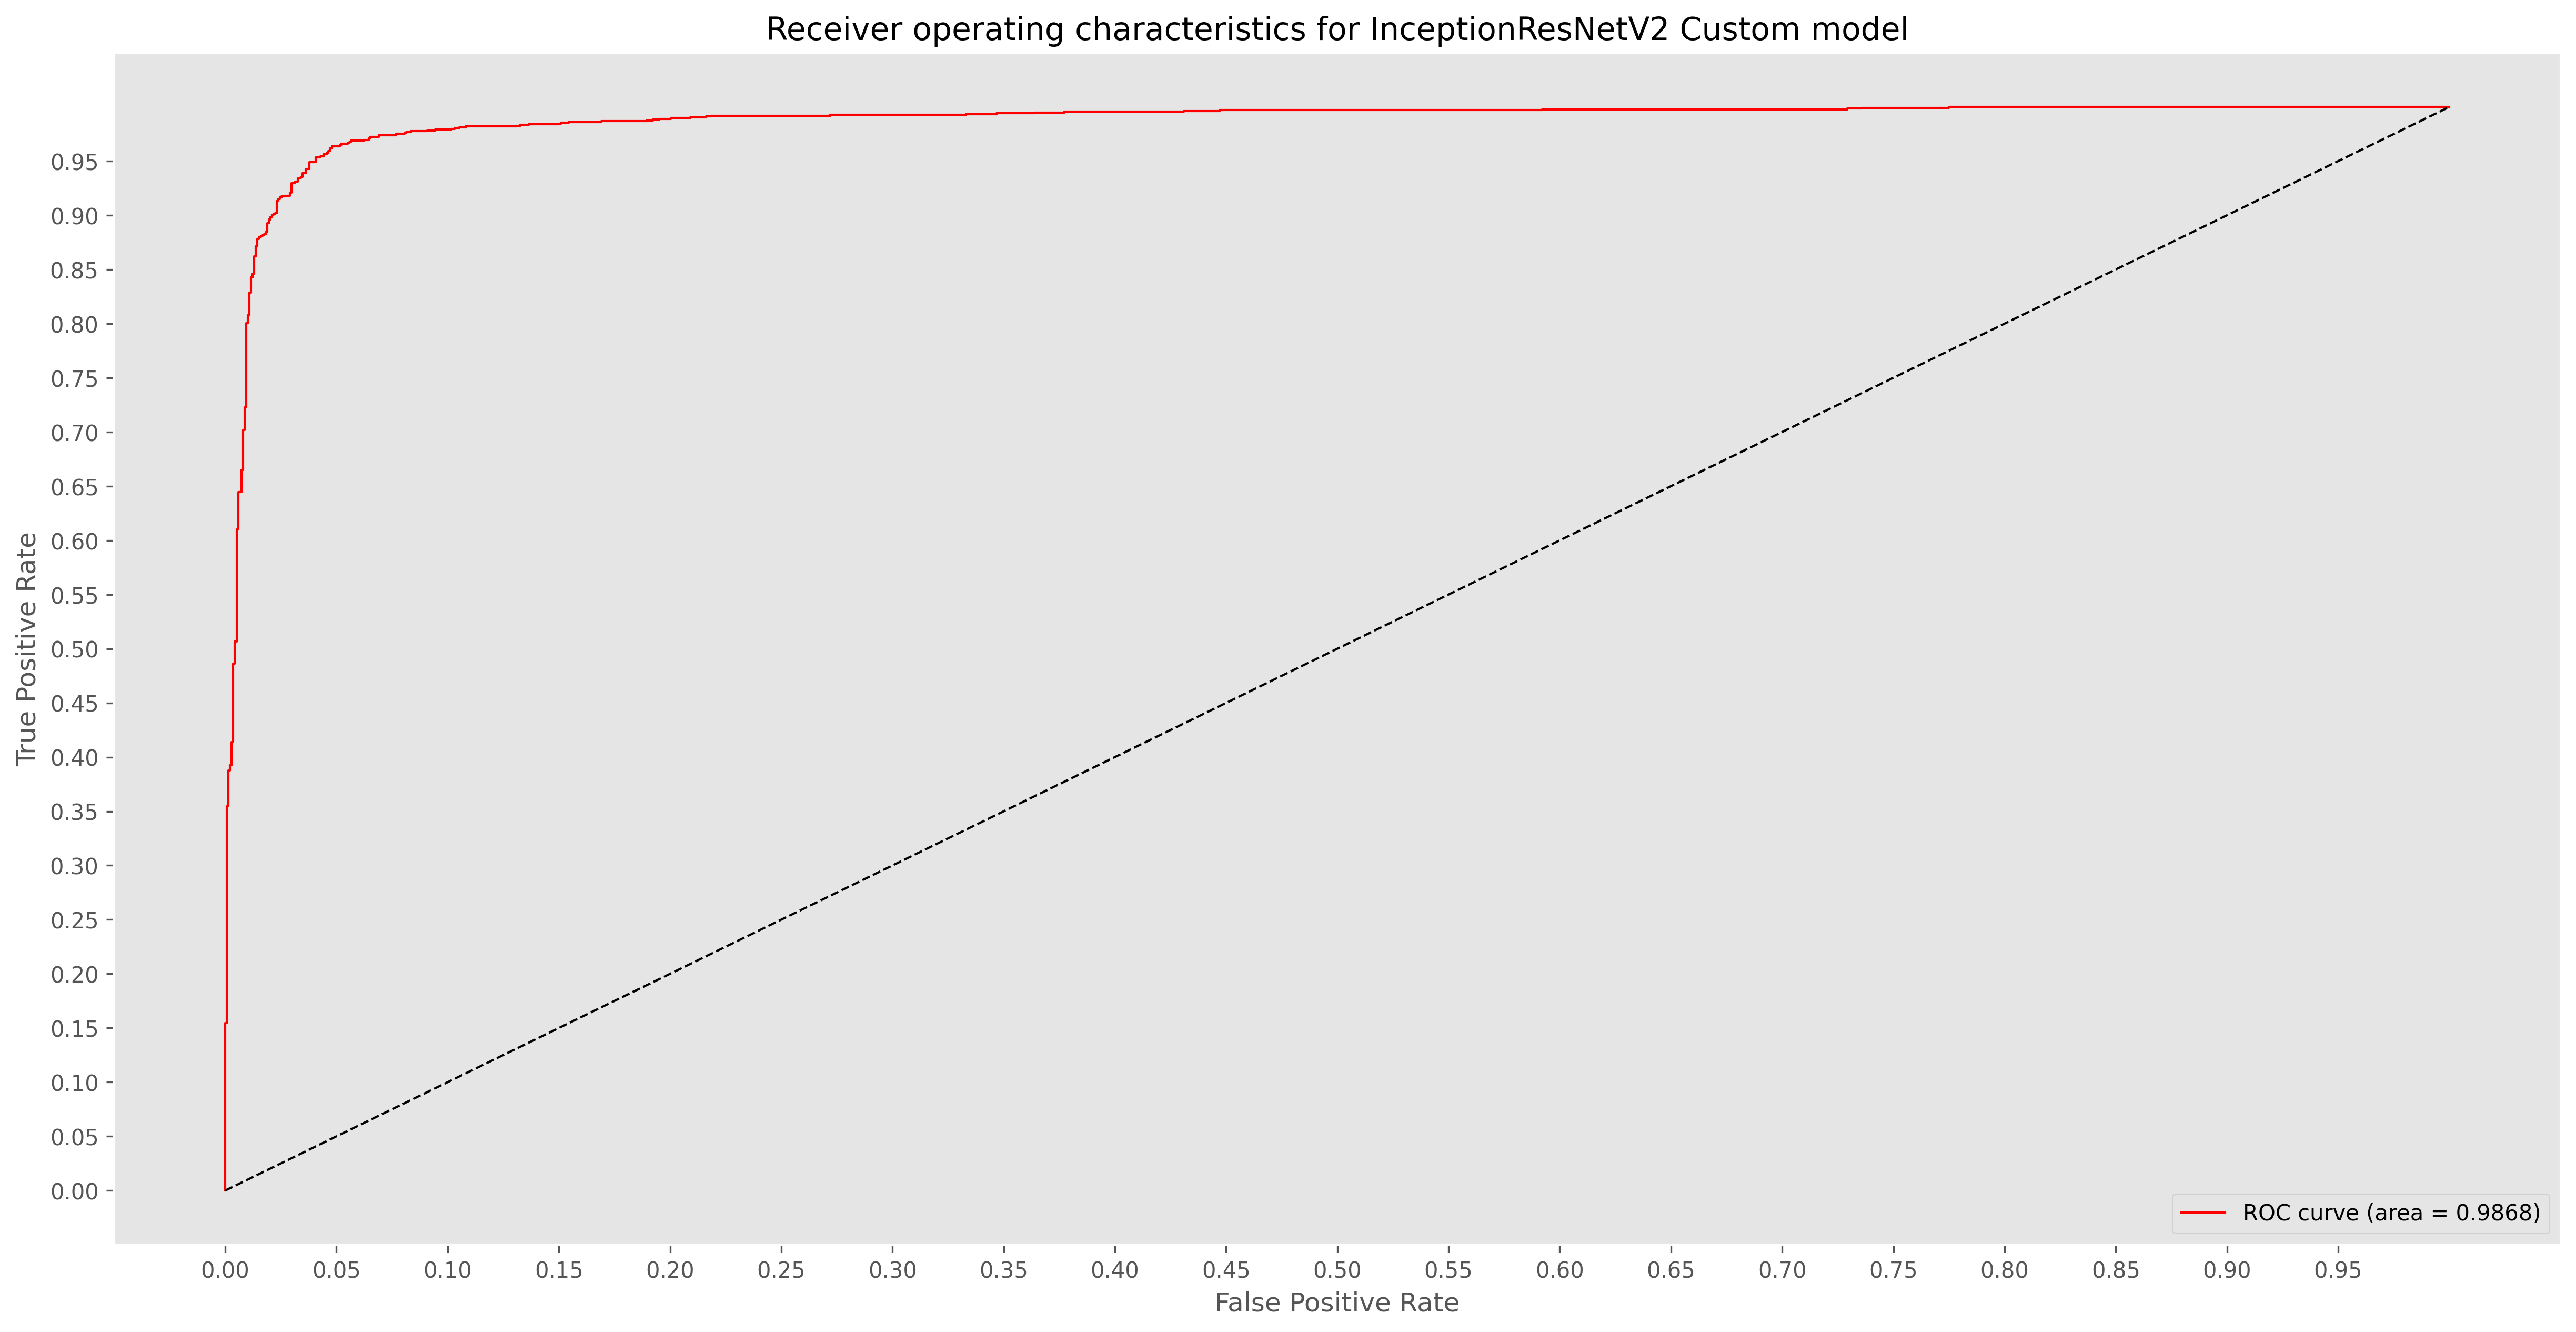

In [125]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, incepres_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for InceptionResNetV2 Custom model')
plt.legend(loc="lower right")
plt.show()


In [126]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [127]:
#%% modify squeezenet layer name to avoid common names while forming ensemble

squeeze_custom_model.get_layer(name='conv1').name='conv1SQUEEZE'

AttributeError: Can't set the attribute "name", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

In [128]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

Ensemble model definition is very straightforward. It uses the same input layer thas is shared between all previous models. 
In the top layer, the ensemble computes the average of three models' outputs (predictions) by using Average() layer. The ensemble is expected to have a lower error rate than any single model and better accuracy.

In [129]:
def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(model_input, y, name='ensemble')
    return model

#istantitate the ensemble model and report the summary
ensemble_model = ensemble(models,model_input)

#save the ensemble model with the architecture and the weights together
ensemble_model.save('weights/ensemblemodel.h5')
print('The Ensemble Model is Saved')

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved


In [132]:
#%% load the ensemble model and make predictions on the test data
ensemble_model=load_model('weights/ensemblemodel.h5')
ensemble_model.summary()
#plot_model(ensemble_model, to_file='ensemble_model.png',show_shapes=True, show_layer_names=False)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1218 (Conv2D)            (None, 49, 49, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1227 (Batch (None, 49, 49, 32)   96          conv2d_1218[0][0]                
__________________________________________________________________________________________________
activation_1218 (Activation)    (None, 49, 49, 32)   0           batch_normalization_1227[0][0]   
___________________________________________________________________________________________

batch_normalization_1378 (Batch (None, 4, 4, 192)    576         conv2d_1369[0][0]                
__________________________________________________________________________________________________
activation_1366 (Activation)    (None, 4, 4, 192)    0           batch_normalization_1375[0][0]   
__________________________________________________________________________________________________
activation_1369 (Activation)    (None, 4, 4, 192)    0           batch_normalization_1378[0][0]   
__________________________________________________________________________________________________
block17_19_mixed (Concatenate)  (None, 4, 4, 384)    0           activation_1366[0][0]            
                                                                 activation_1369[0][0]            
__________________________________________________________________________________________________
block17_19_conv (Conv2D)        (None, 4, 4, 1088)   418880      block17_19_mixed[0][0]           
__________

NameError: name 'plot_model' is not defined

In [134]:
#evaluate accuracy
ensem_y_pred = ensemble_model.predict(validation_generator,
                                                nb_validation_samples/batch_size, workers=1)
ensemble_model_accuracy = accuracy_score(Y_test,ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Ensemble model is: ', ensemble_model_accuracy)

#evaluate mean squared error
ensemble_model_custom_mse = mean_squared_error(Y_test,ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Ensemble model is: ', ensemble_model_custom_mse)

#evaluate mean squared log error
ensemble_model_custom_msle = mean_squared_log_error(Y_test,ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Ensemble model is: ', ensemble_model_custom_msle)

The accuracy of the Ensemble model is:  0.9593613933236574
The Mean Squared Error of the Ensemble model is:  0.040638606676342524
The Mean Squared Log Error of the Ensemble model is:  0.019524941059085105


                   precision    recall  f1-score   support

class 0(abnormal)     0.9724    0.9456    0.9588      1378
  class 1(normal)     0.9470    0.9731    0.9599      1378

         accuracy                         0.9594      2756
        macro avg     0.9597    0.9594    0.9594      2756
     weighted avg     0.9597    0.9594    0.9594      2756

Confusion matrix, without normalization
[[1303   75]
 [  37 1341]]


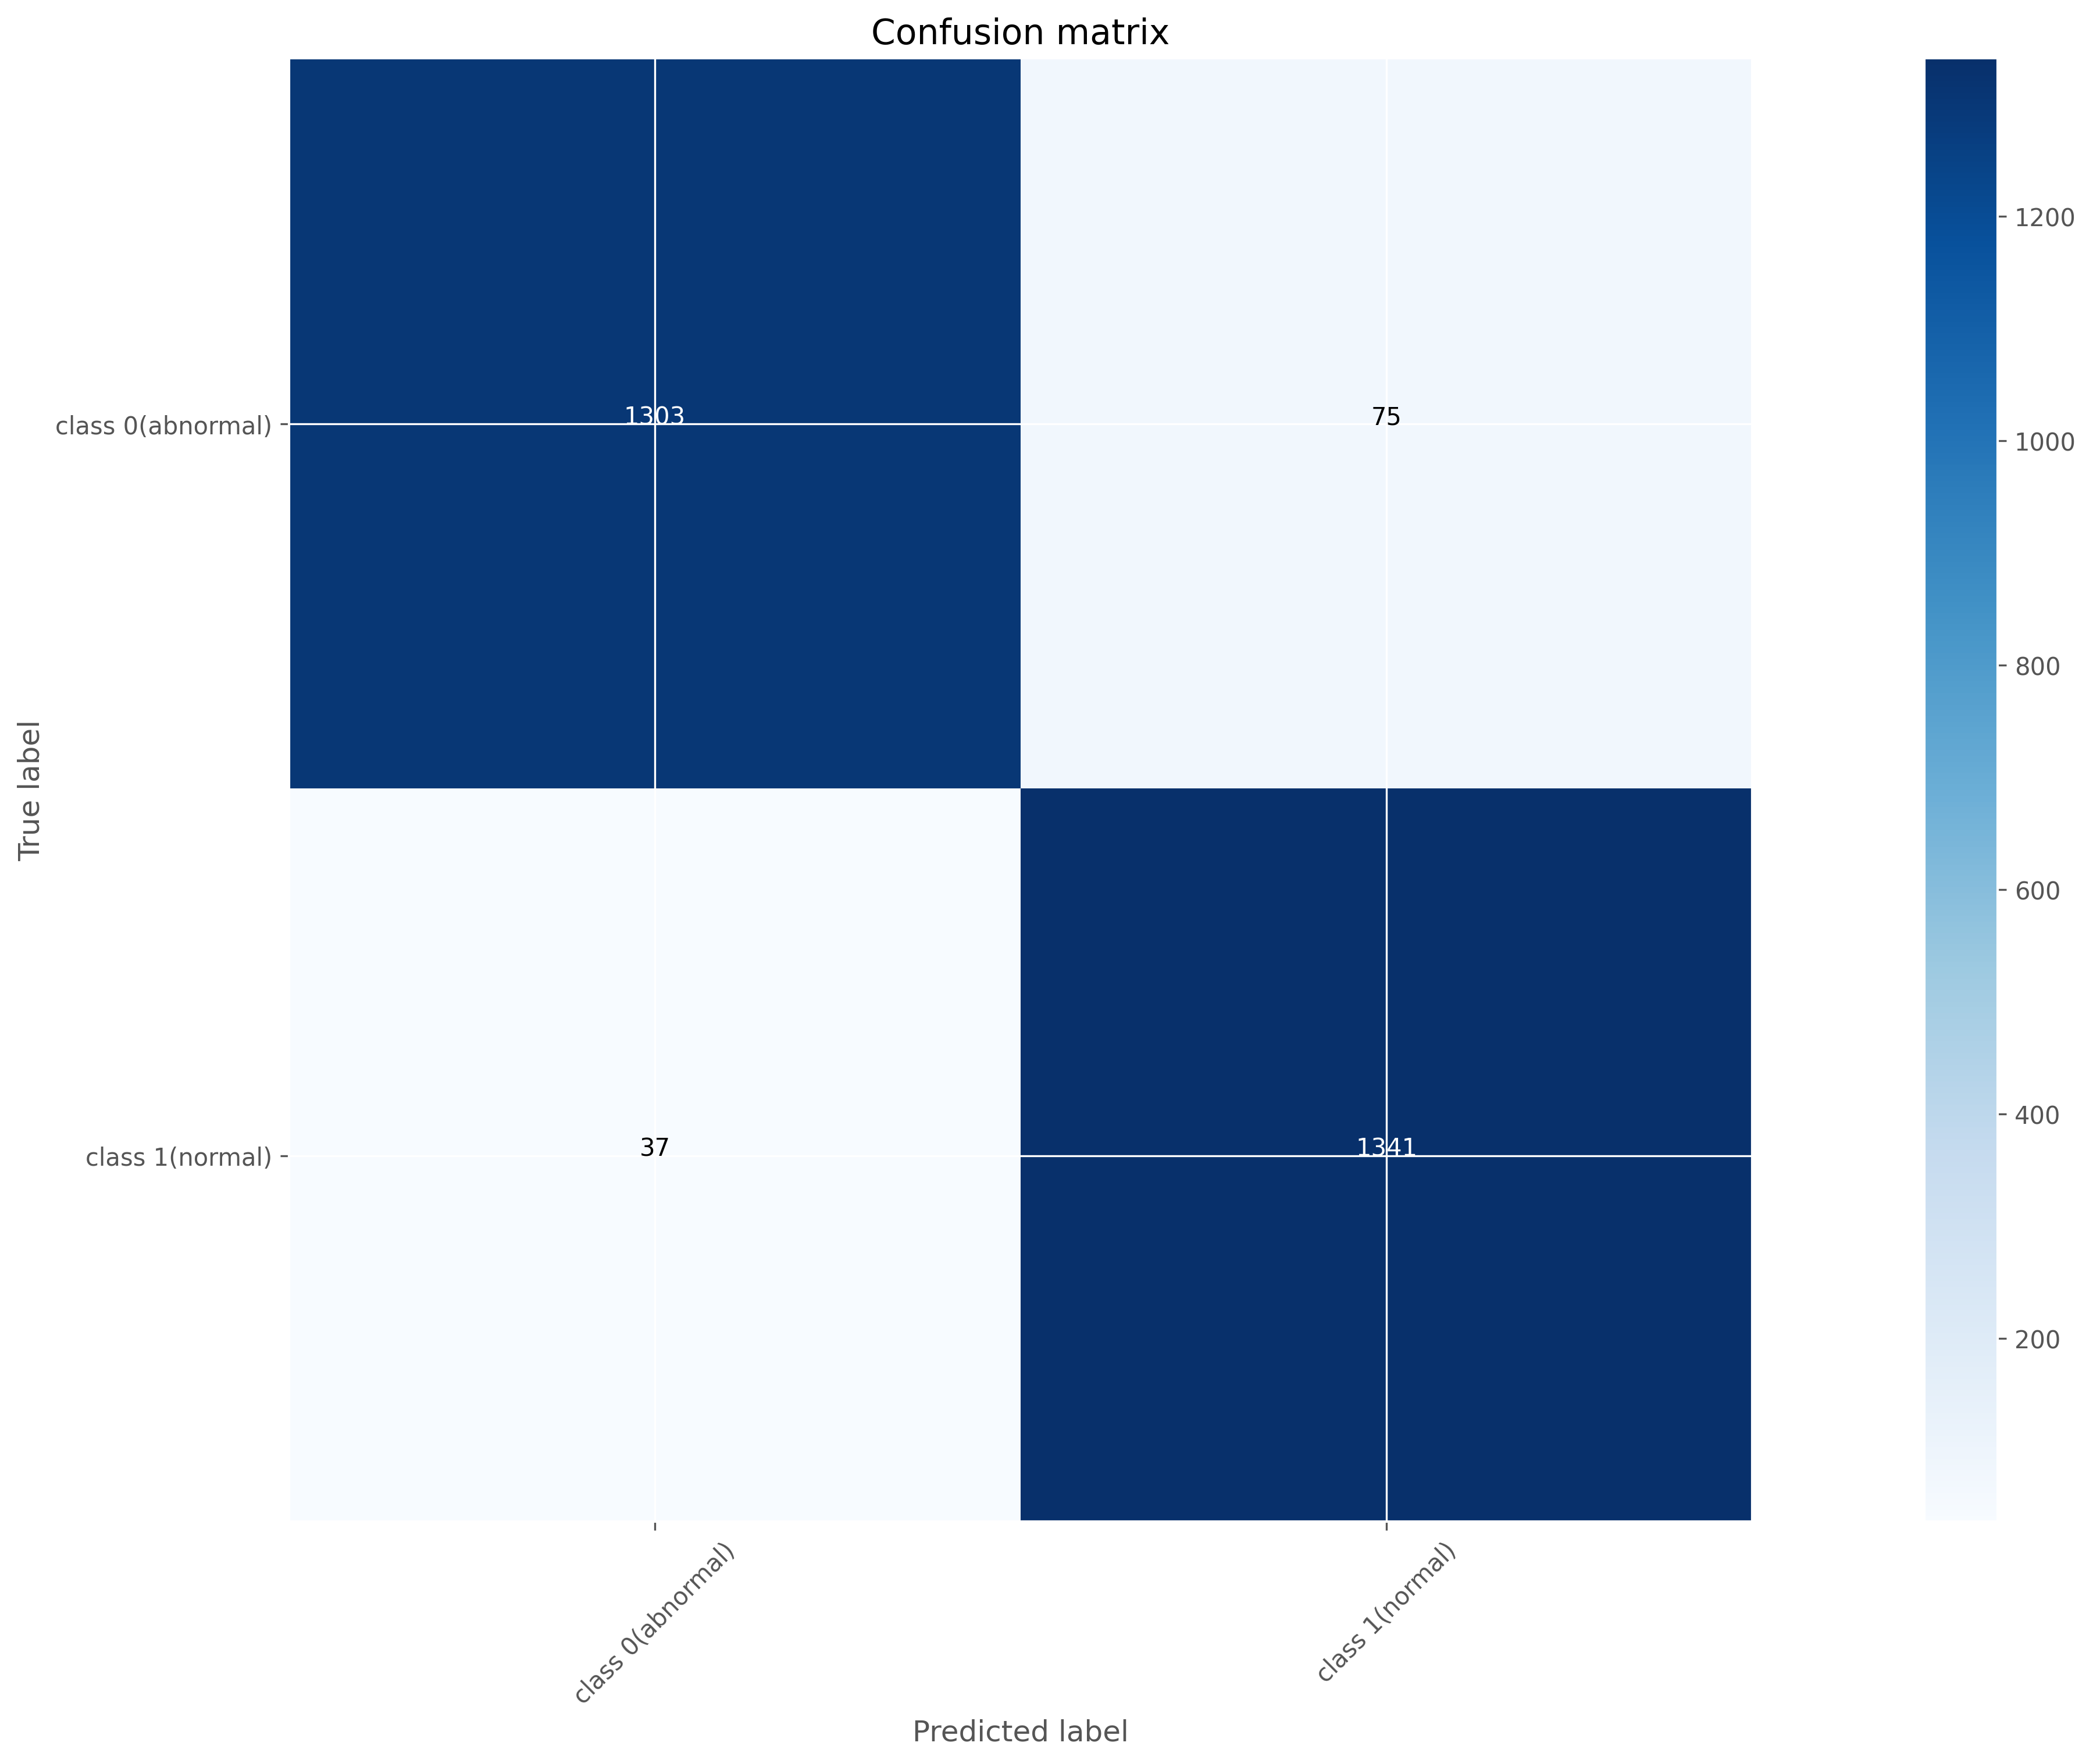

In [135]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


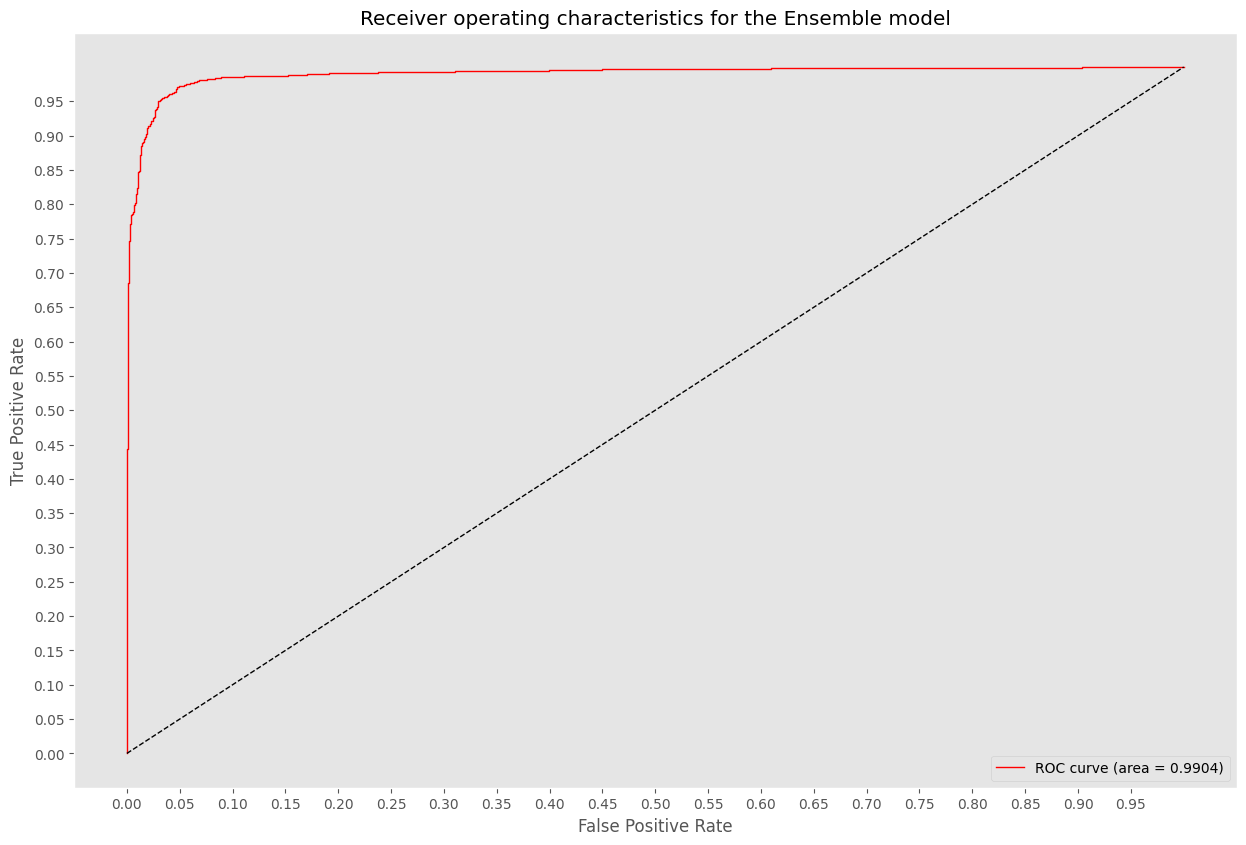

In [136]:
#%% compute the ROC-AUC values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for the Ensemble model')
plt.legend(loc="lower right")
plt.show()


In [137]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>]
The Ensemble Model is Saved


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


The accuracy of the Pair A Ensemble model is:  0.9517416545718432
The Mean Squared Error of the Pair A Ensemble model is:  0.04825834542815675
The Mean Squared Log Error of the Pair A Ensemble model is:  0.023185867507663566
                   precision    recall  f1-score   support

class 0(abnormal)     0.9621    0.9405    0.9512      1378
  class 1(normal)     0.9418    0.9630    0.9523      1378

         accuracy                         0.9517      2756
        macro avg     0.9520    0.9517    0.9517      2756
     weighted avg     0.9520    0.9517    0.9517      2756

Confusion matrix, without normalization
[[1296   82]
 [  51 1327]]


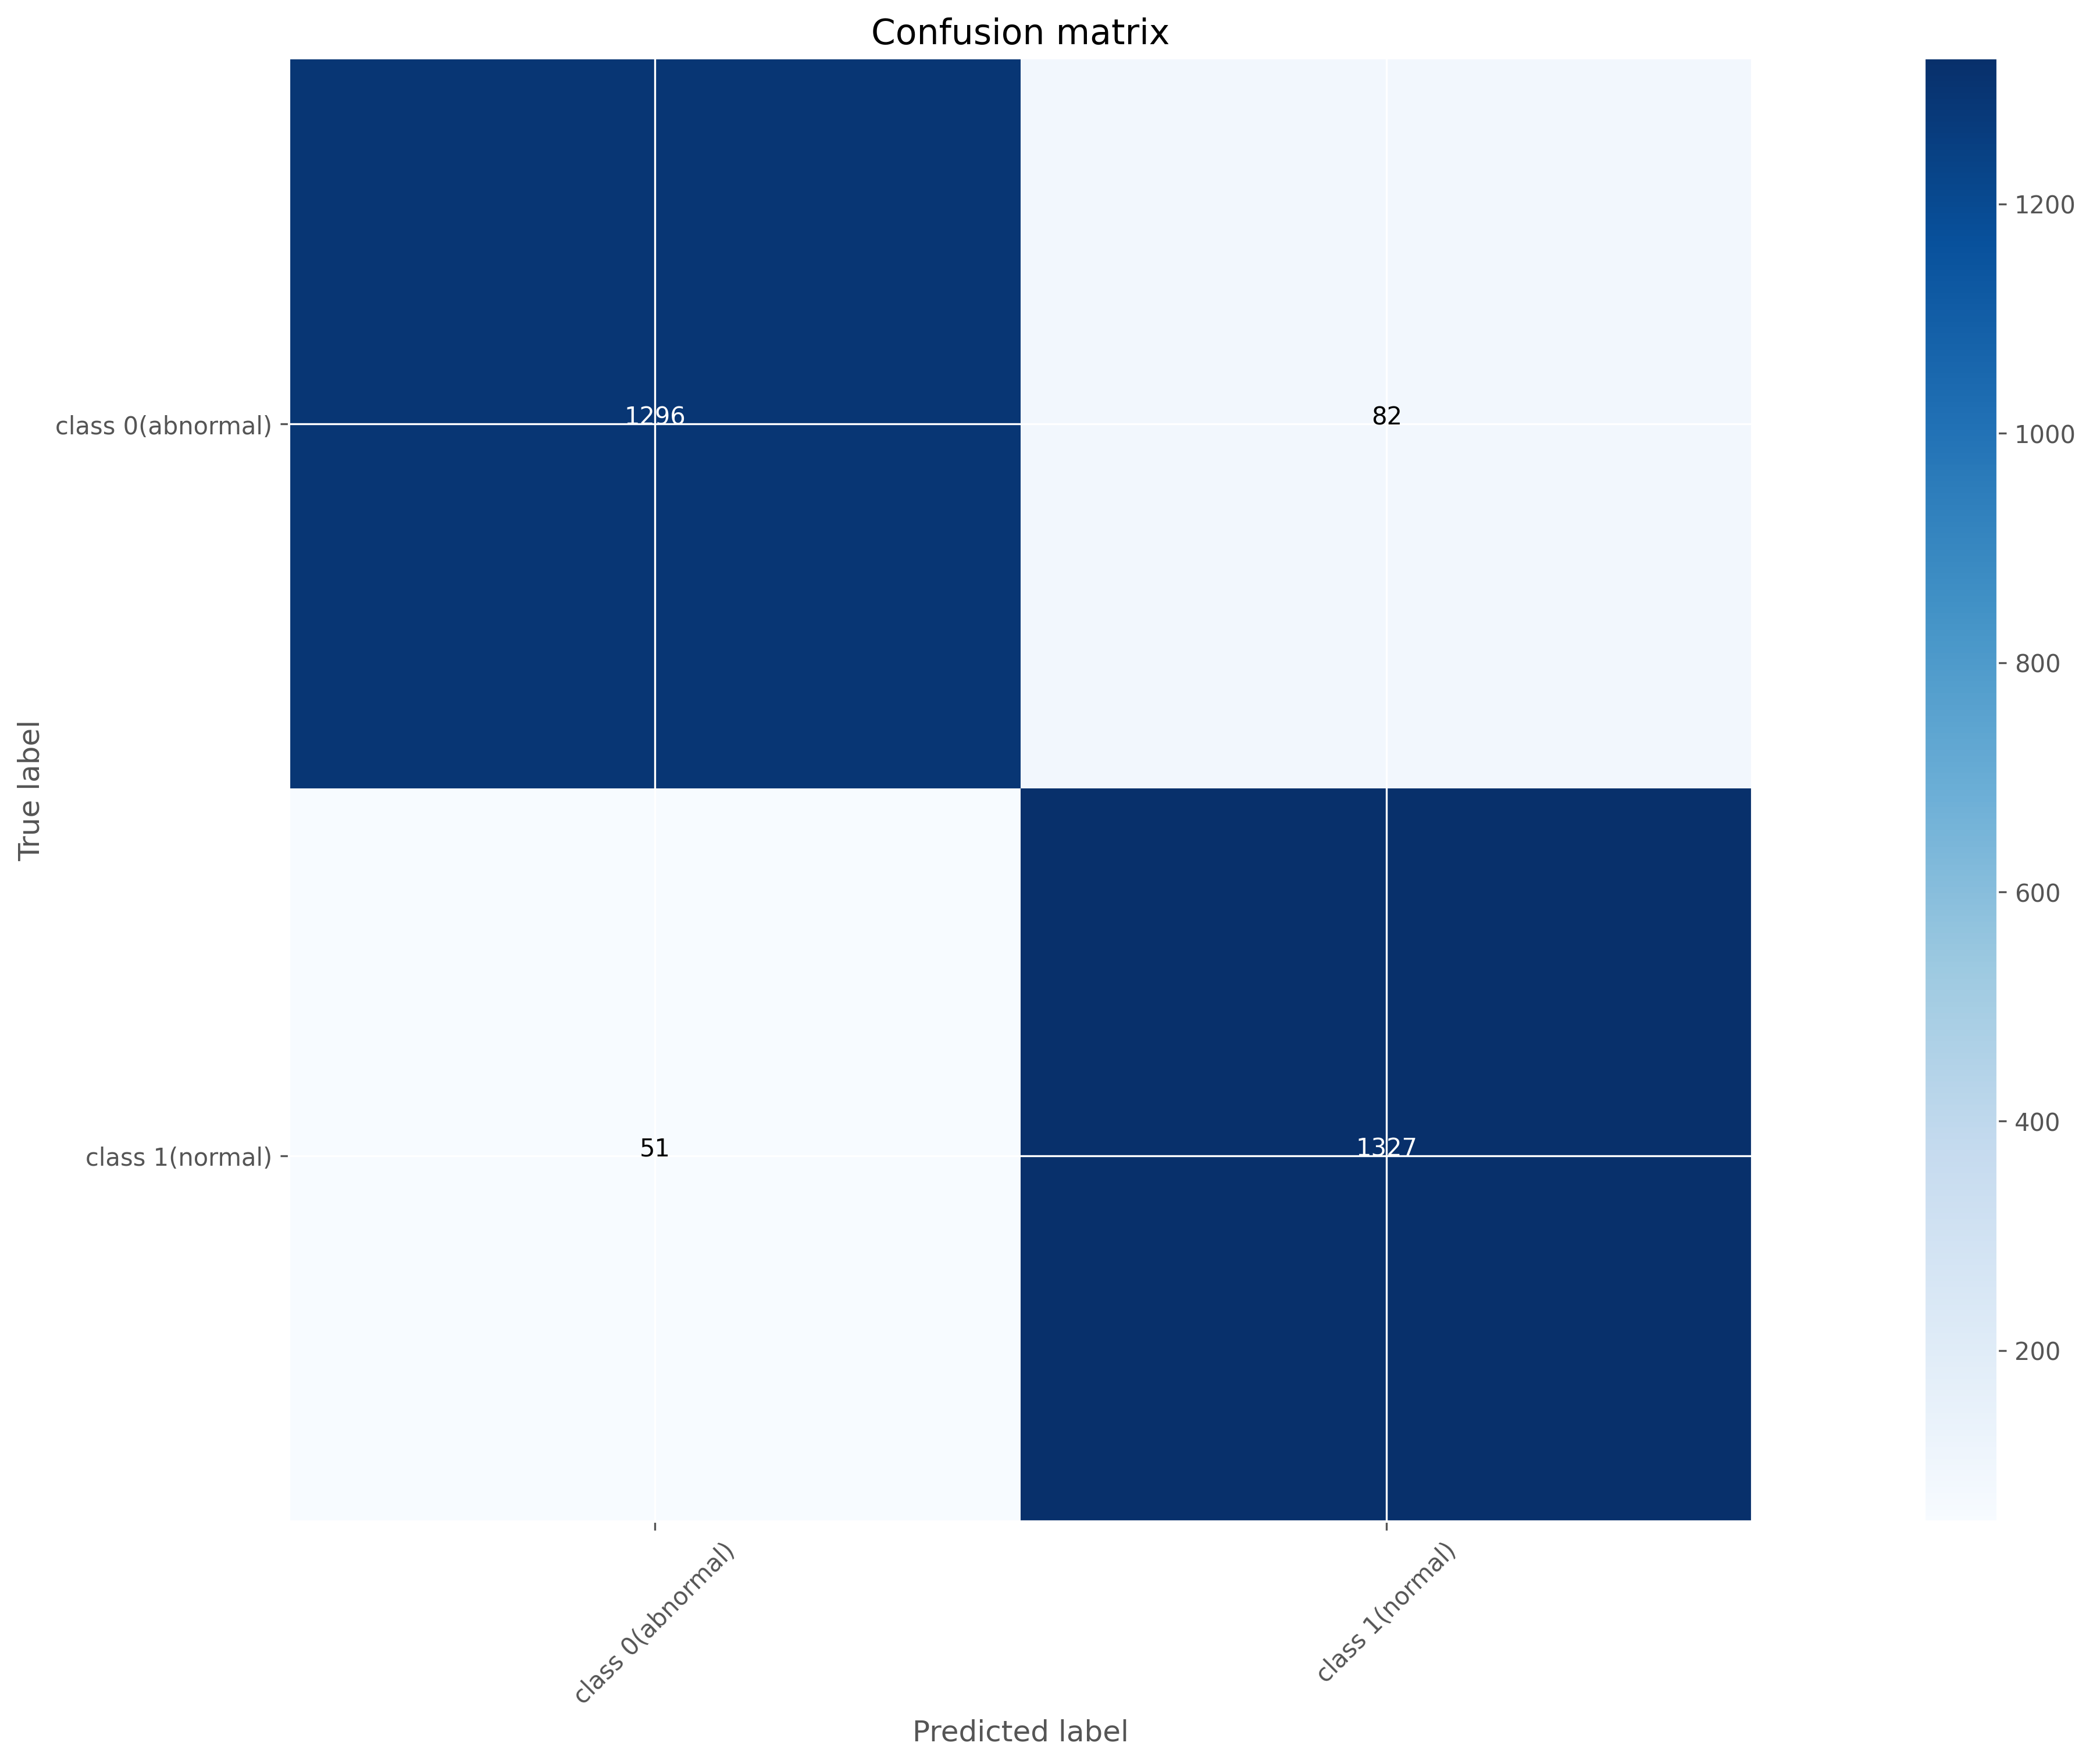

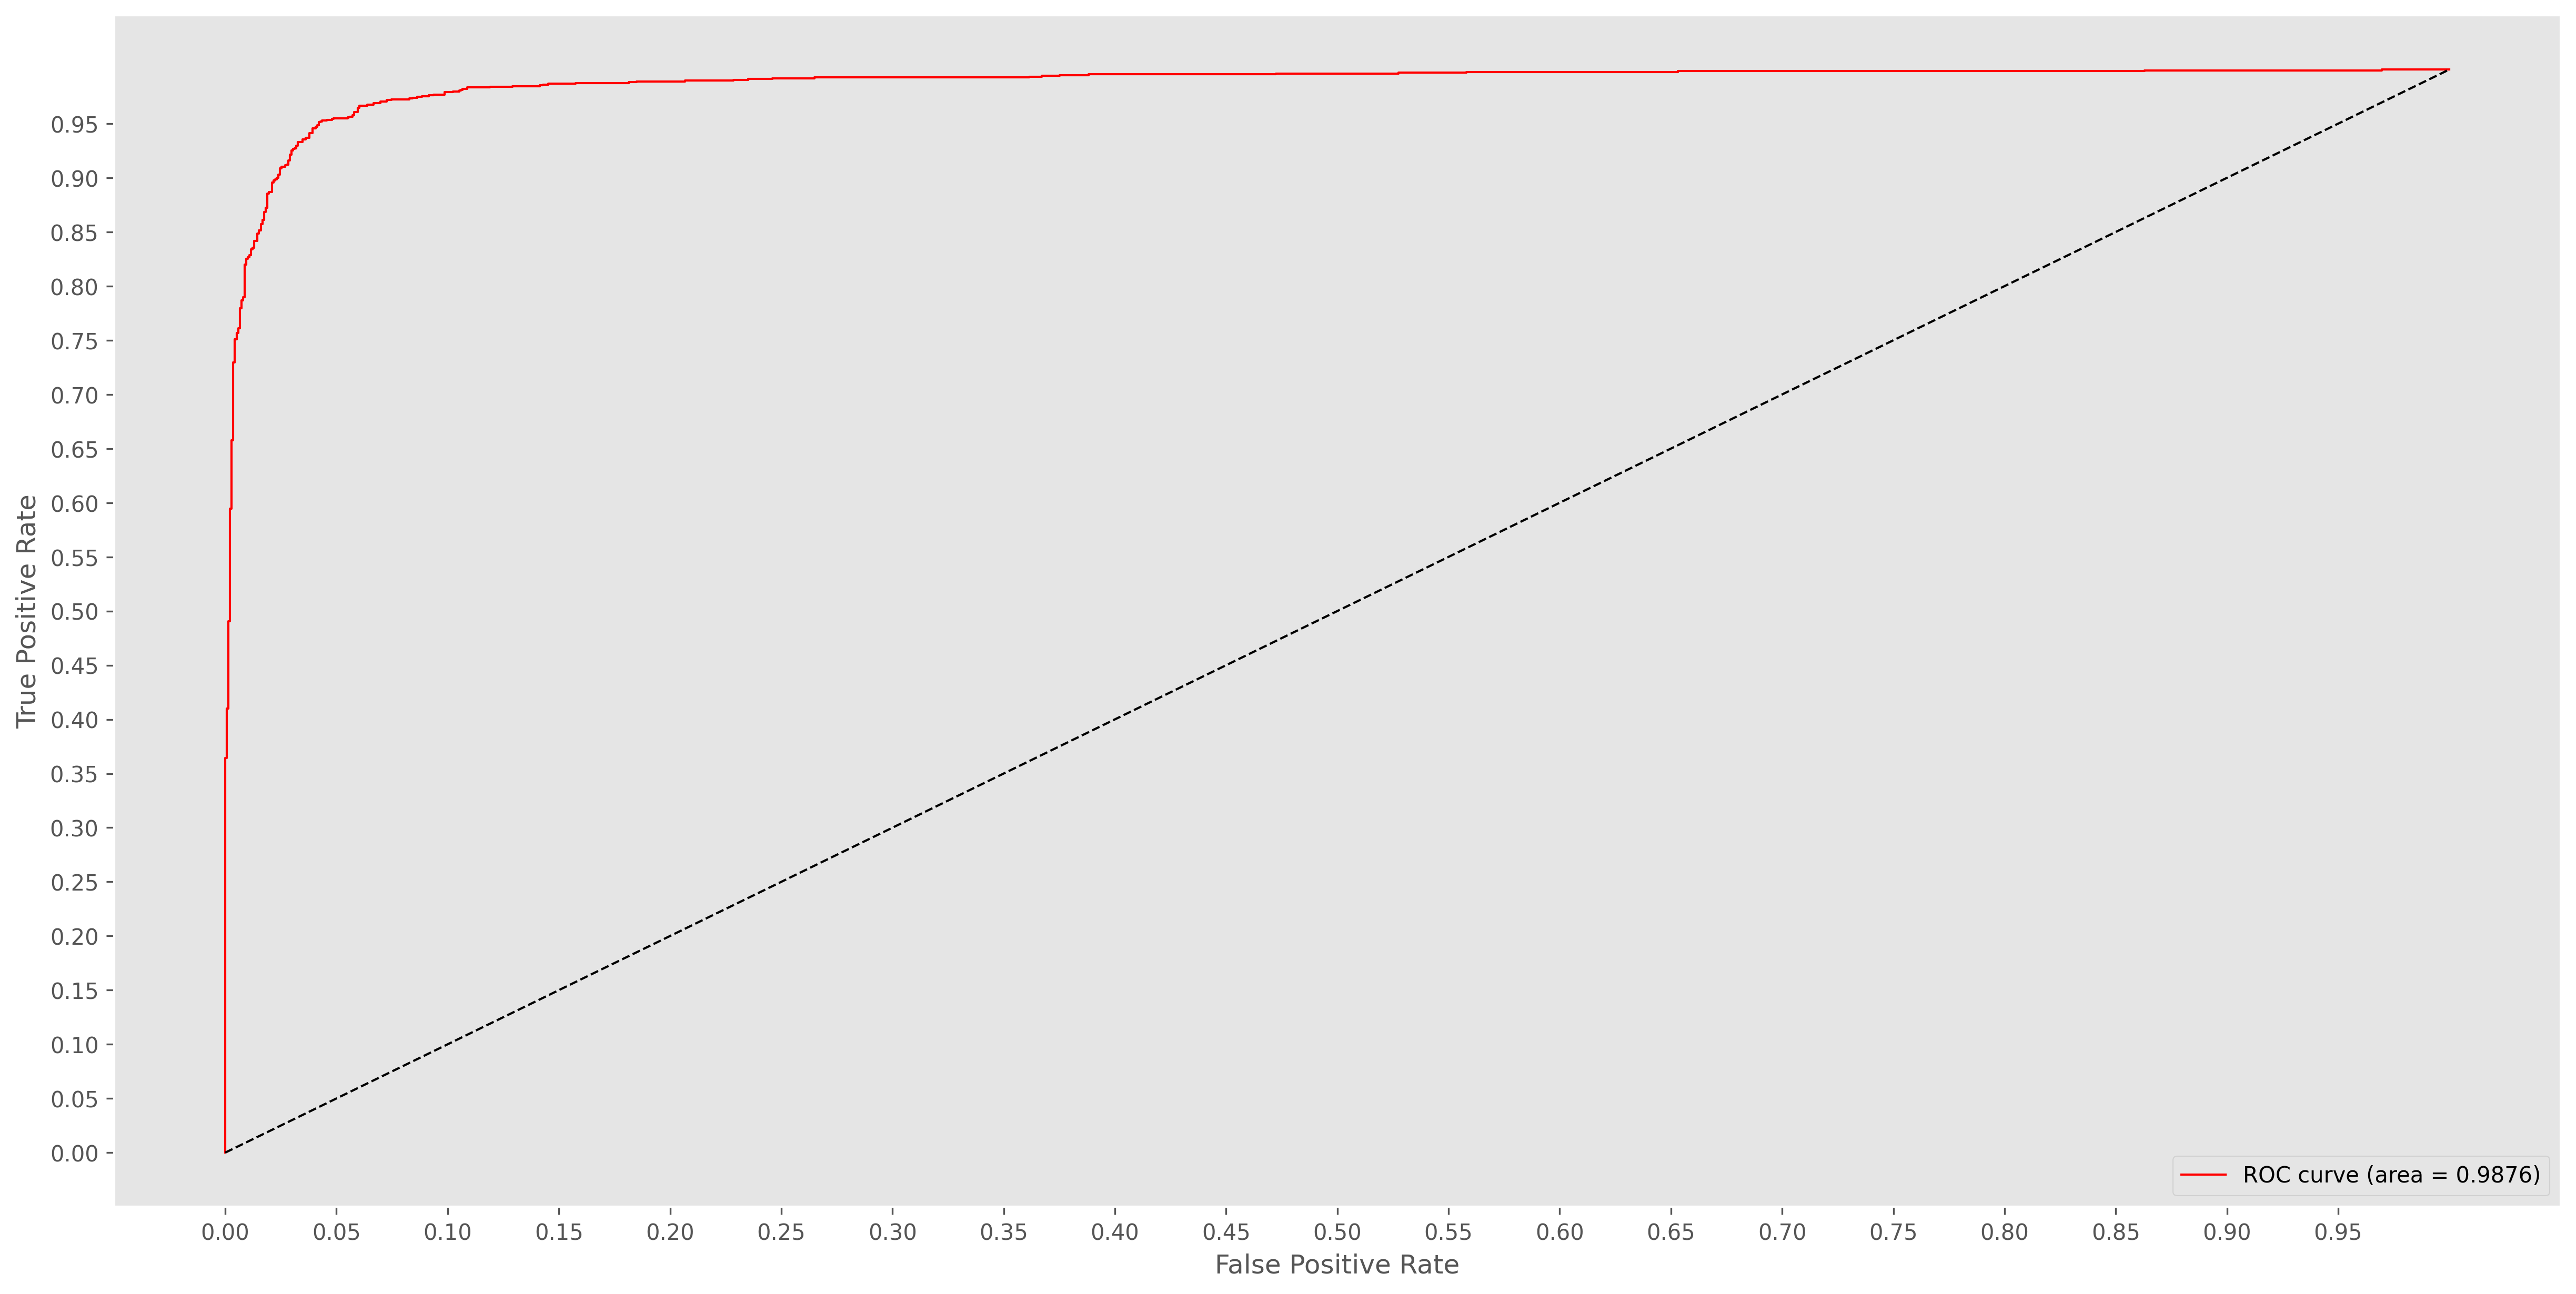

In [138]:
#%% evaluate the performance of these paired ensembles

pair_A_ensemble_model = ensemble(pair_A, model_input)
pair_A_ensemble_model.save('weights/ensemblemodel_pairA.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
A_ensem_y_pred = pair_A_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
A_ensemble_model_accuracy = accuracy_score(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair A Ensemble model is: ', A_ensemble_model_accuracy)

#evaluate mean squared error
A_ensemble_model_custom_mse = mean_squared_error(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_mse)

#evaluate mean squared log error
A_ensemble_model_custom_msle = mean_squared_log_error(Y_test,A_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,A_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,A_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>]
The Ensemble Model is Saved
The accuracy of the Pair B Ensemble model is:  0.931422351233672
The Mean Squared Error of the Pair B Ensemble model is:  0.068577648766328
The Mean Squared Log Error of the Pair B Ensemble model is:  0.03294833803720612
                   precision    recall  f1-score   support

class 0(abnormal)     0.9853    0.8759    0.9274      1378
  class 1(normal)     0.8883    0.9869    0.9350      1378

         accuracy                         0.9314      2756
        macro avg     0.9368    0.9314    0.9312      2756
     weighted avg     0.9368    0.9314    0.9312      2756

Confusion matrix, without normalization
[[1207  171]
 [  18 1360]]


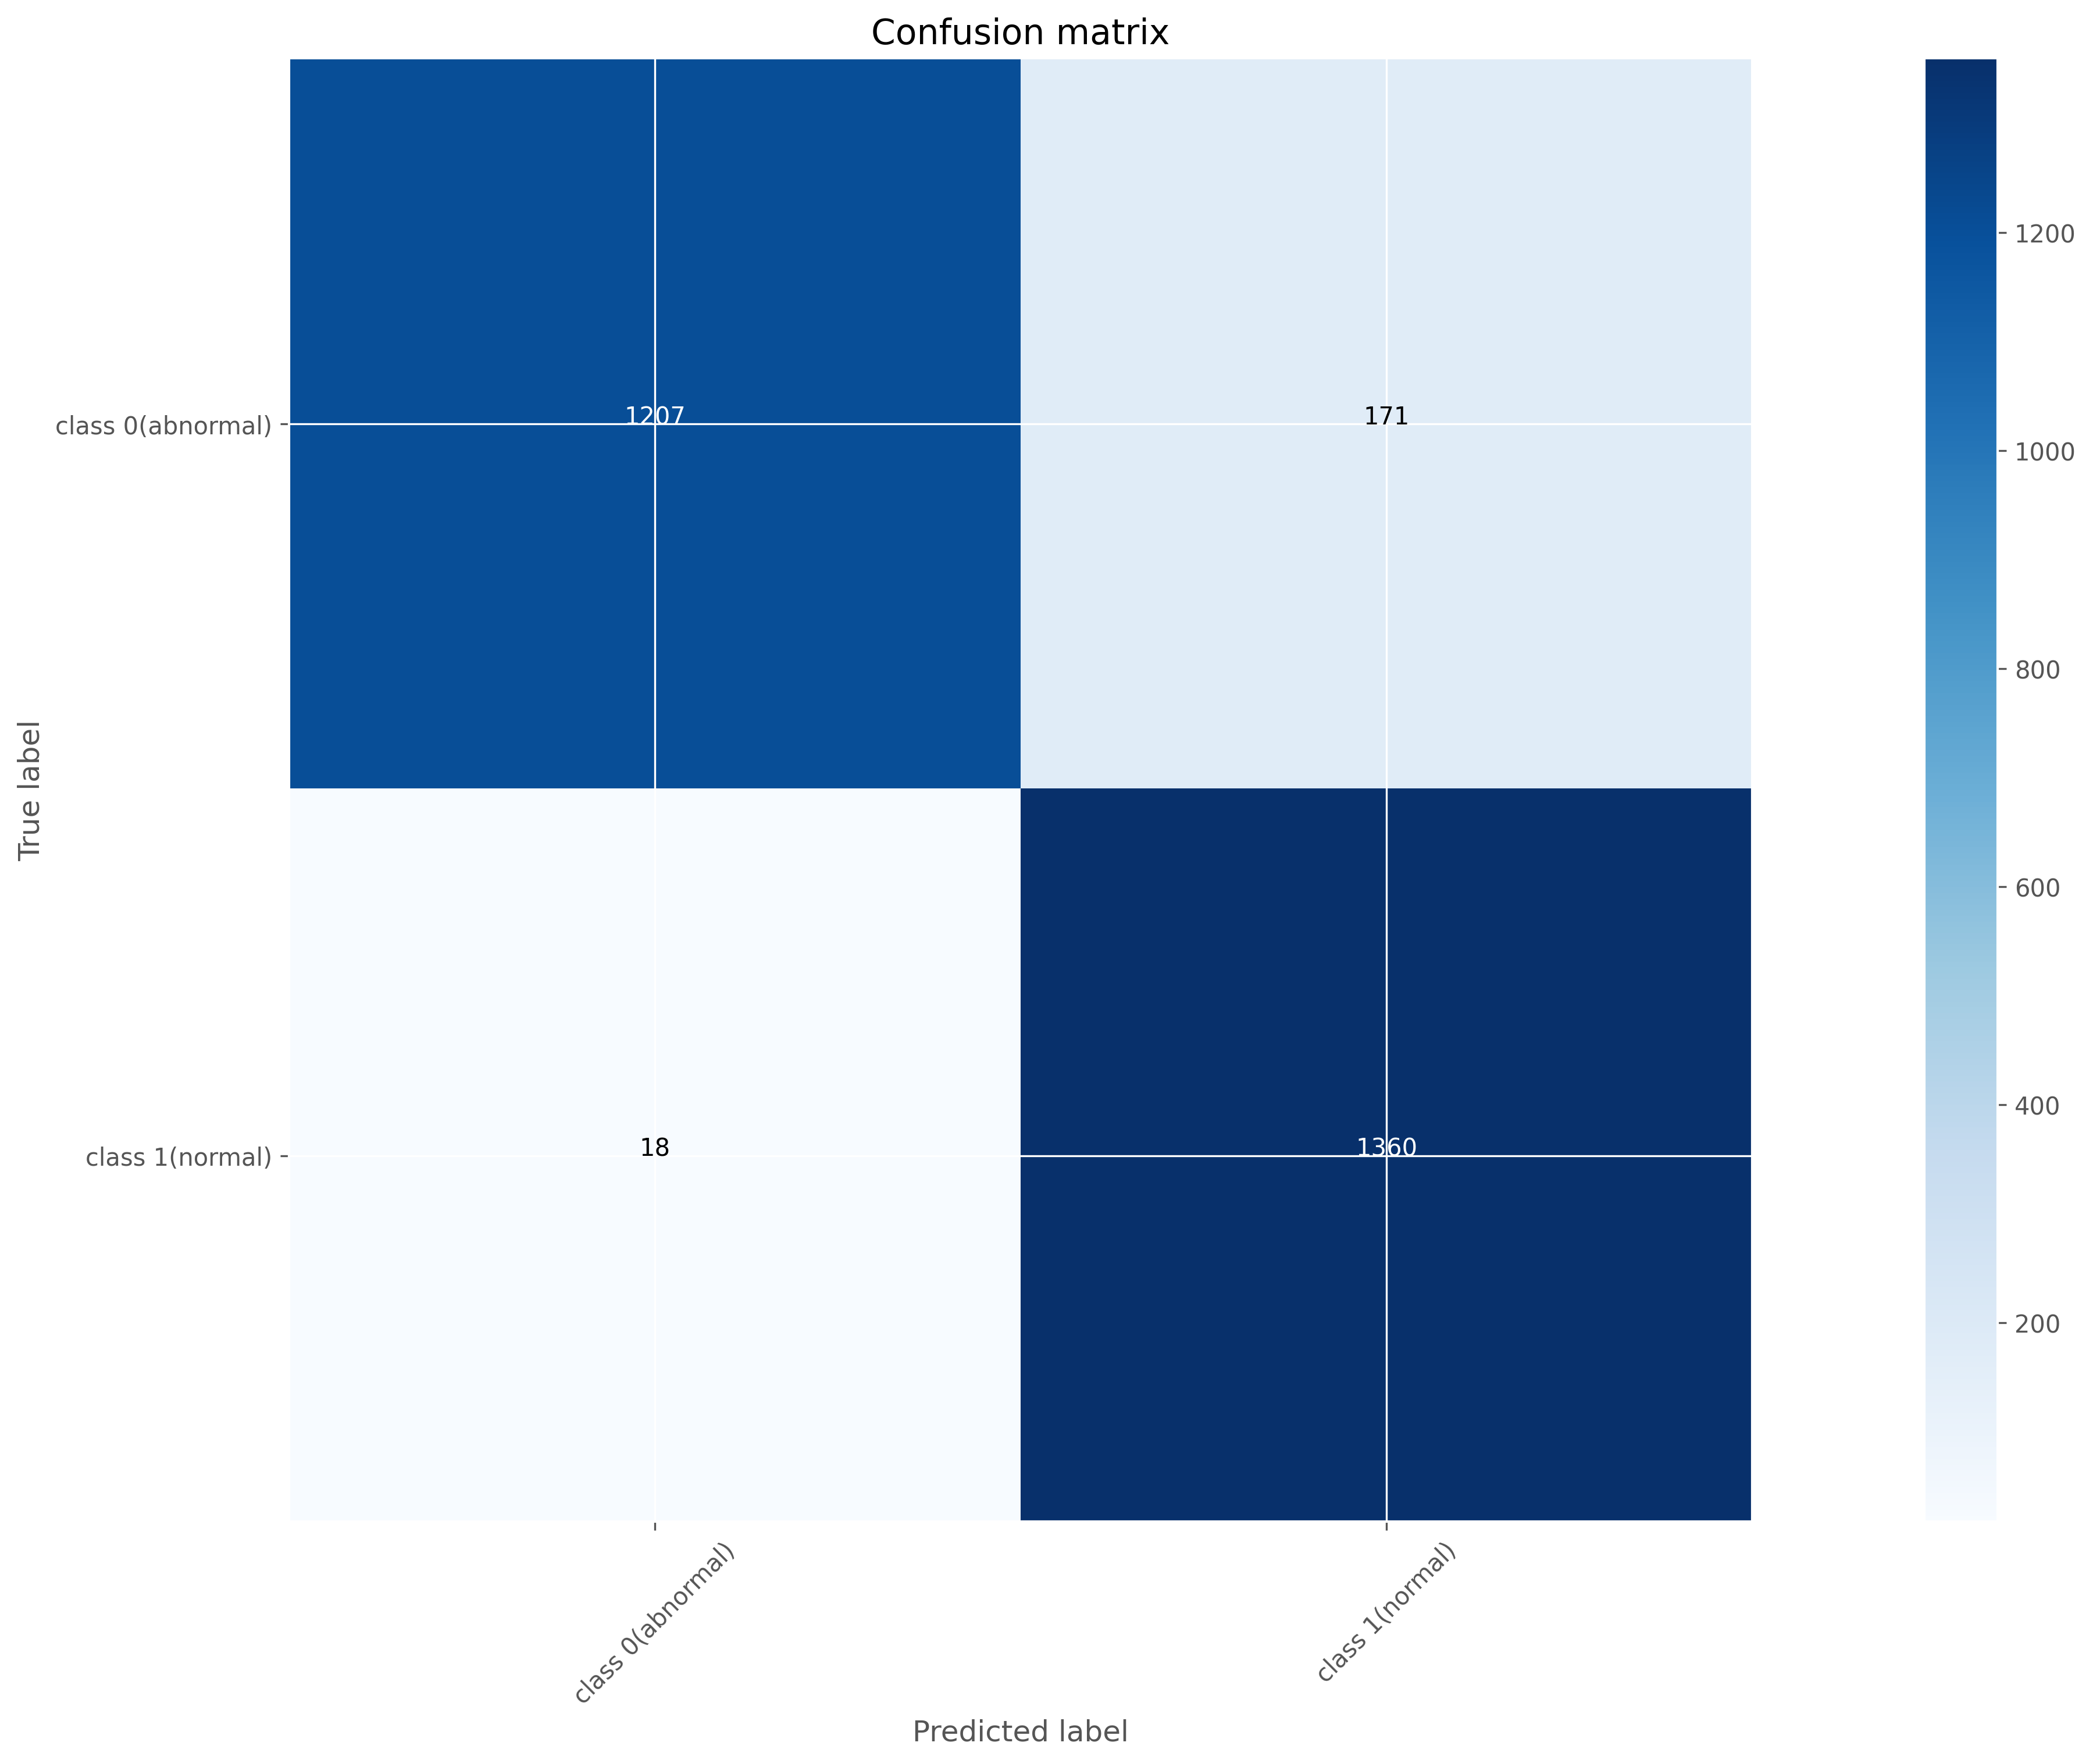

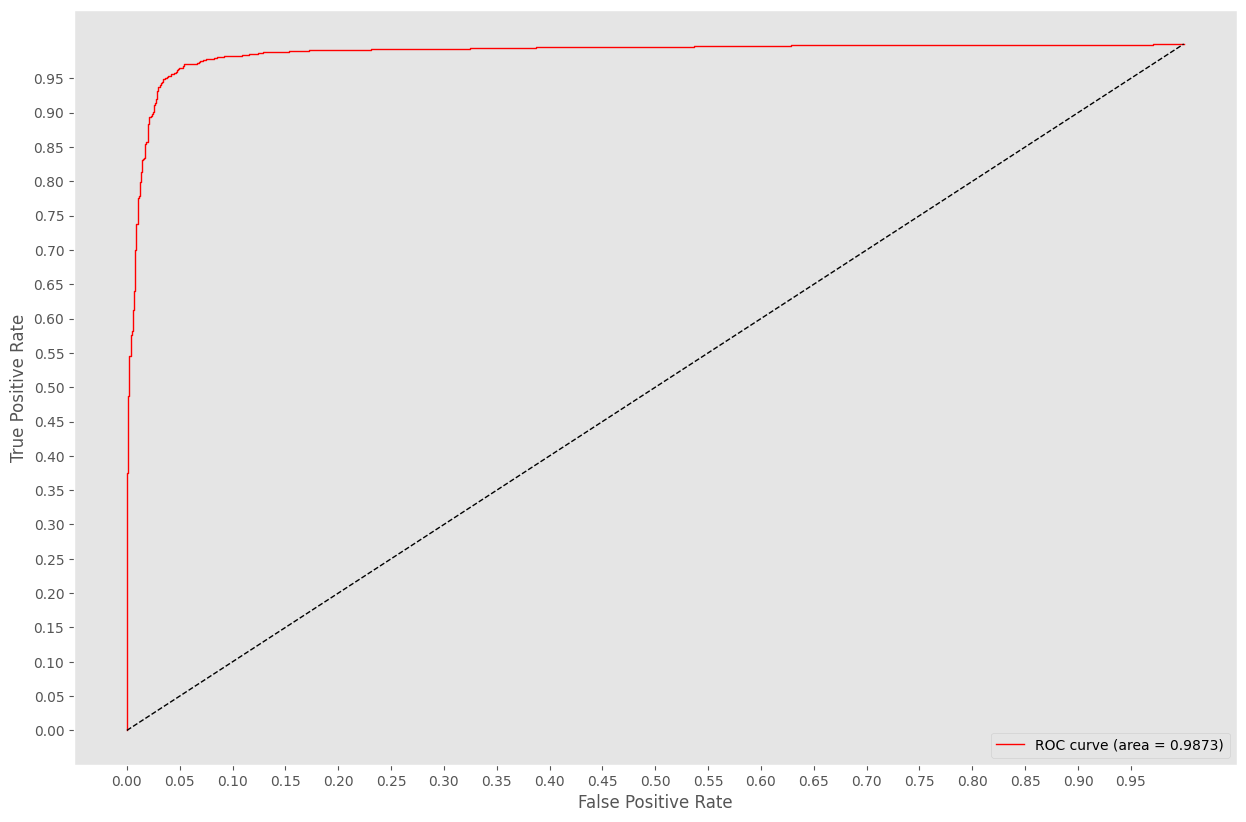

In [139]:
#%% Pair B 

pair_B_ensemble_model = ensemble(pair_B, model_input)
pair_B_ensemble_model.save('weights/ensemblemodel_pairB.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
B_ensem_y_pred = pair_B_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
B_ensemble_model_accuracy = accuracy_score(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair B Ensemble model is: ', B_ensemble_model_accuracy)

#evaluate mean squared error
B_ensemble_model_custom_mse = mean_squared_error(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_mse)

#evaluate mean squared log error
B_ensemble_model_custom_msle = mean_squared_log_error(Y_test,B_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,B_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,B_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, B_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved
The accuracy of the Pair C Ensemble model is:  0.9299709724238027
The Mean Squared Error of the Pair C Ensemble model is:  0.07002902757619739
The Mean Squared Log Error of the Pair C Ensemble model is:  0.033645657360744874
                   precision    recall  f1-score   support

class 0(abnormal)     0.9821    0.8759    0.9260      1378
  class 1(normal)     0.8880    0.9840    0.9336      1378

         accuracy                         0.9300      2756
        macro avg     0.9351    0.9300    0.9298      2756
     weighted avg     0.9351    0.9300    0.9298      2756

Confusion matrix, without normalization
[[1207  171]
 [  22 1356]]


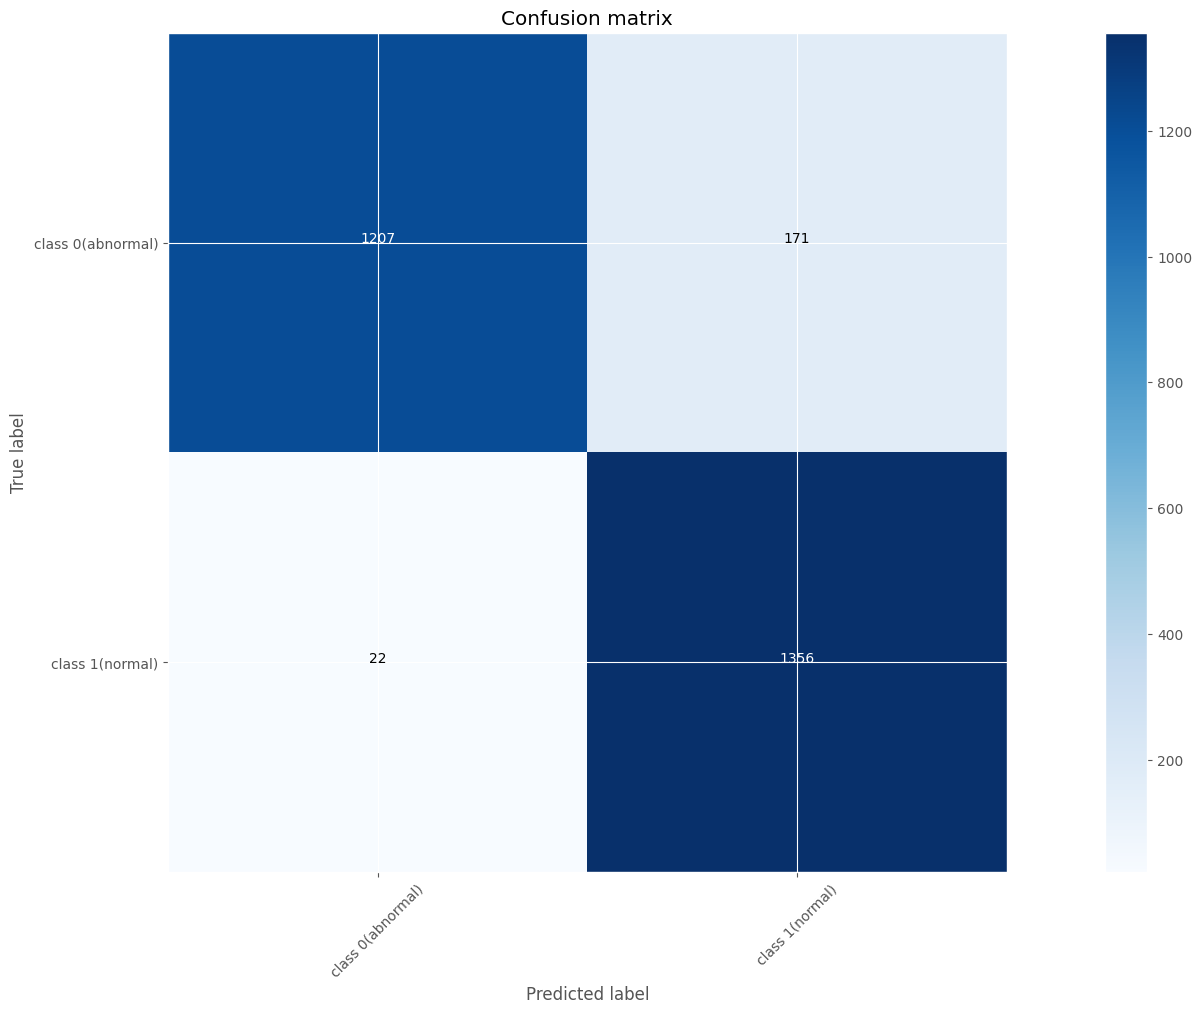

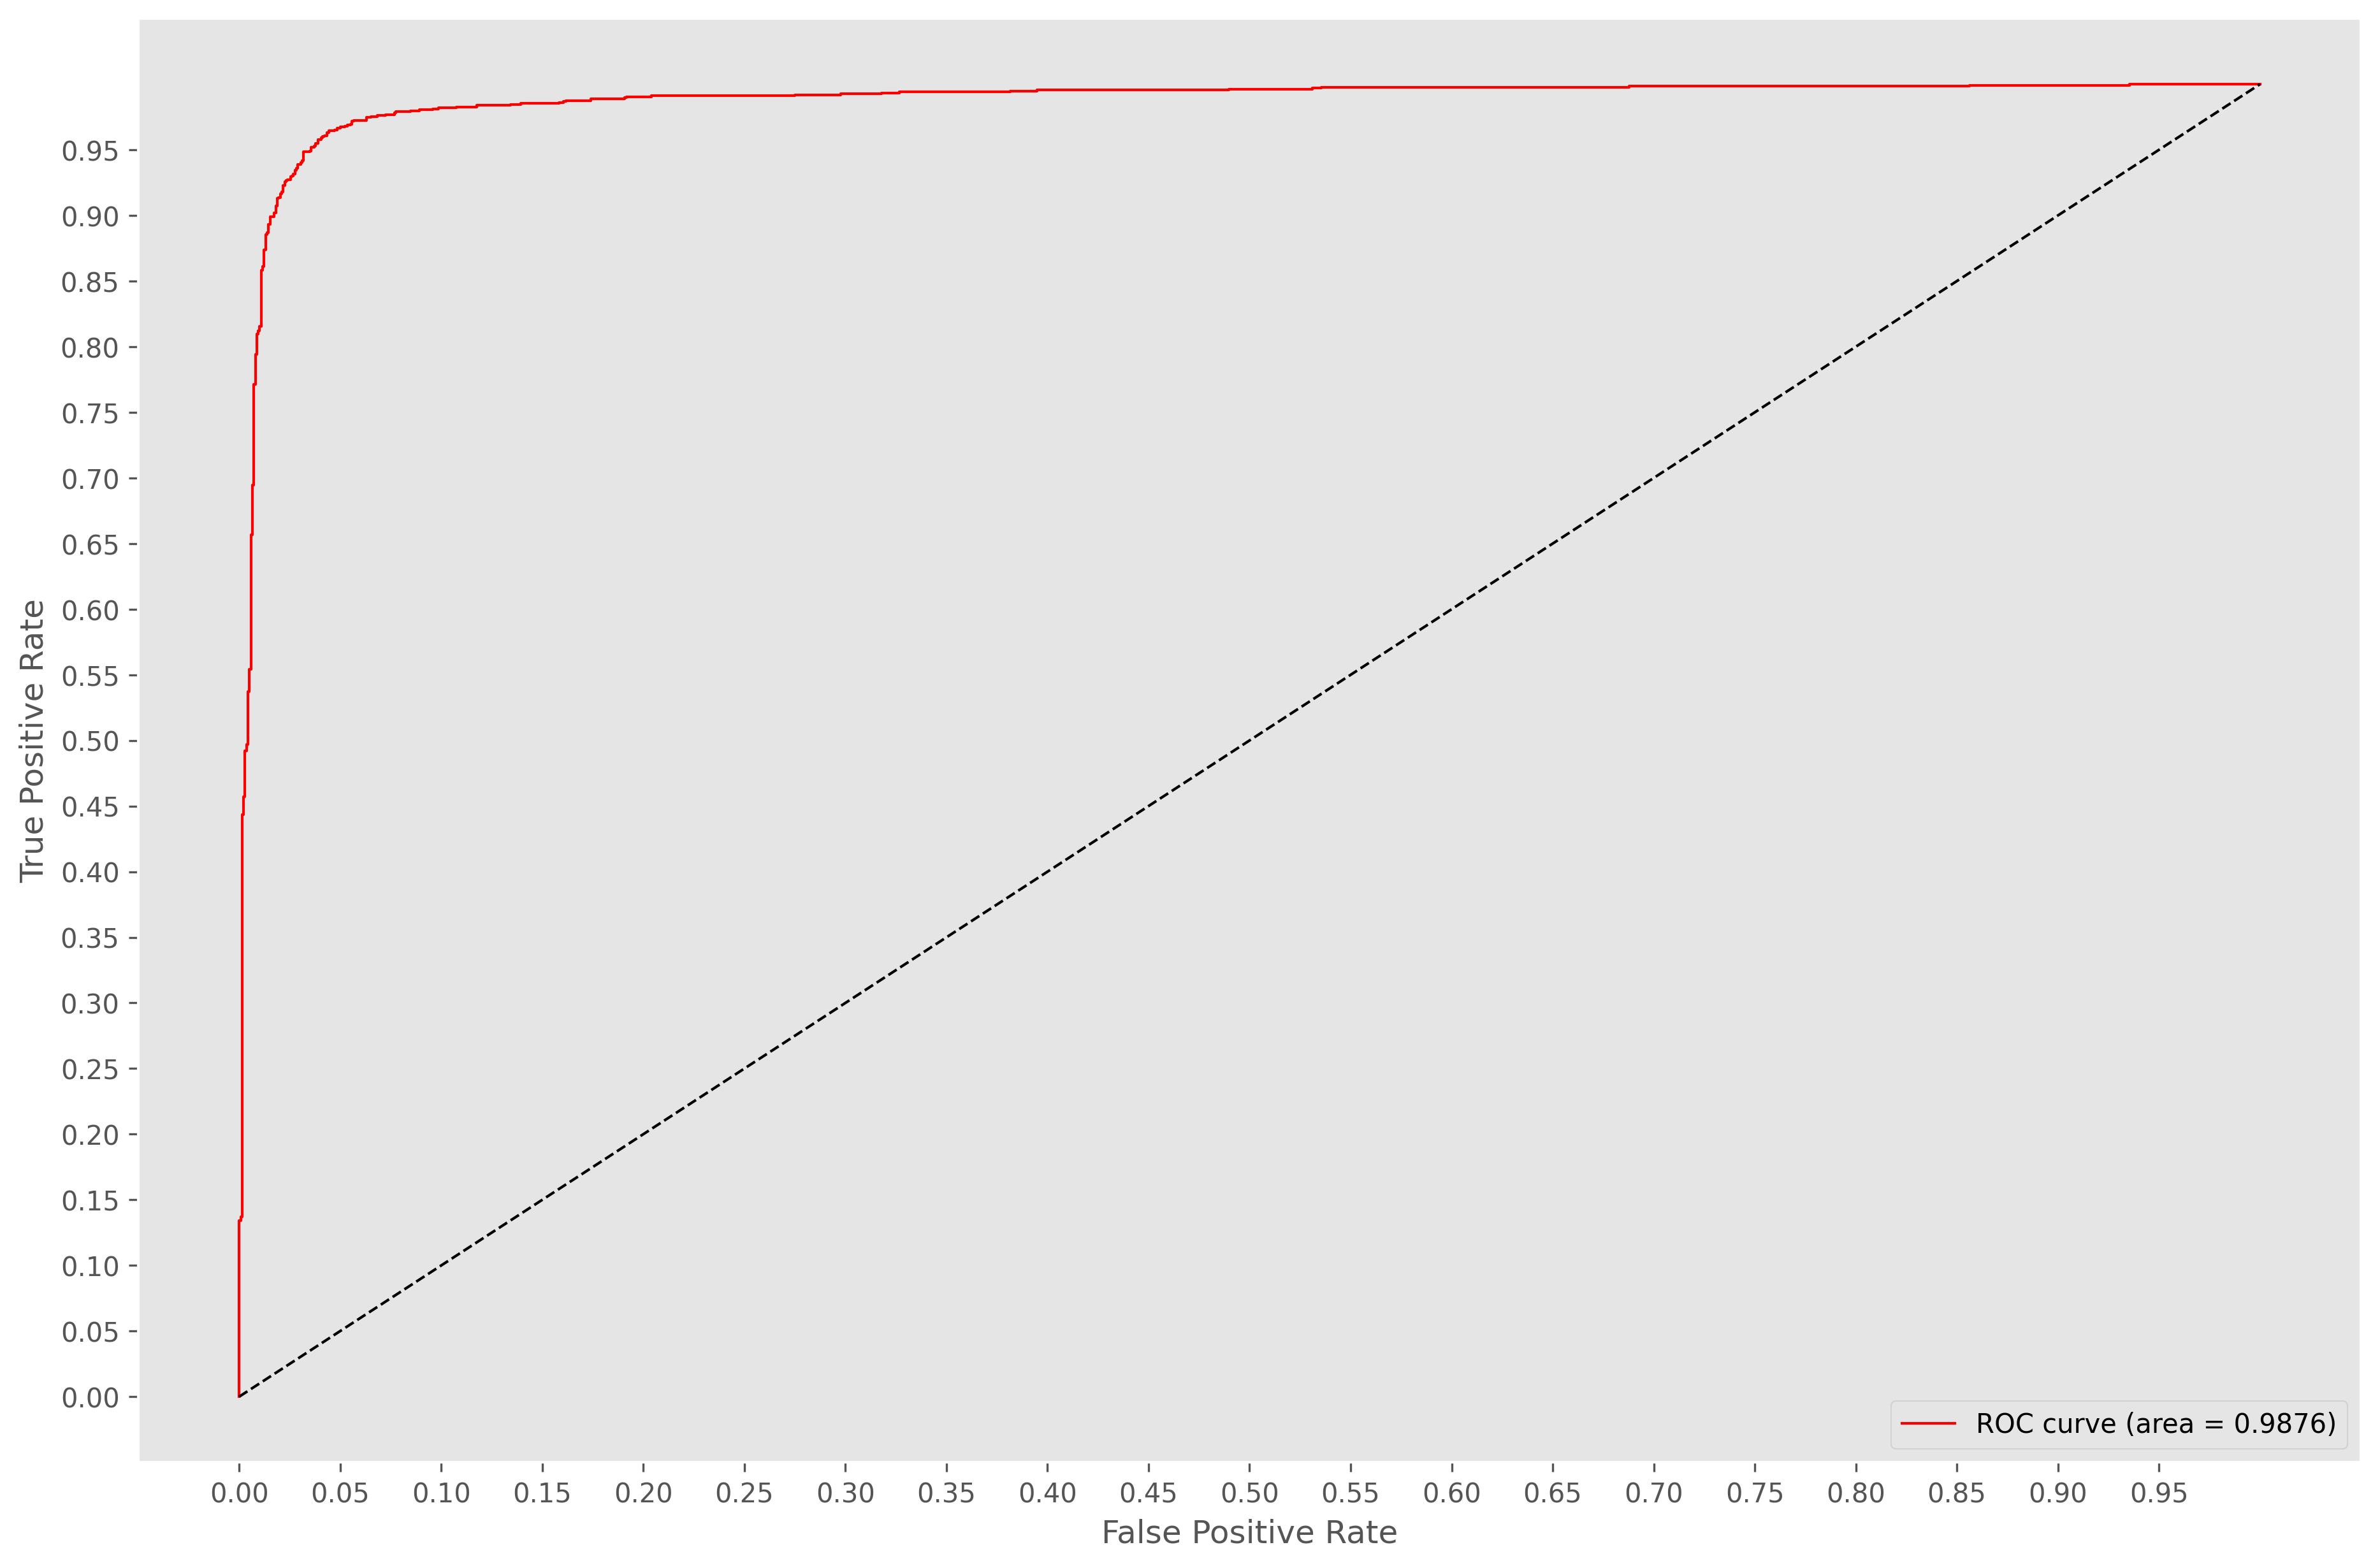

In [140]:
#%% Pair C

pair_C_ensemble_model = ensemble(pair_C, model_input)
pair_C_ensemble_model.save('weights/ensemblemodel_pairC.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
C_ensem_y_pred = pair_C_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
C_ensemble_model_accuracy = accuracy_score(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair C Ensemble model is: ', C_ensemble_model_accuracy)

#evaluate mean squared error
C_ensemble_model_custom_mse = mean_squared_error(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_mse)

#evaluate mean squared log error
C_ensemble_model_custom_msle = mean_squared_log_error(Y_test,C_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,C_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,C_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, C_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>]
The Ensemble Model is Saved
The accuracy of the Pair D_ Ensemble model is:  0.9571843251088534
The Mean Squared Error of the Pair D_ Ensemble model is:  0.04281567489114659
The Mean Squared Log Error of the Pair D_ Ensemble model is:  0.020570920044393235
                   precision    recall  f1-score   support

class 0(abnormal)     0.9559    0.9586    0.9572      1378
  class 1(normal)     0.9585    0.9557    0.9571      1378

         accuracy                         0.9572      2756
        macro avg     0.9572    0.9572    0.9572      2756
     weighted avg     0.9572    0.9572    0.9572      2756

Confusion matrix, without normalization
[[1321   57]
 [  61 1317]]


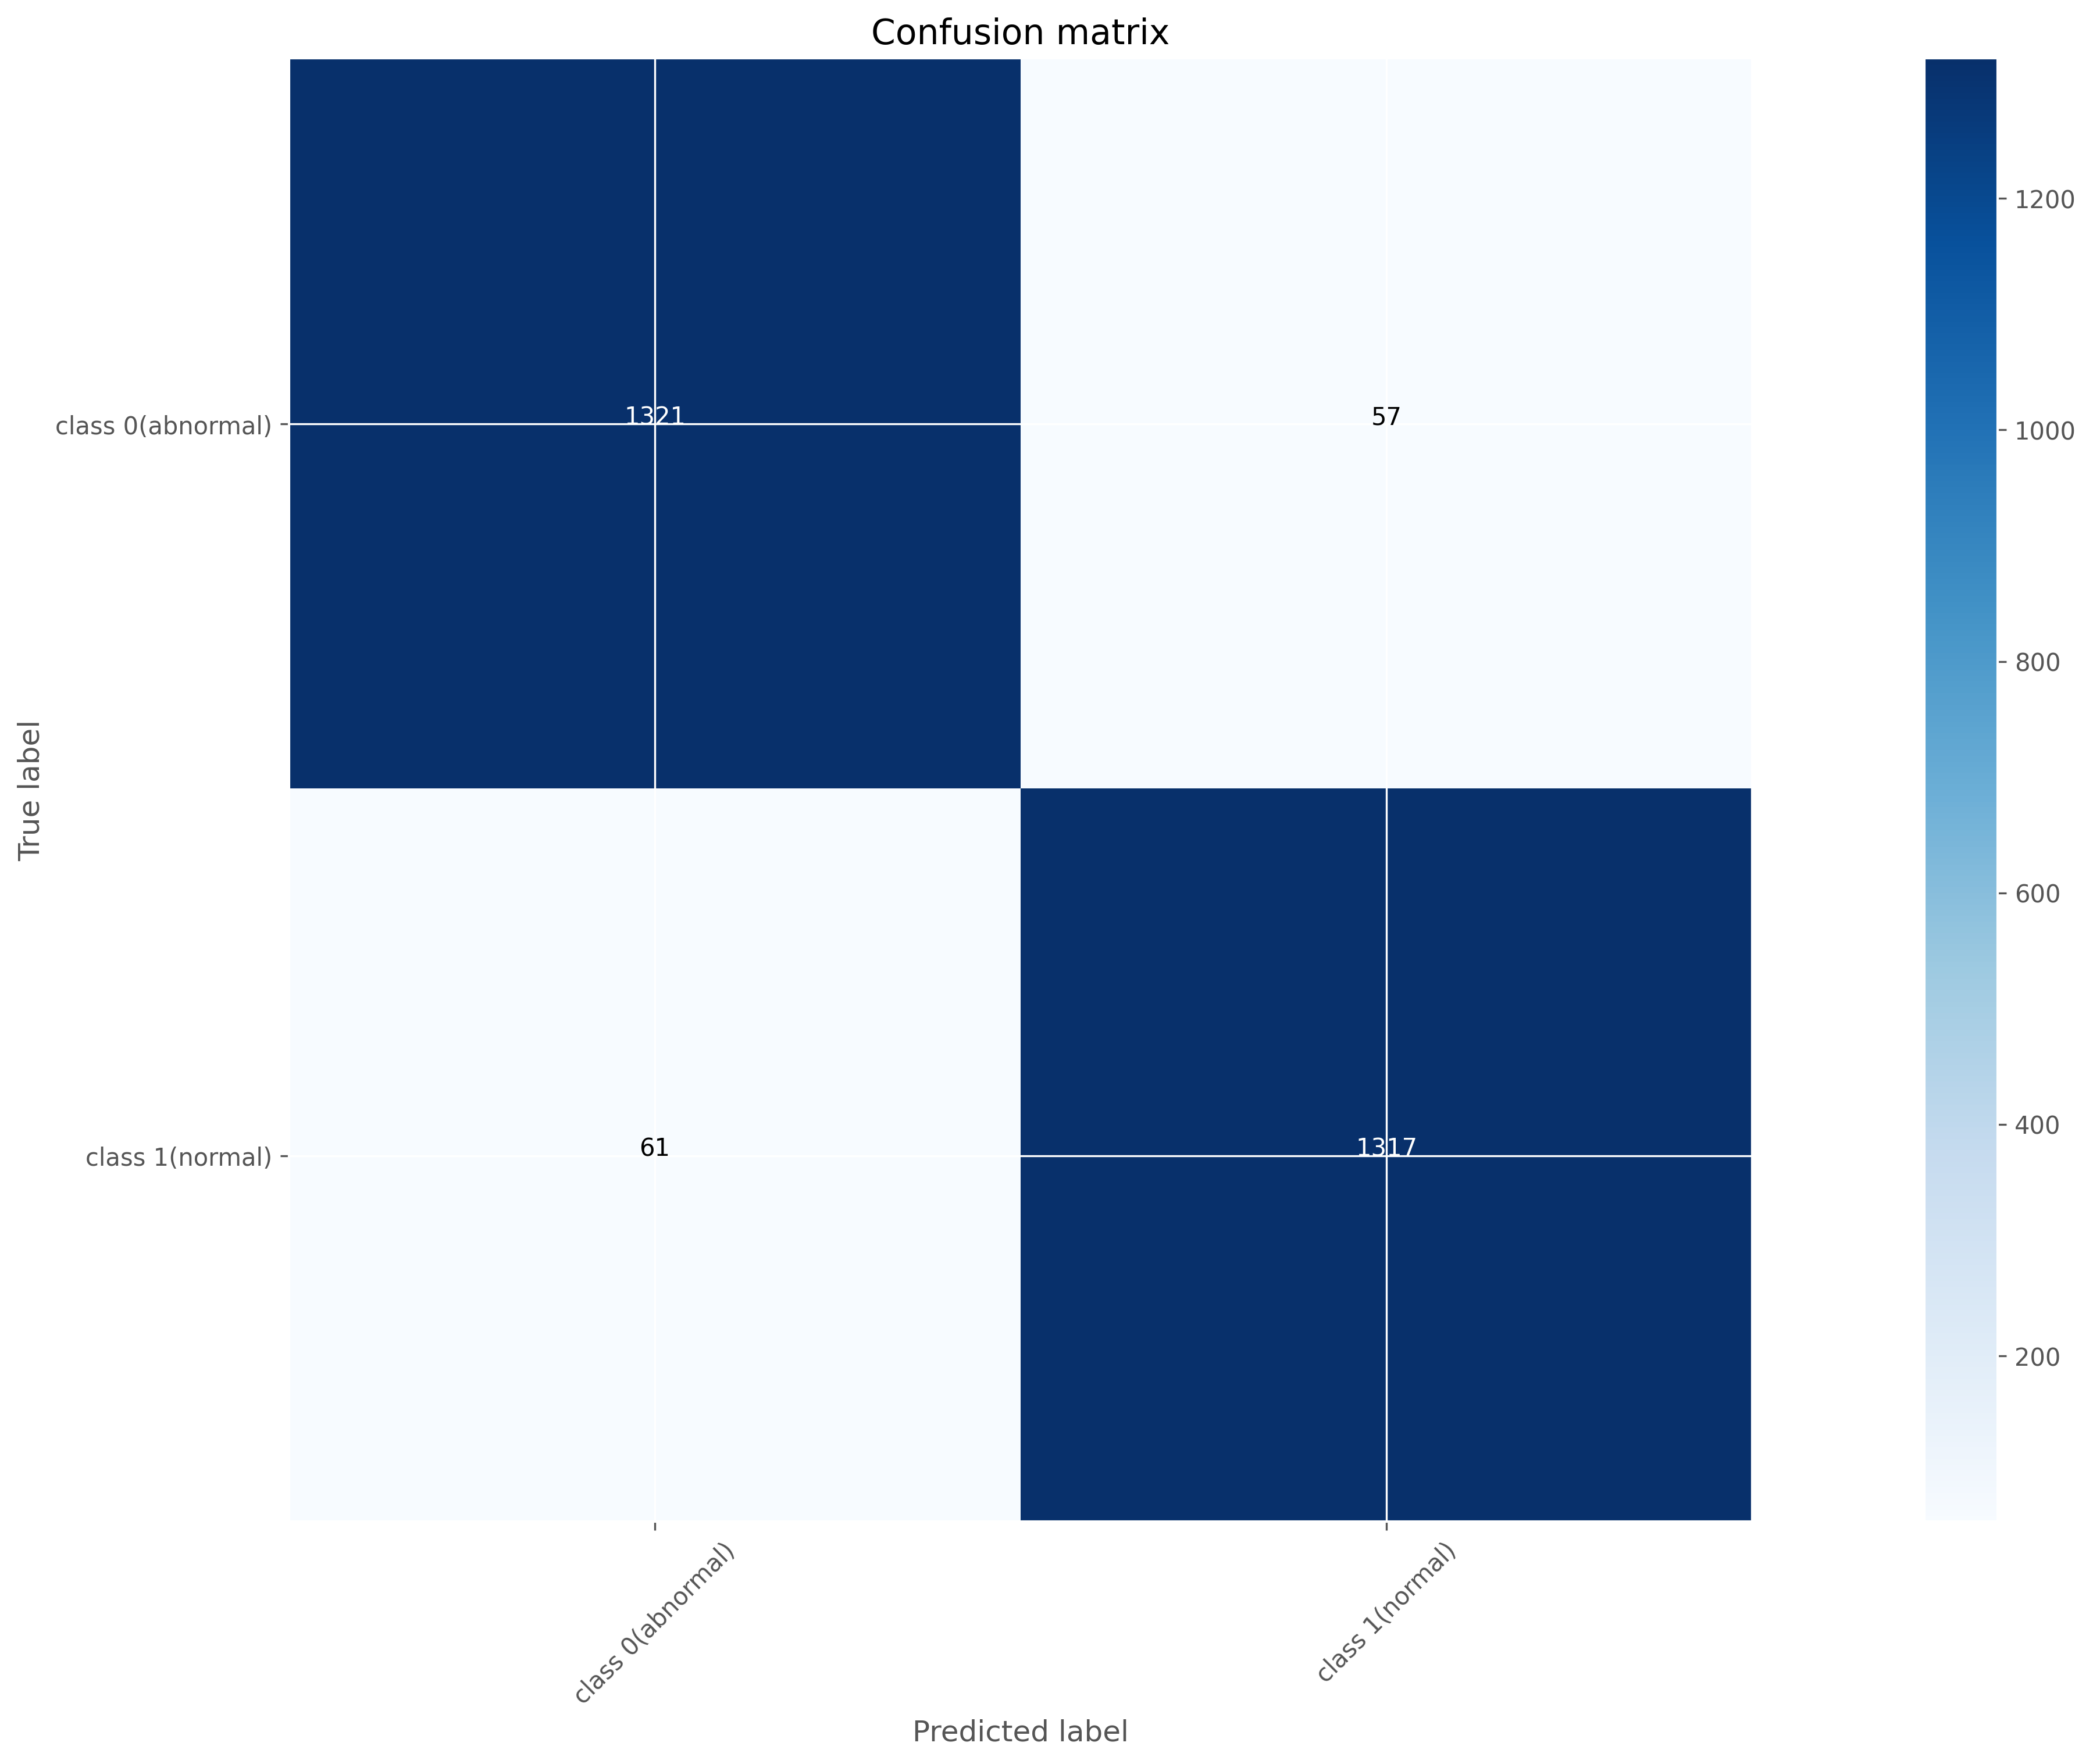

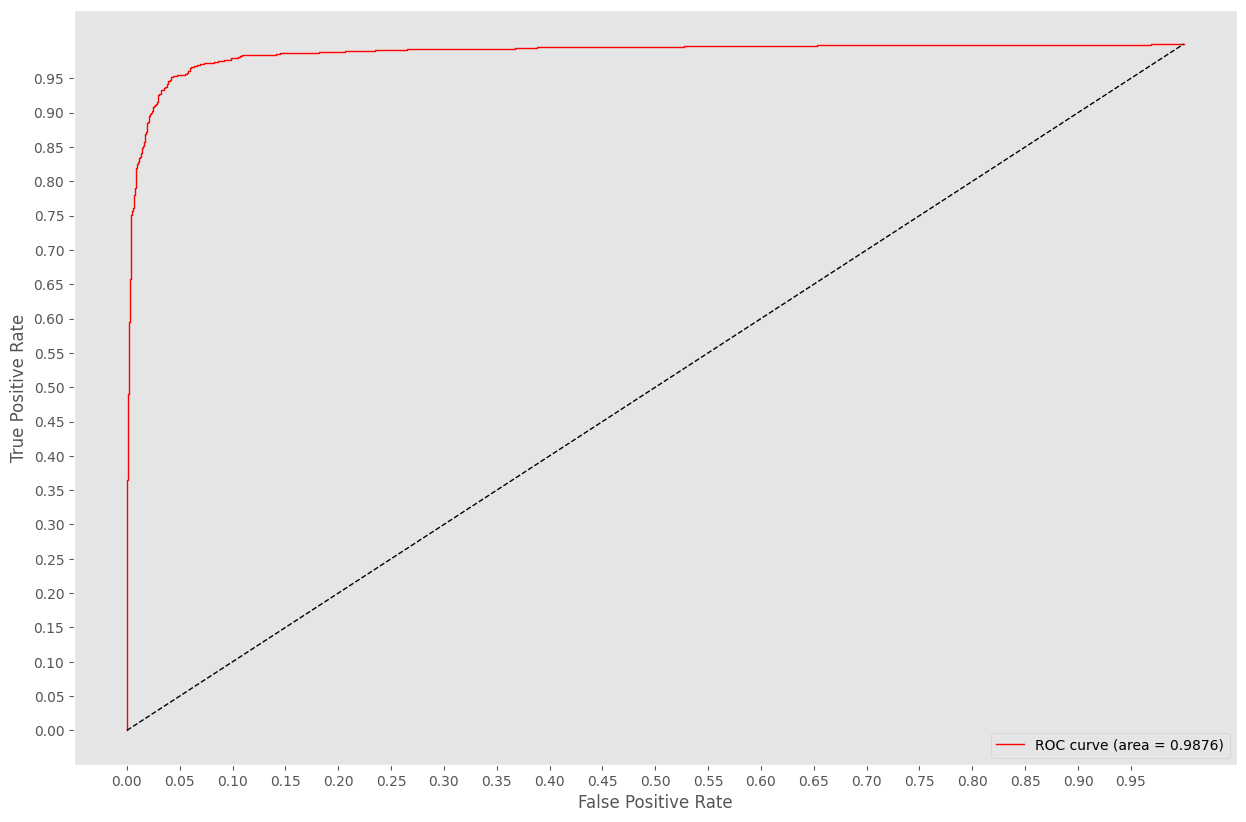

In [141]:
#%% Pair D

pair_D_ensemble_model = ensemble(pair_D, model_input)
pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved
The accuracy of the Pair E_ Ensemble model is:  0.9597242380261248
The Mean Squared Error of the Pair E Ensemble model is:  0.04027576197387518
The Mean Squared Log Error of the Pair E Ensemble model is:  0.019350611228200417
                   precision    recall  f1-score   support

class 0(abnormal)     0.9535    0.9666    0.9600      1378
  class 1(normal)     0.9662    0.9528    0.9594      1378

         accuracy                         0.9597      2756
        macro avg     0.9598    0.9597    0.9597      2756
     weighted avg     0.9598    0.9597    0.9597      2756

Confusion matrix, without normalization
[[1332   46]
 [  65 1313]]


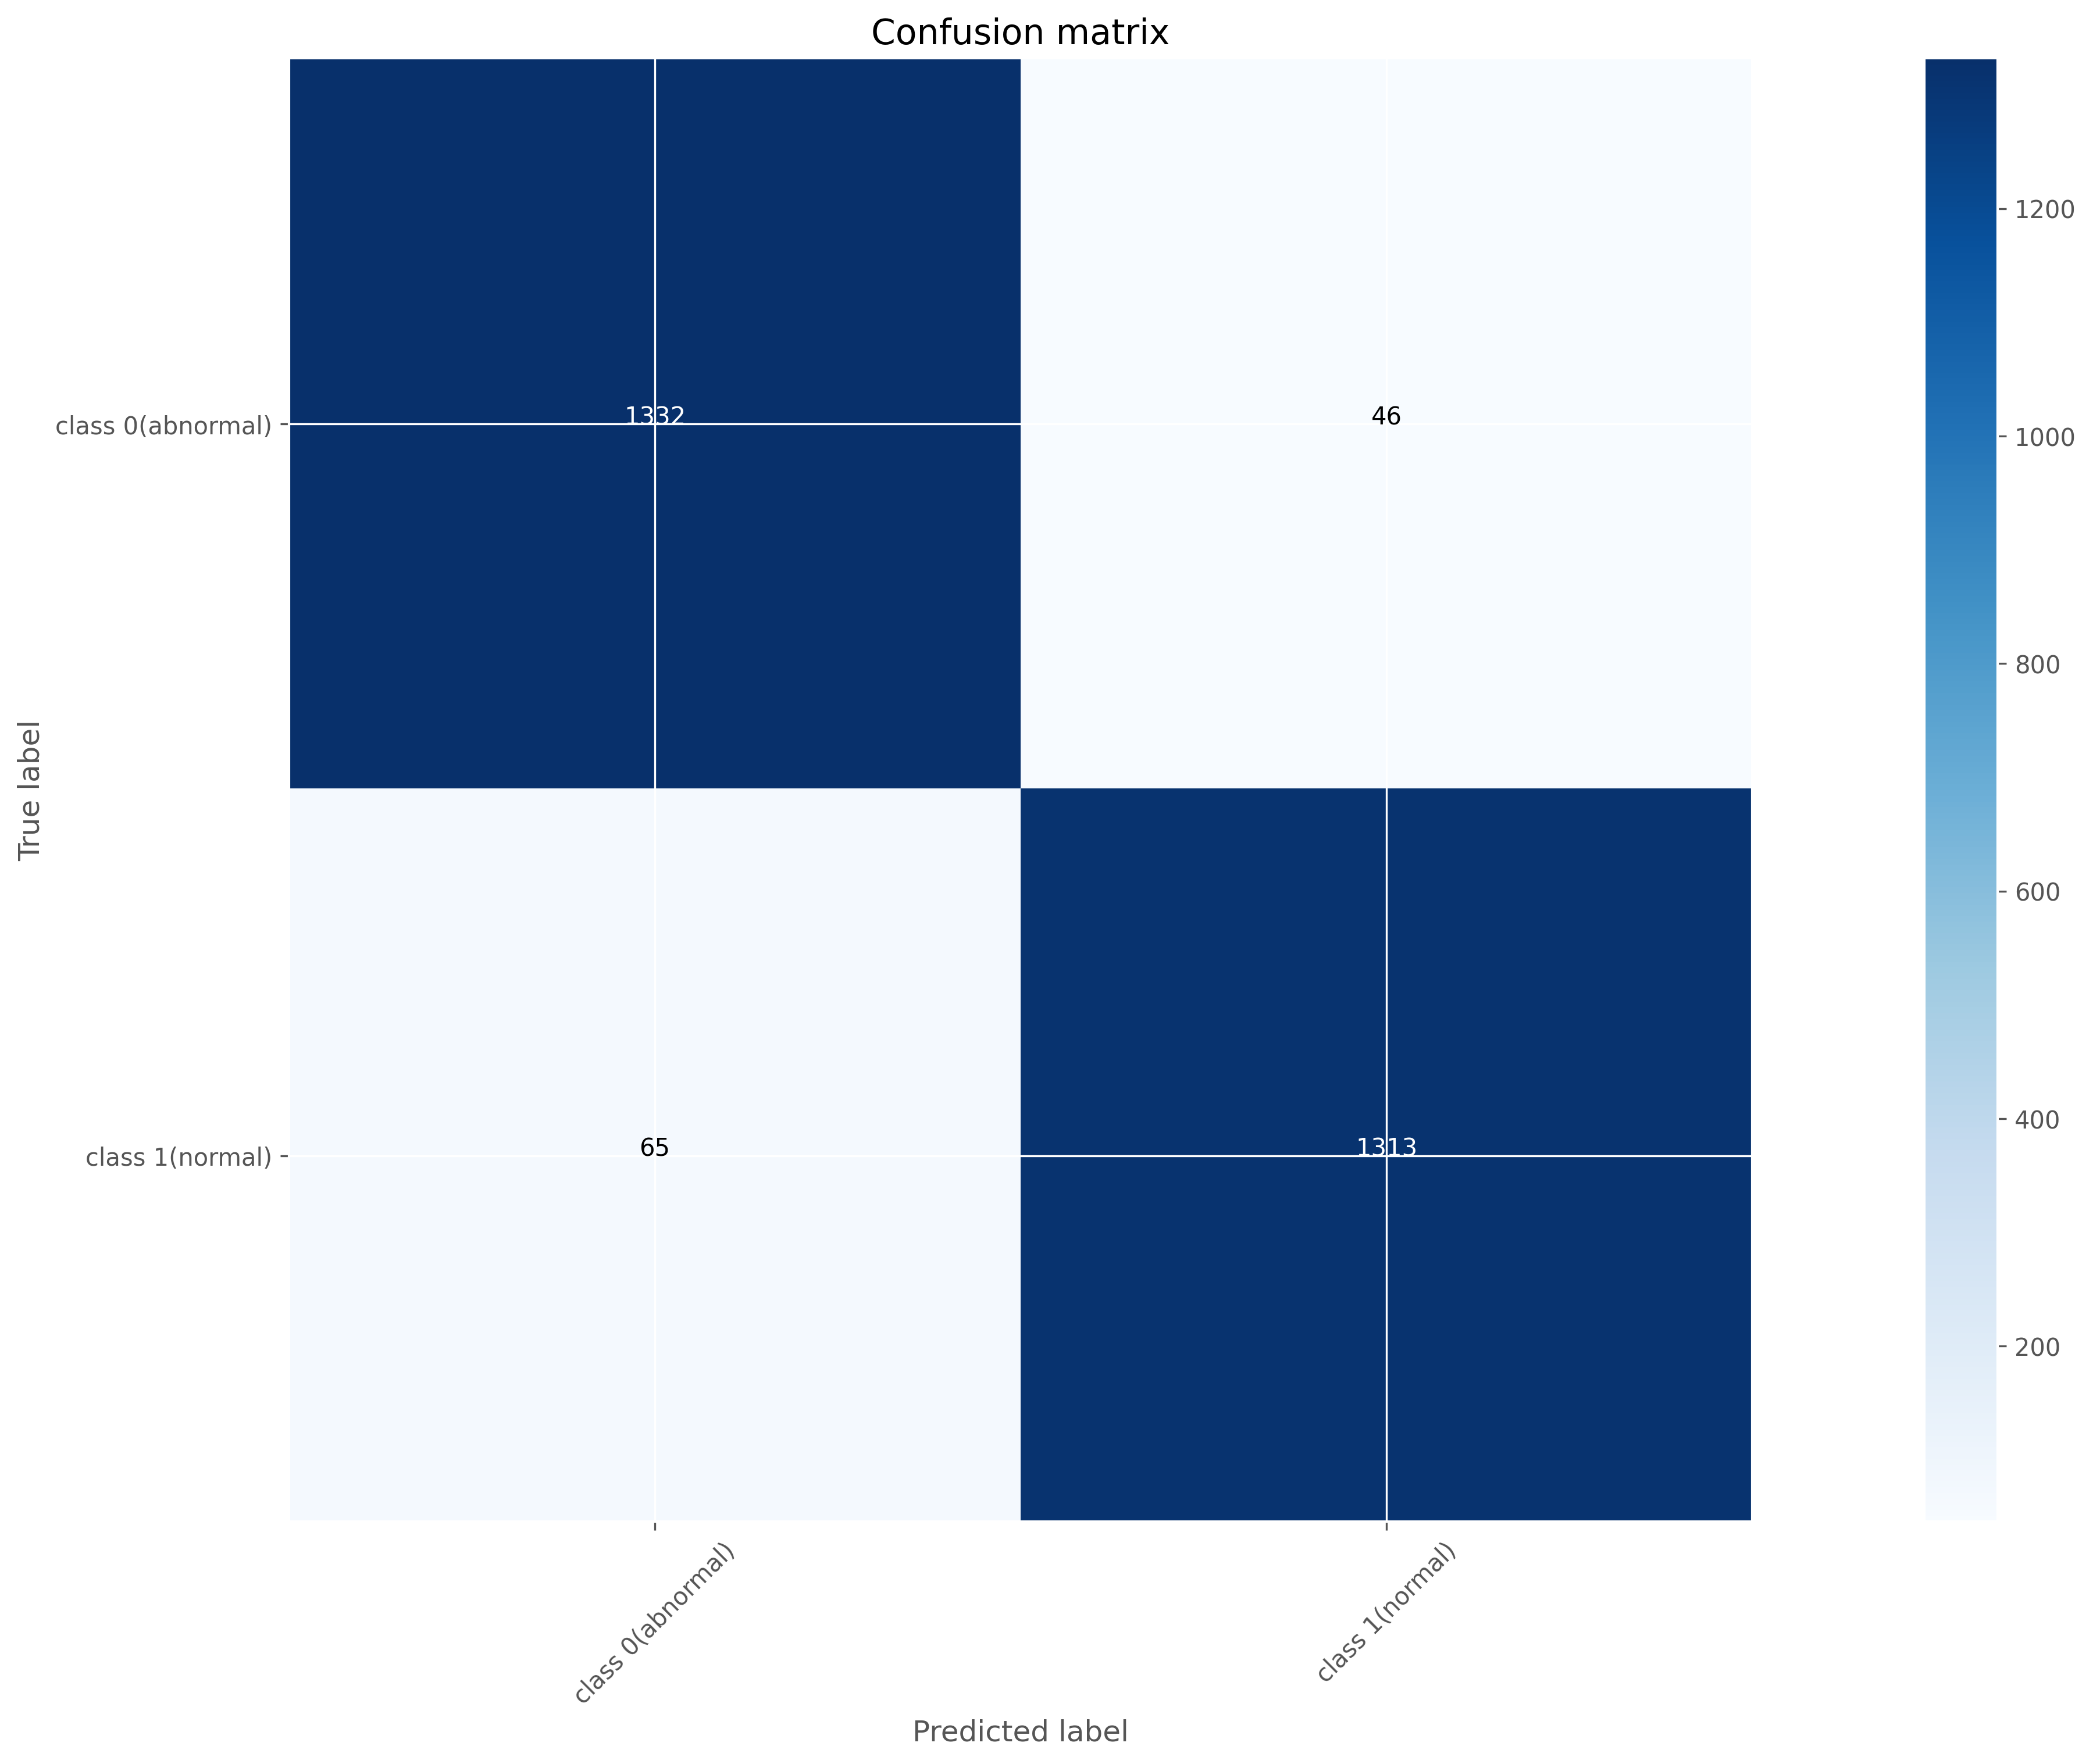

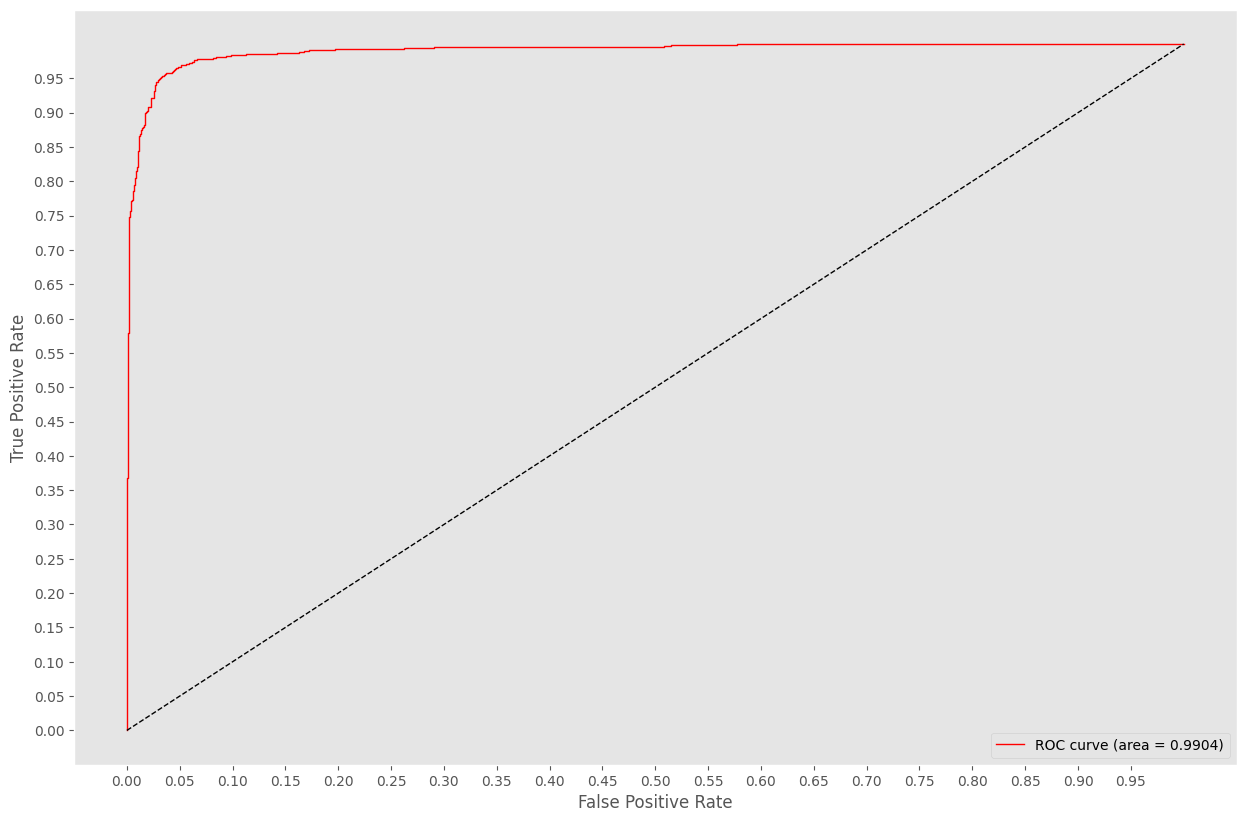

In [142]:
 #%% Pair E

pair_E_ensemble_model = ensemble(pair_E, model_input)
pair_E_ensemble_model.save('weights/ensemblemodel_pairE.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
E_ensem_y_pred = pair_E_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
E_ensemble_model_accuracy = accuracy_score(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair E_ Ensemble model is: ', E_ensemble_model_accuracy)

#evaluate mean squared error
E_ensemble_model_custom_mse = mean_squared_error(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_mse)

#evaluate mean squared log error
E_ensemble_model_custom_msle = mean_squared_log_error(Y_test,E_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,E_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, E_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved
The accuracy of the Pair F_ Ensemble model is:  0.9579100145137881
The Mean Squared Error of the Pair F_ Ensemble model is:  0.0420899854862119
The Mean Squared Log Error of the Pair F_Ensemble model is:  0.02022226038262386
                   precision    recall  f1-score   support

class 0(abnormal)     0.9723    0.9427    0.9573      1378
  class 1(normal)     0.9444    0.9731    0.9585      1378

         accuracy                         0.9579      2756
        macro avg     0.9583    0.9579    0.9579      2756
     weighted avg     0.9583    0.9579    0.9579      2756

Confusion matrix, without normalization
[[1299   79]
 [  37 1341]]


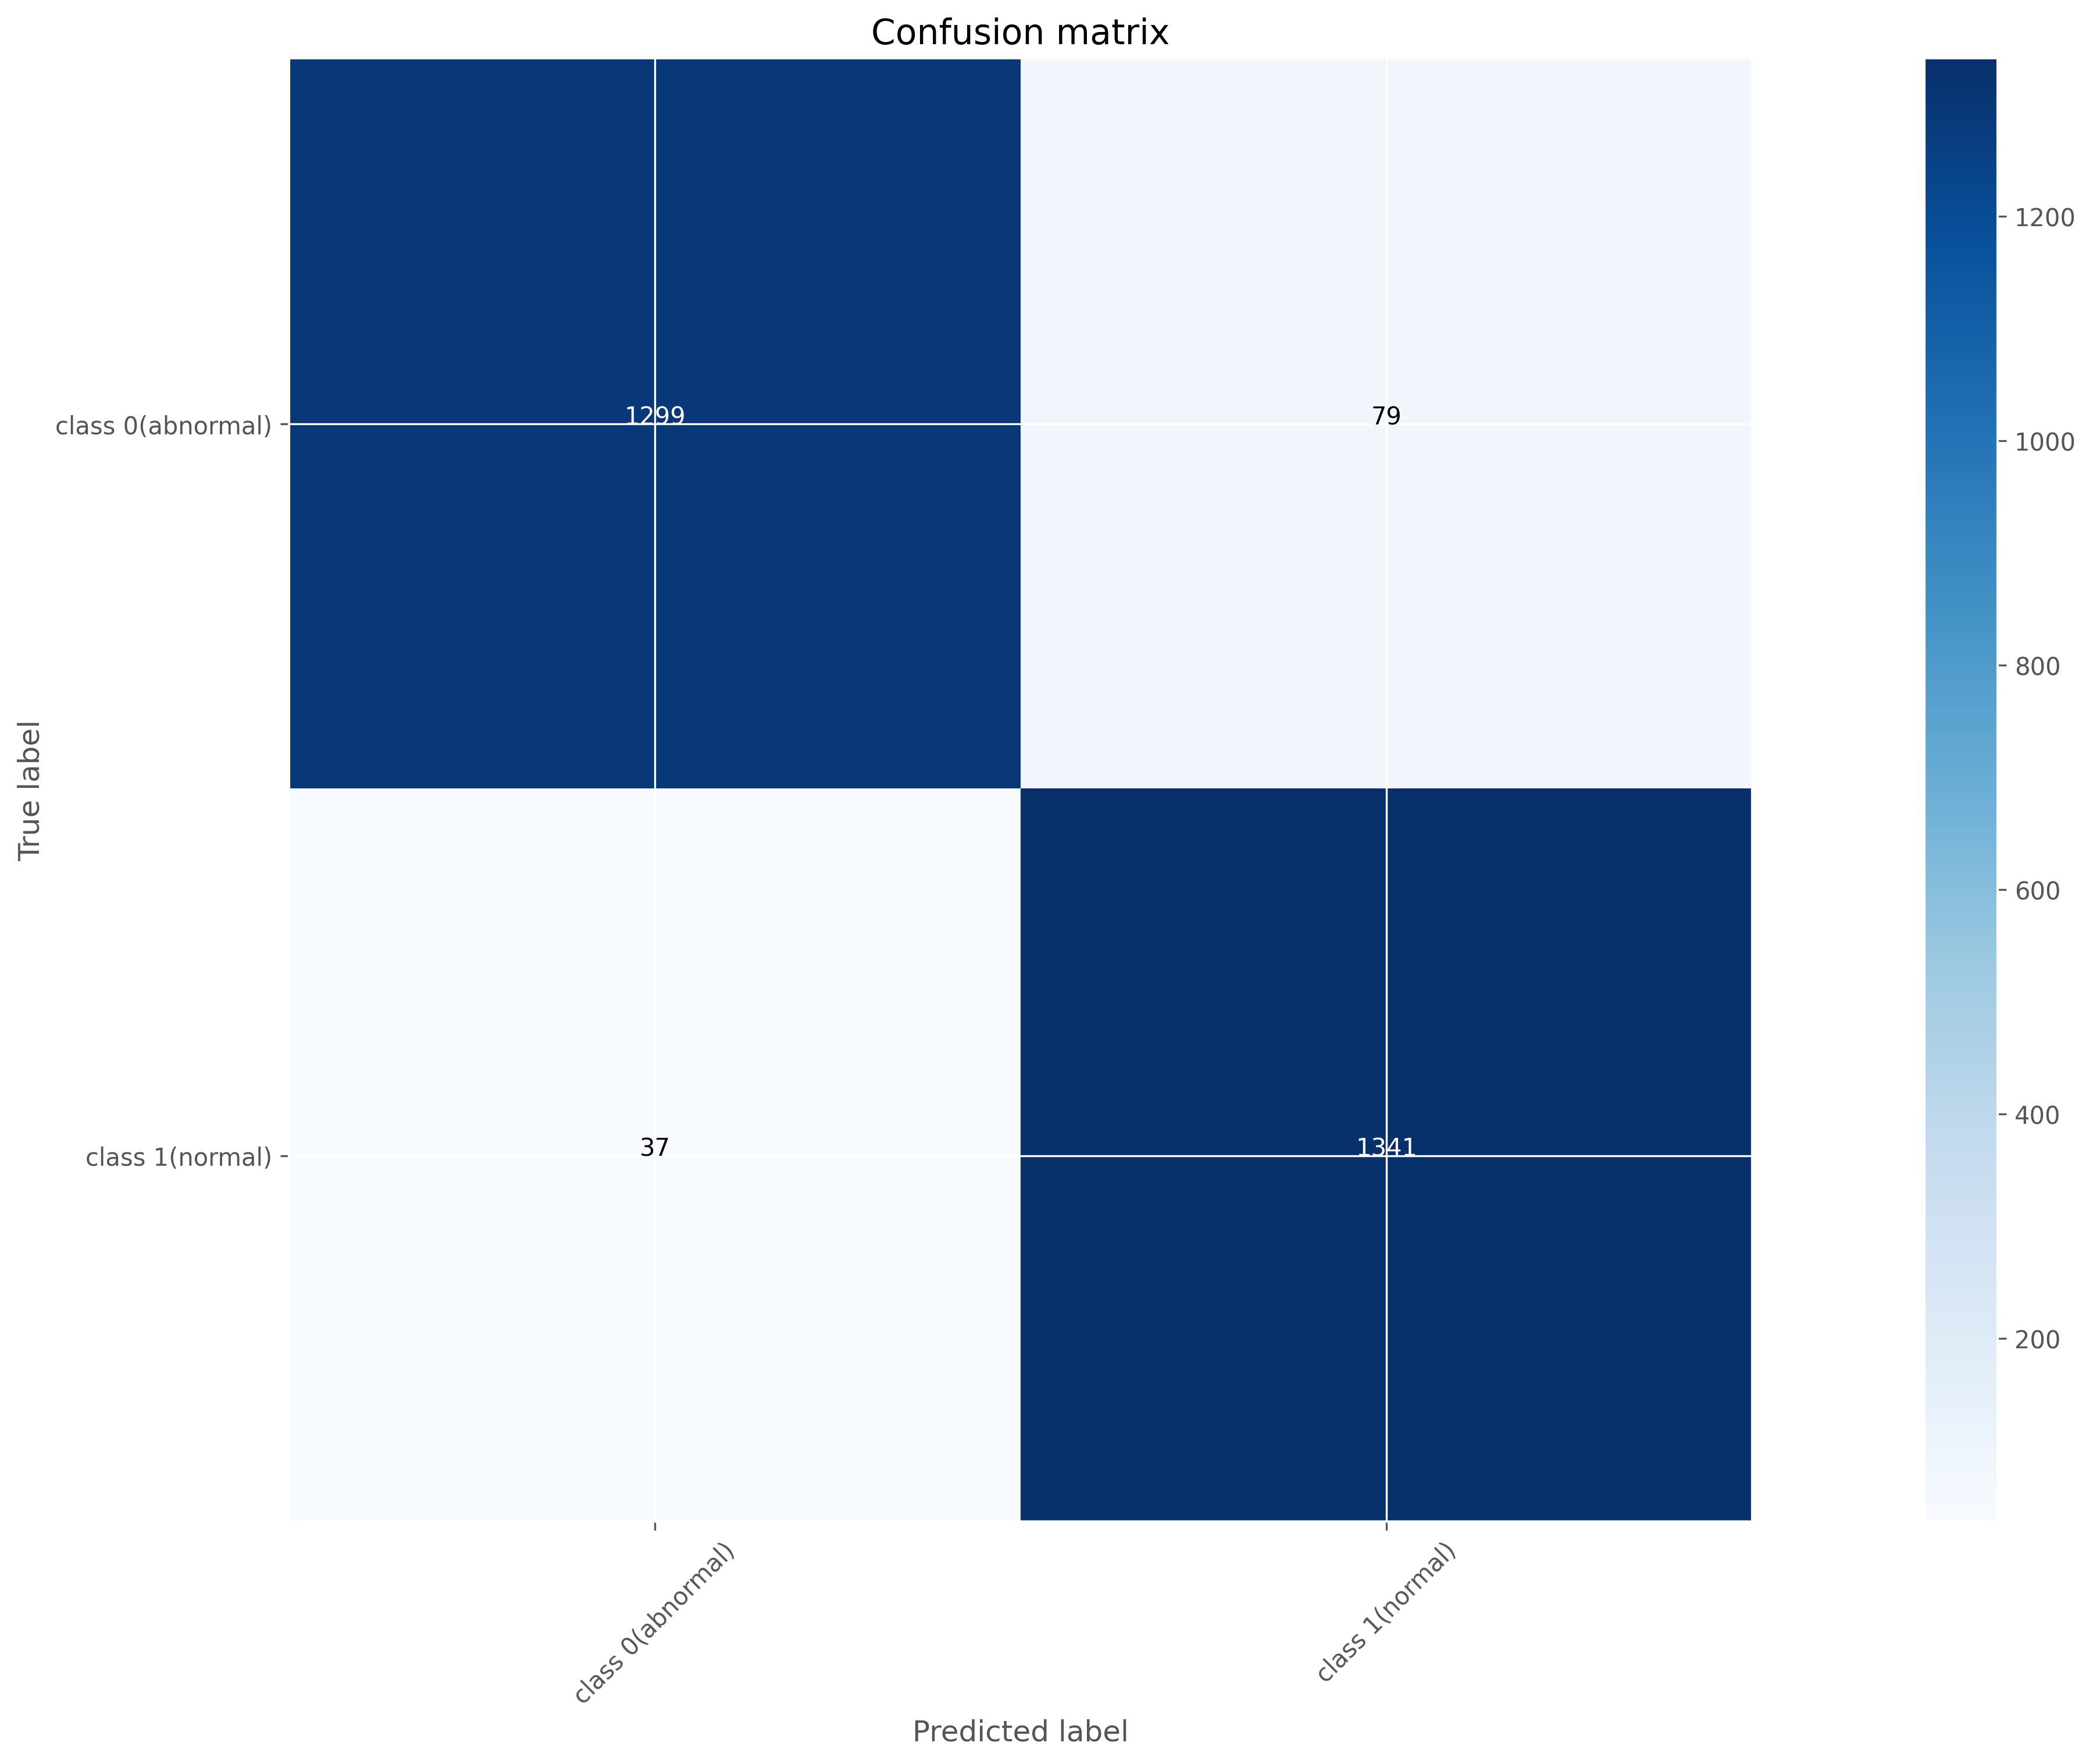

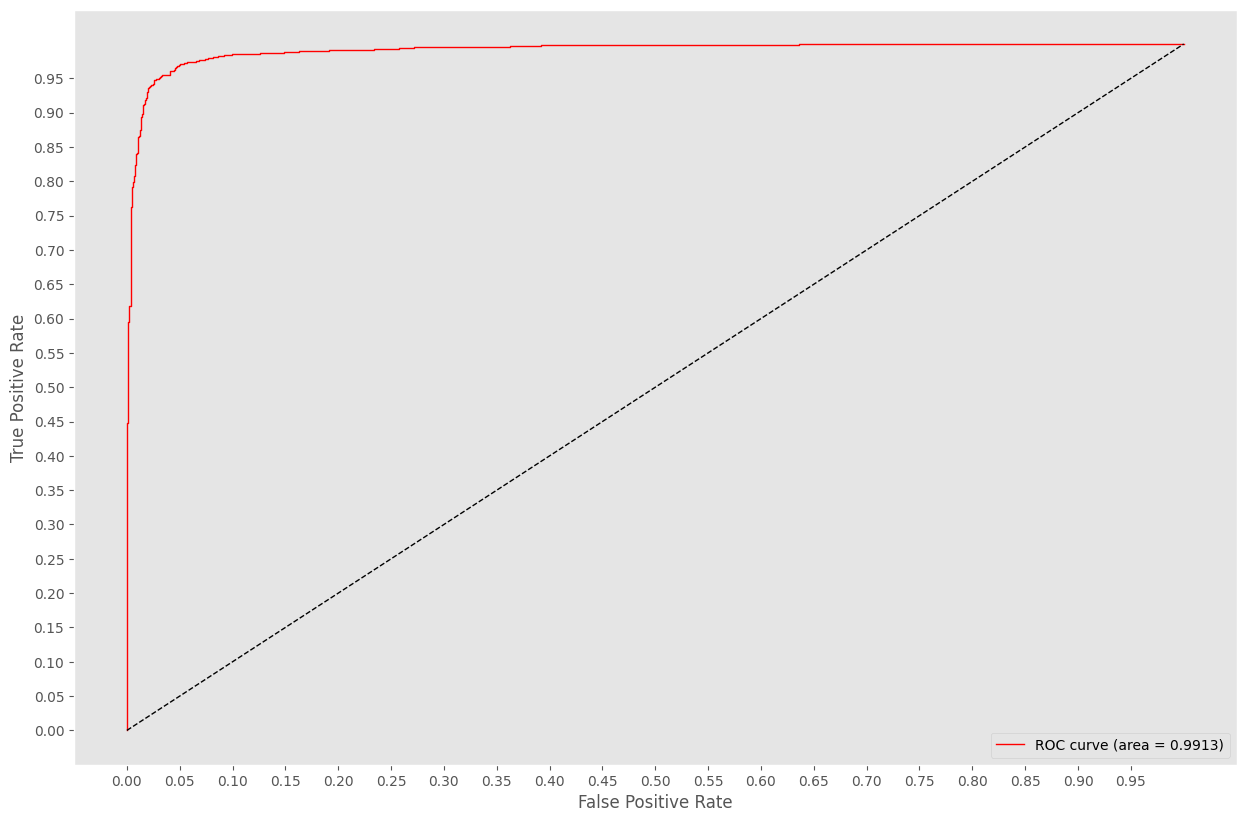

In [143]:
 #%% Pair F

pair_F_ensemble_model = ensemble(pair_F, model_input)
pair_F_ensemble_model.save('weights/ensemblemodel_pairF.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
F_ensem_y_pred = pair_F_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
F_ensemble_model_accuracy = accuracy_score(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair F_ Ensemble model is: ', F_ensemble_model_accuracy)

#evaluate mean squared error
F_ensemble_model_custom_mse = mean_squared_error(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair F_ Ensemble model is: ', F_ensemble_model_custom_mse)

#evaluate mean squared log error
F_ensemble_model_custom_msle = mean_squared_log_error(Y_test,F_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair F_Ensemble model is: ', F_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,F_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,F_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, F_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>]
The Ensemble Model is Saved
The accuracy of the Pair G_ Ensemble model is:  0.9542815674891146
The Mean Squared Error of the Pair G_ Ensemble model is:  0.045718432510885344
The Mean Squared Log Error of the Pair G_ Ensemble model is:  0.021965558691470745
                   precision    recall  f1-score   support

class 0(abnormal)     0.9535    0.9666    0.9600      1378
  class 1(normal)     0.9662    0.9528    0.9594      1378

         accuracy                         0.9597      2756
        macro avg     0.9598    0.9597    0.9597      2756
     weighted avg     0.9598    0.9597    0.9597      2756

Confusion matrix, without normalization
[[1288   90]
 [  36 1342]]


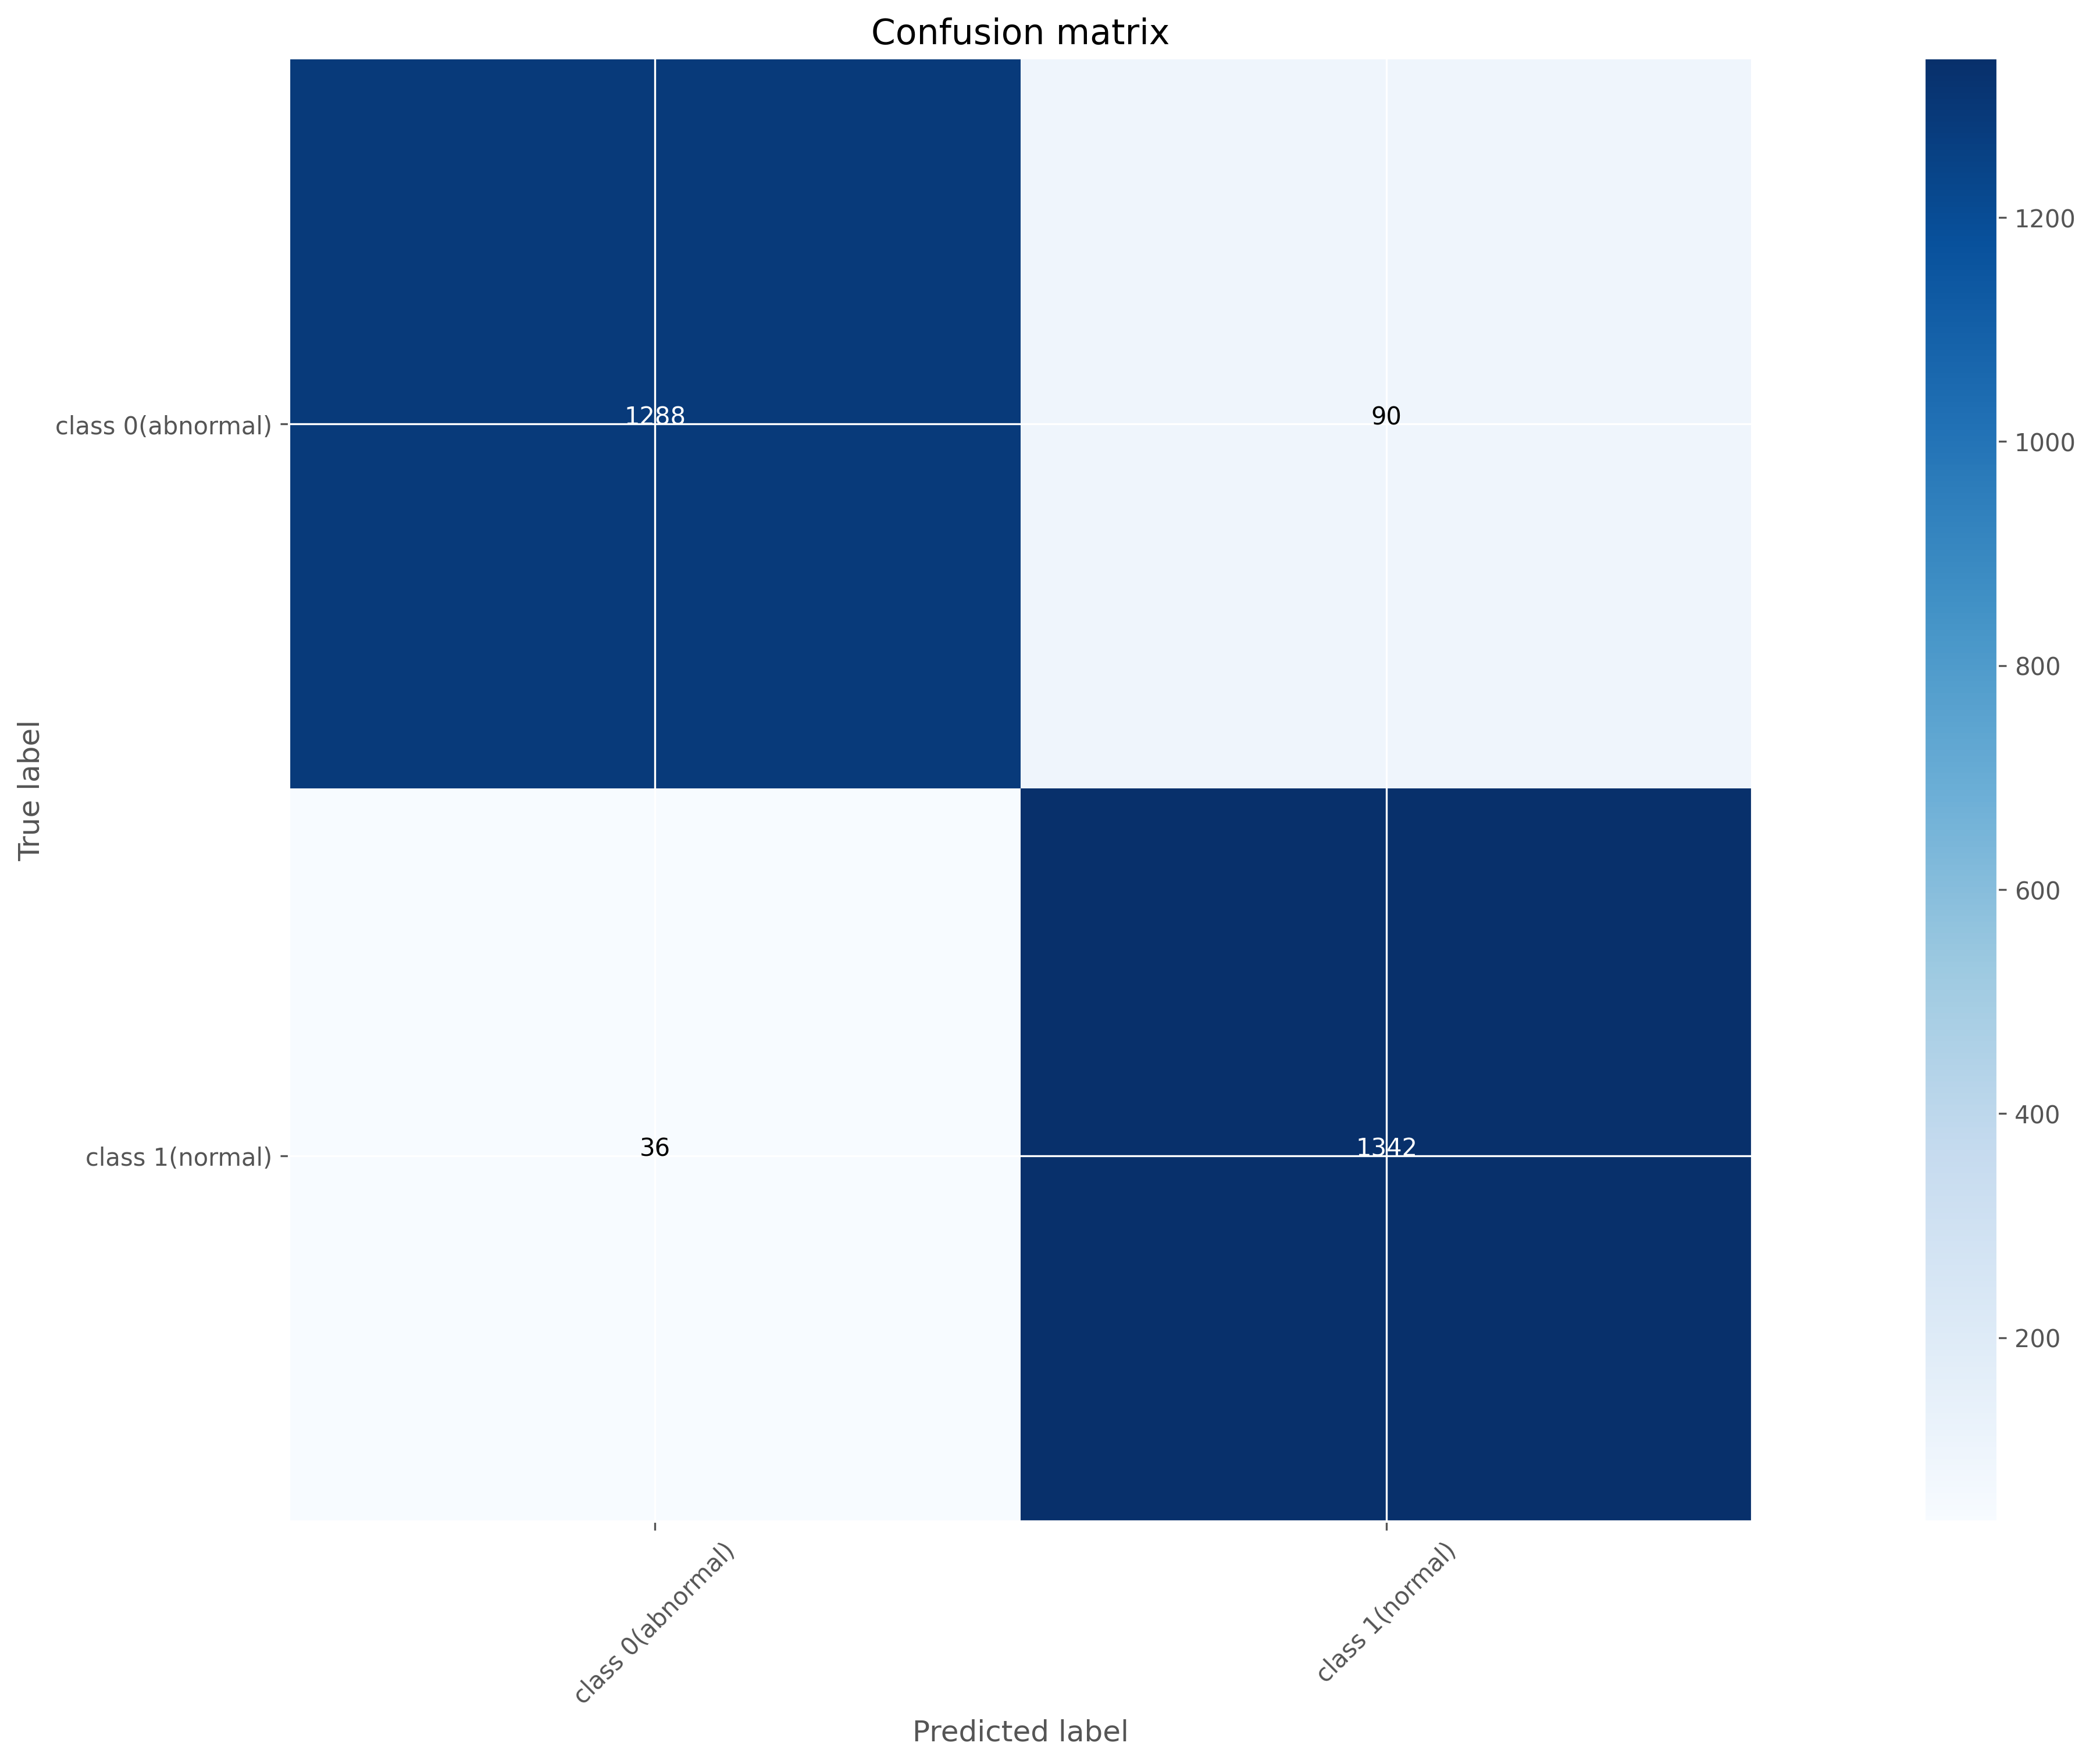

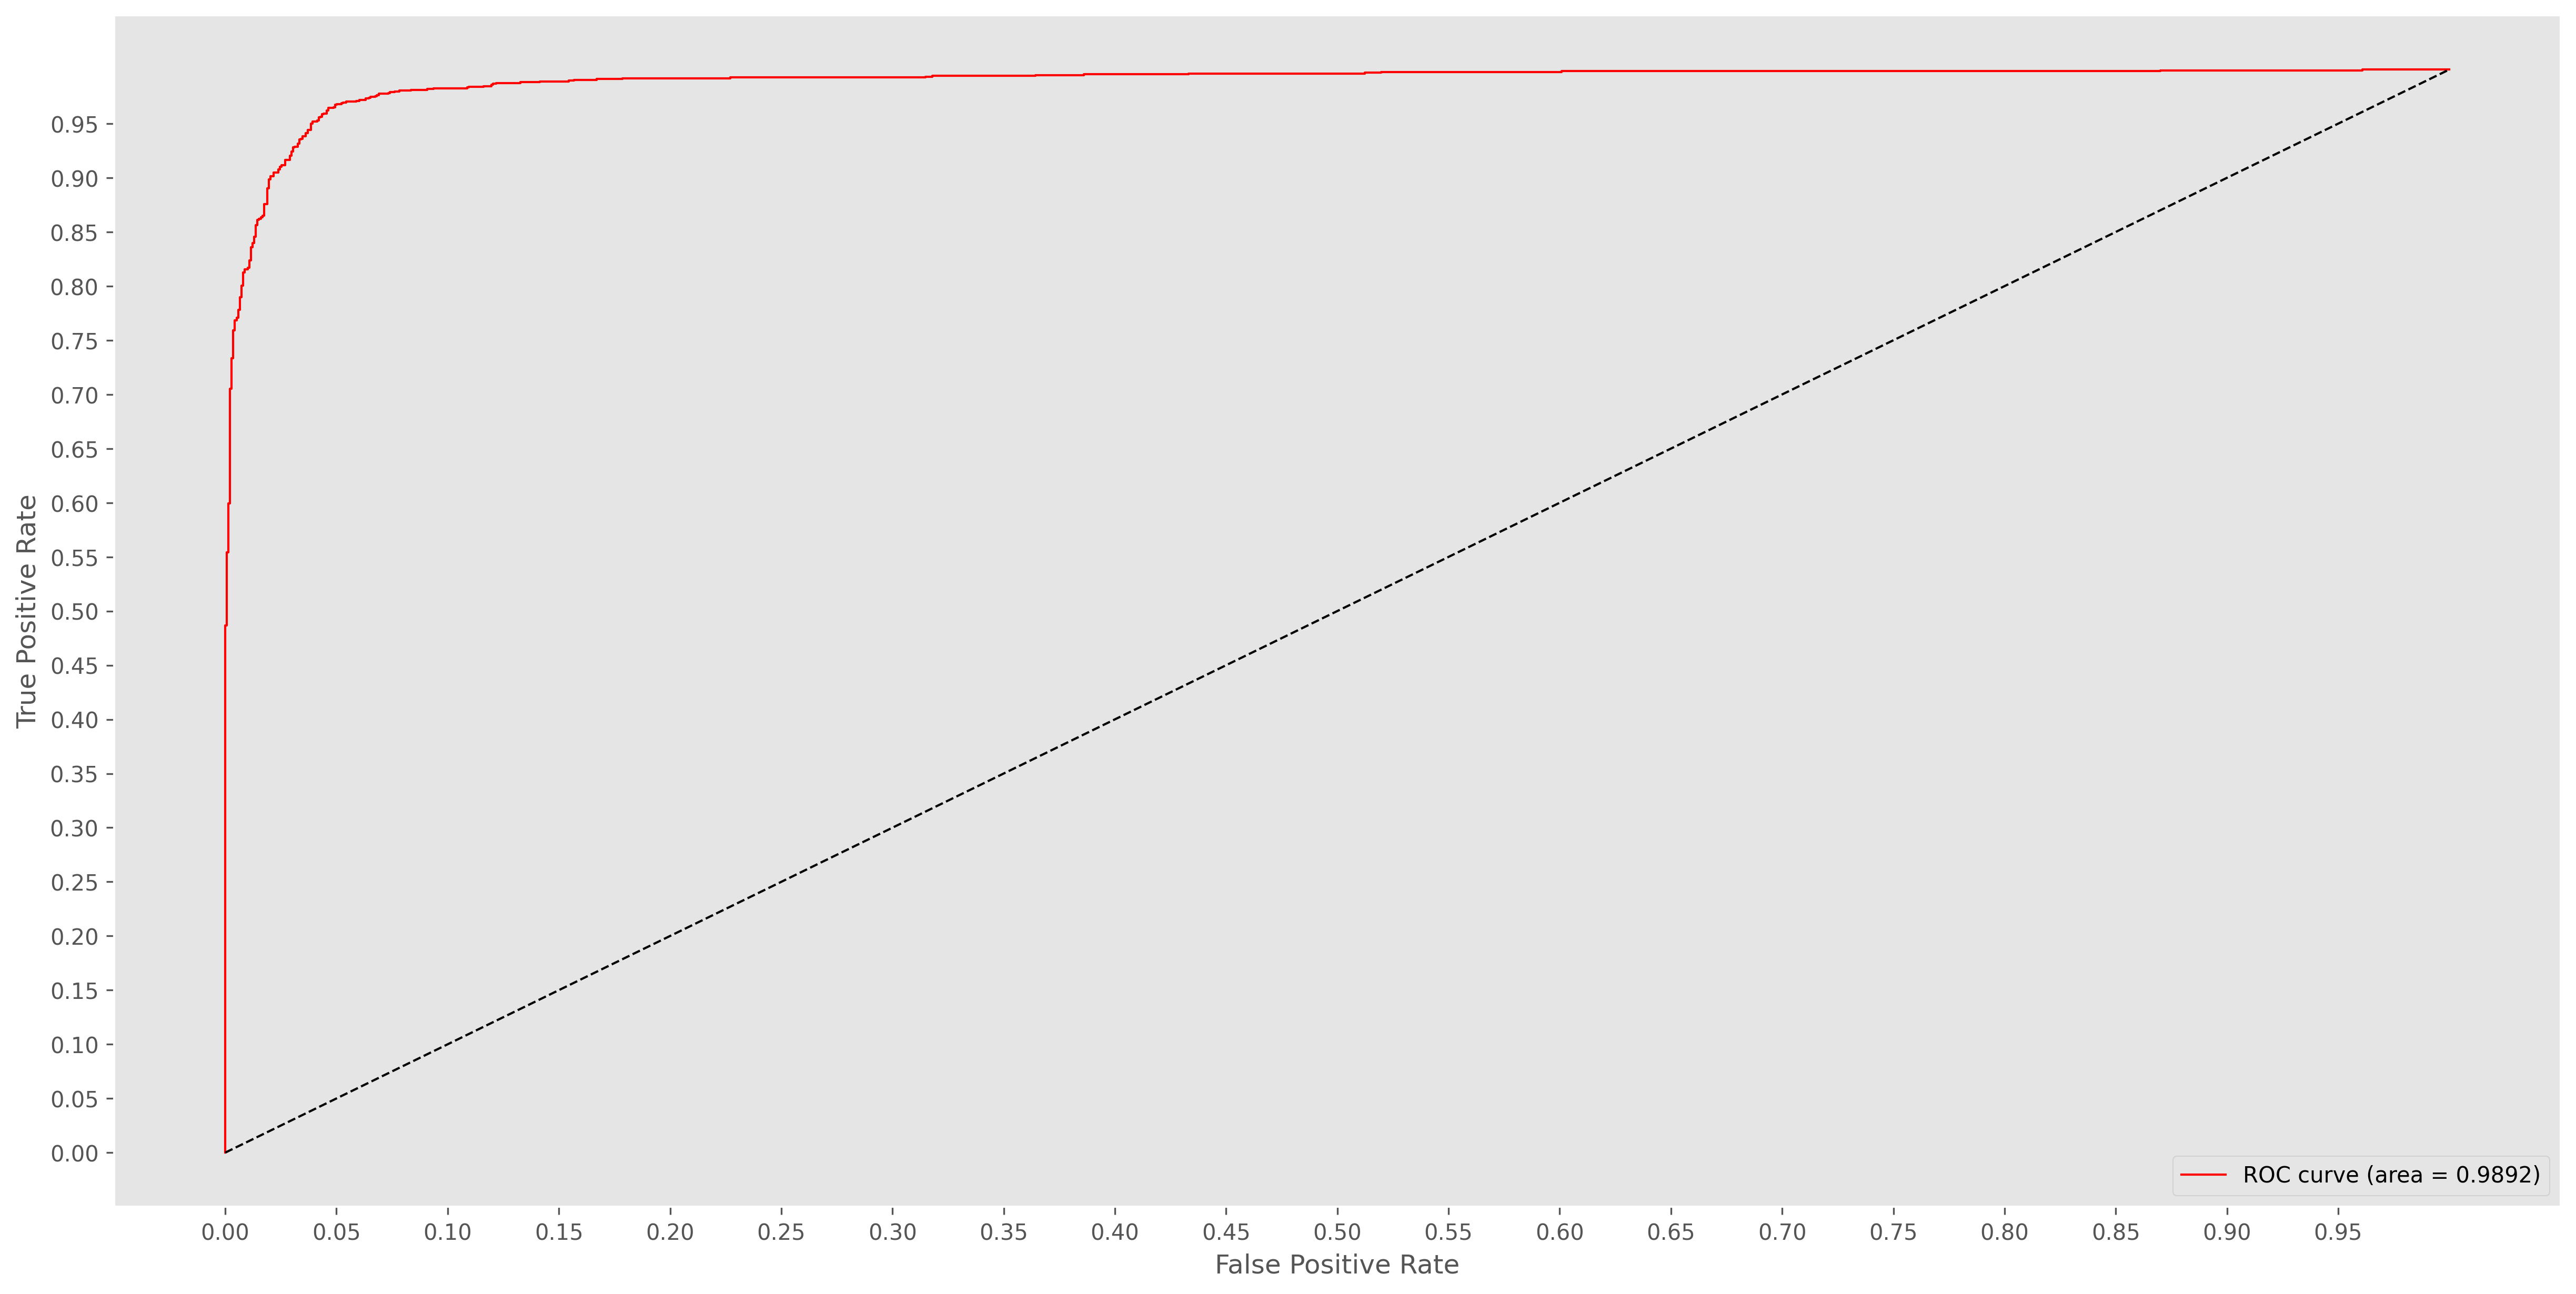

In [144]:
 #%% Pair G

pair_G_ensemble_model = ensemble(pair_G, model_input)
pair_G_ensemble_model.save('weights/ensemblemodel_pairG.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
G_ensem_y_pred = pair_G_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
G_ensemble_model_accuracy = accuracy_score(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair G_ Ensemble model is: ', G_ensemble_model_accuracy)

#evaluate mean squared error
G_ensemble_model_custom_mse = mean_squared_error(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_mse)

#evaluate mean squared log error
G_ensemble_model_custom_msle = mean_squared_log_error(Y_test,G_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,G_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, G_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved
The accuracy of the Pair H_ Ensemble model is:  0.9586357039187228
The Mean Squared Error of the Pair H_ Ensemble model is:  0.041364296081277216
The Mean Squared Log Error of the Pair H_ Ensemble model is:  0.019873600720854482
                   precision    recall  f1-score   support

class 0(abnormal)     0.9535    0.9666    0.9600      1378
  class 1(normal)     0.9662    0.9528    0.9594      1378

         accuracy                         0.9597      2756
        macro avg     0.9598    0.9597    0.9597      2756
     weighted avg     0.9598    0.9597    0.9597      2756

Confusion matrix, without normalization
[[1300   78]
 [  36 1342]]


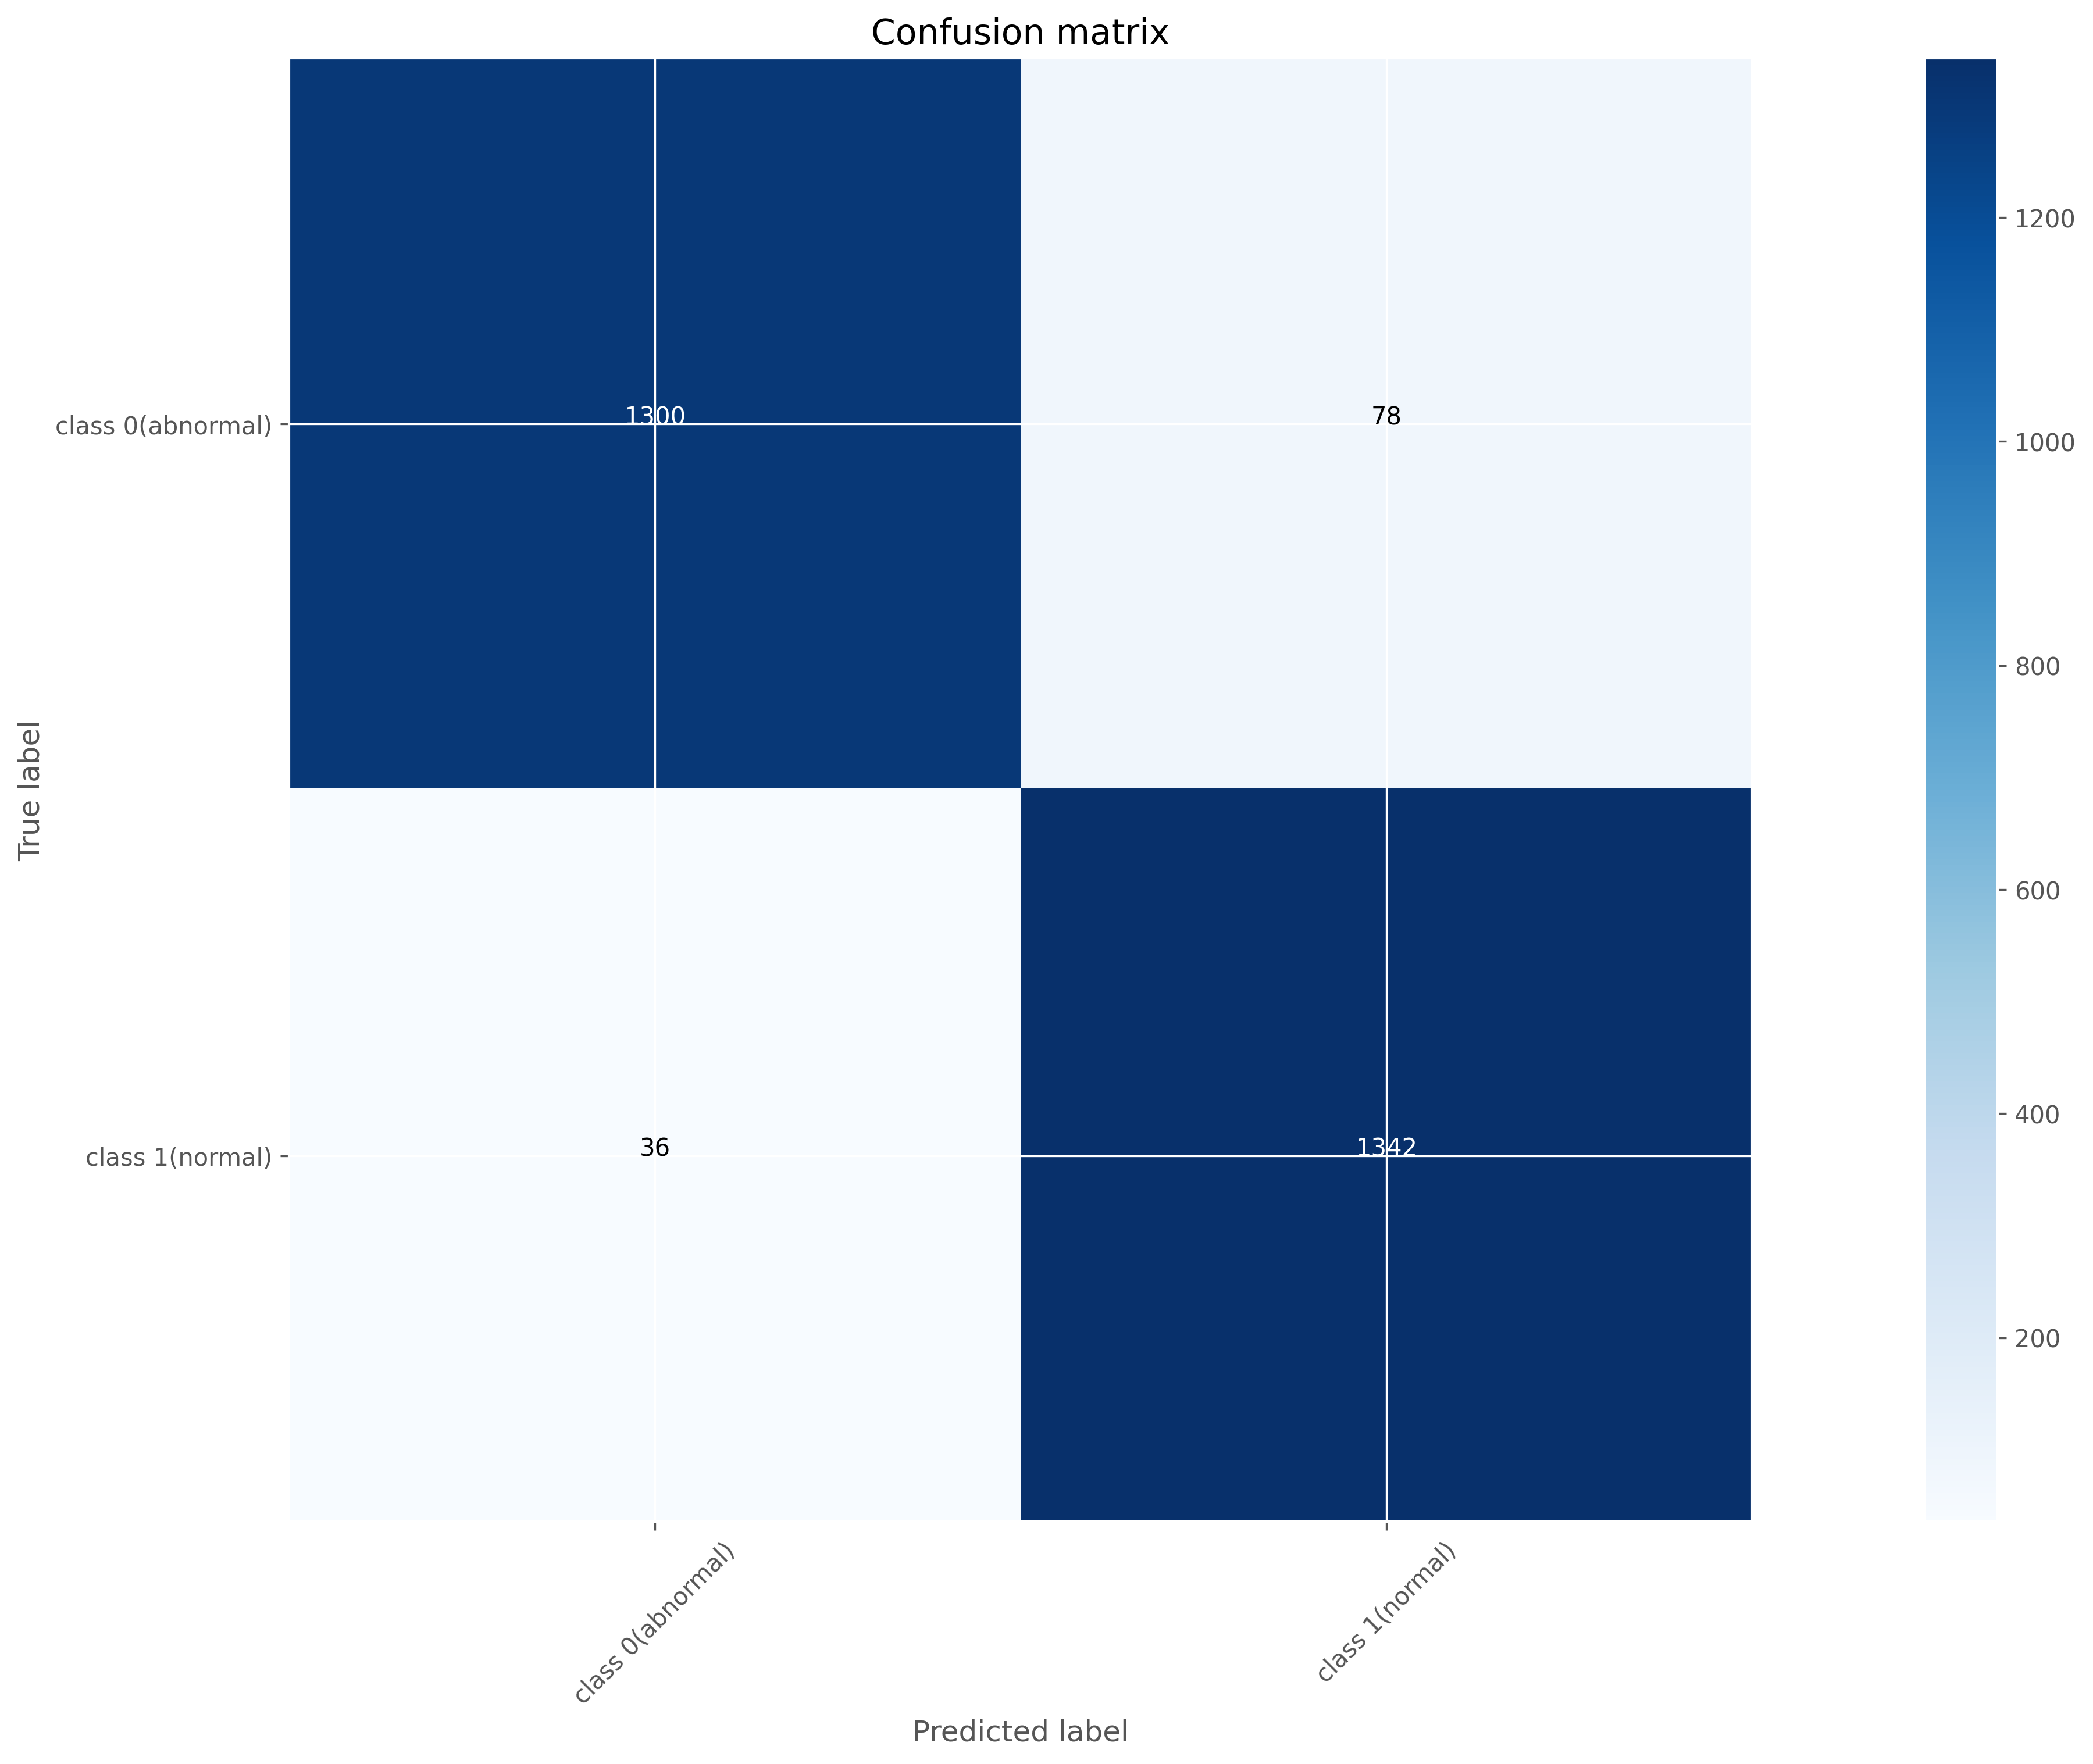

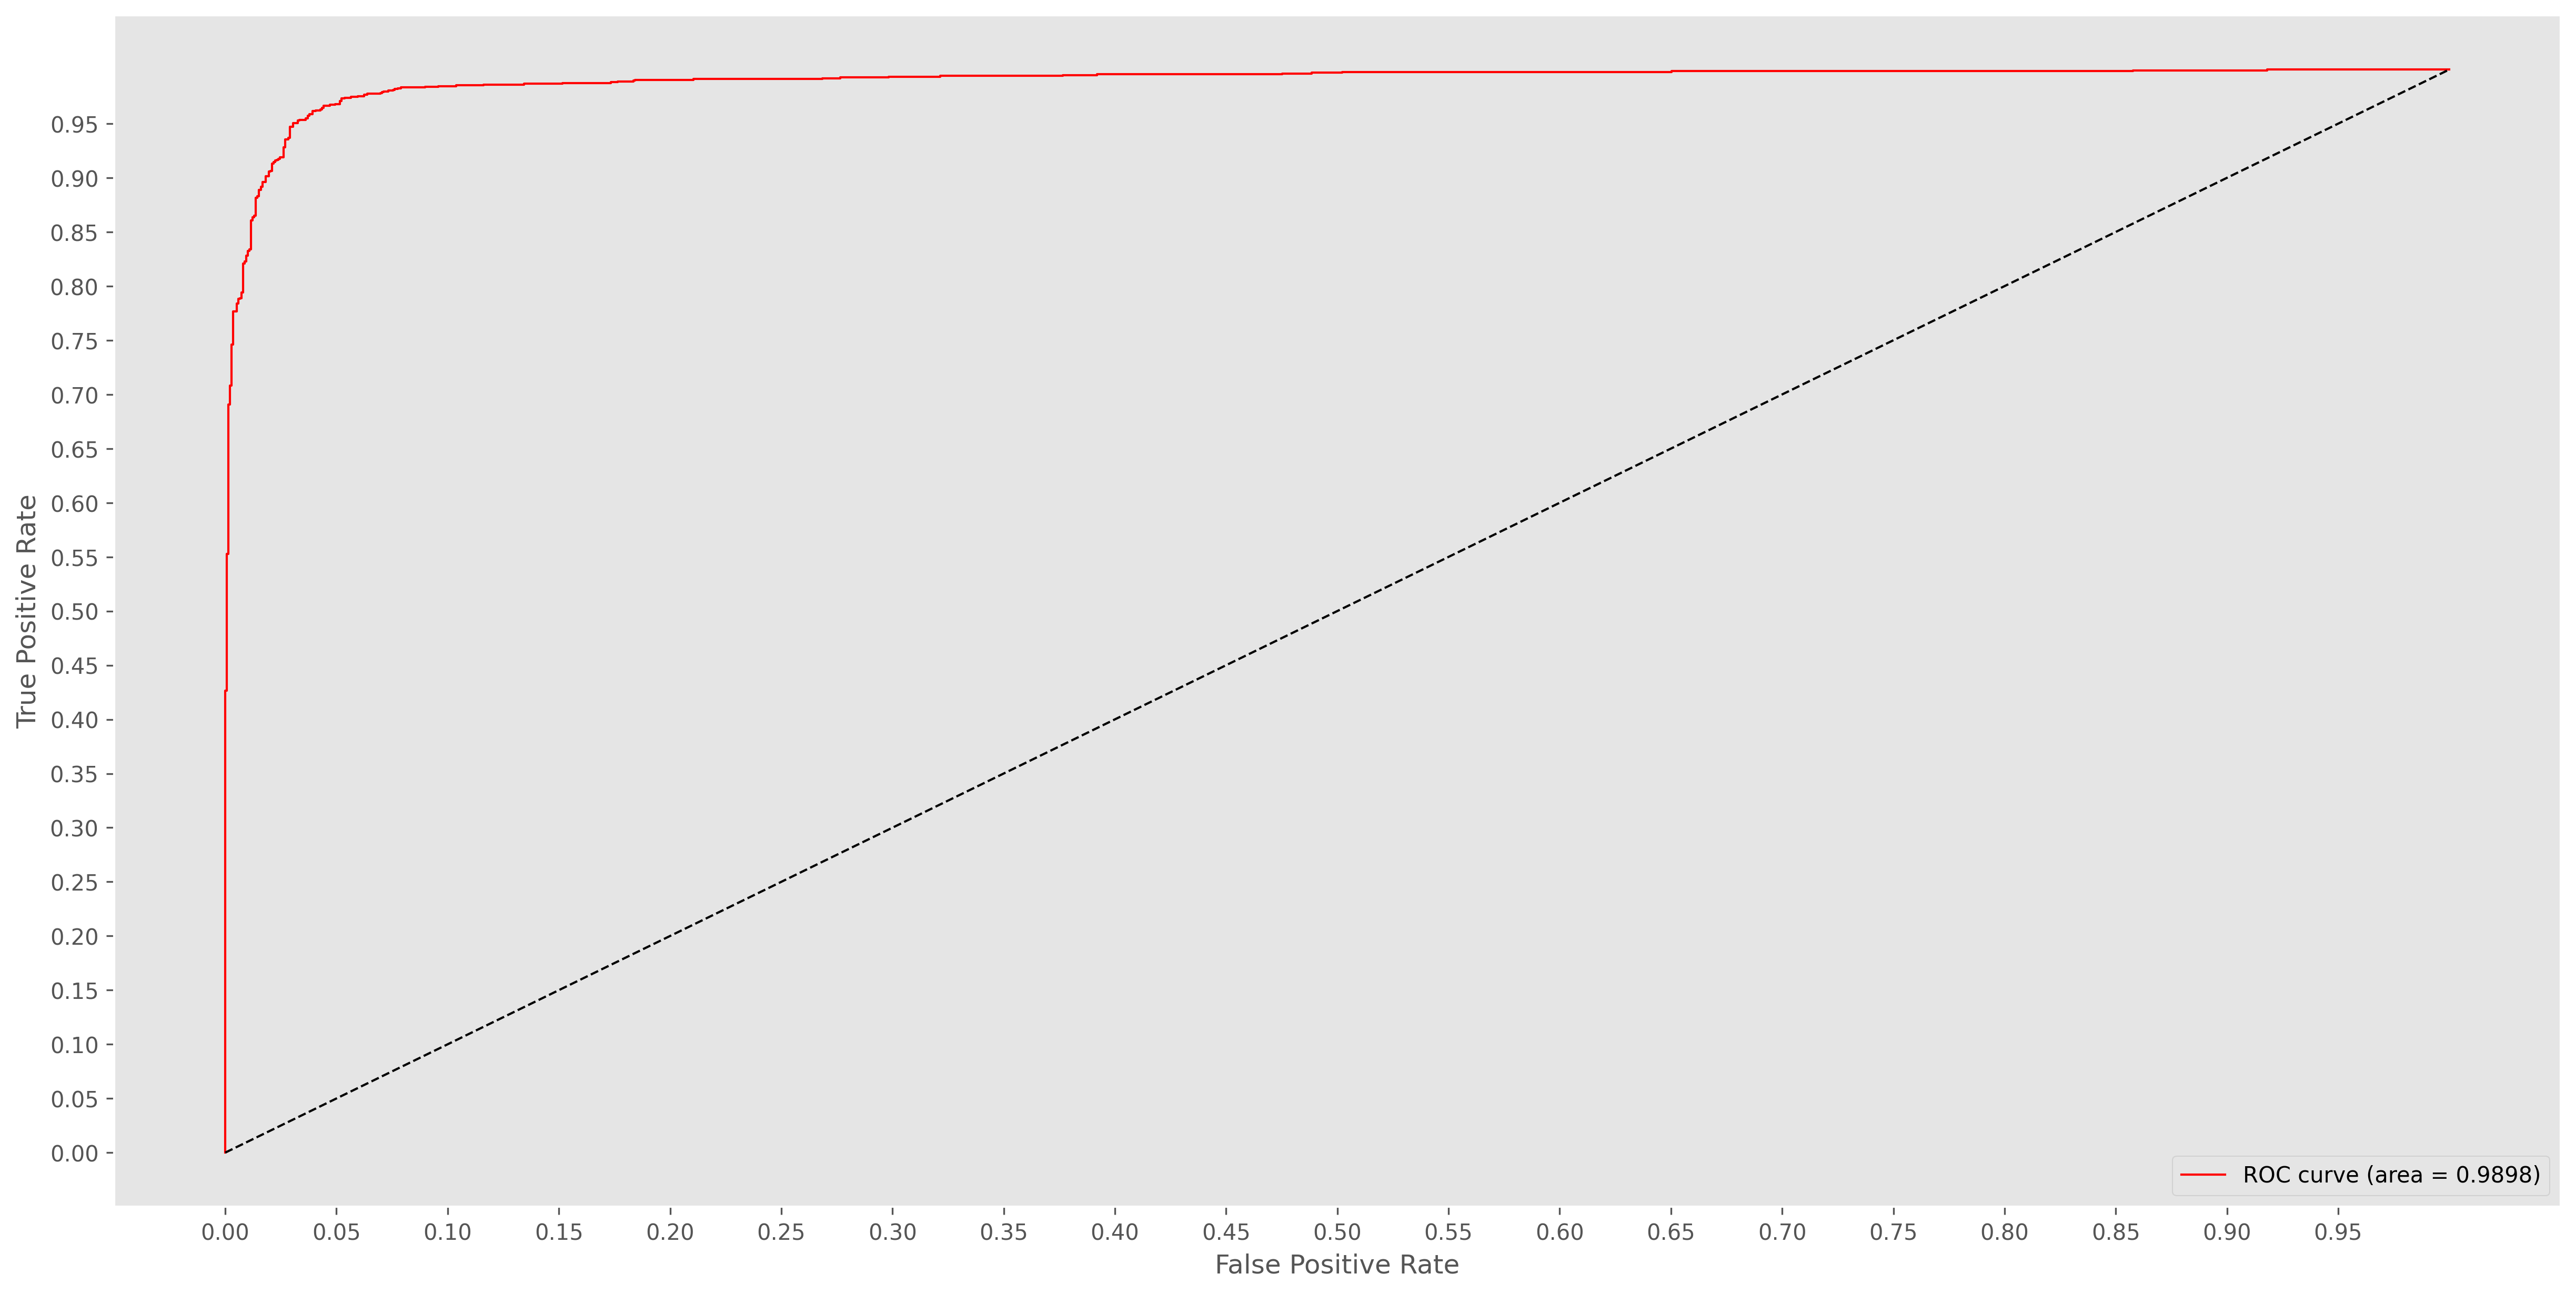

In [145]:
#%% Pair H

pair_H_ensemble_model = ensemble(pair_H, model_input)
pair_H_ensemble_model.save('weights/ensemblemodel_pairH.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
H_ensem_y_pred = pair_H_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
H_ensemble_model_accuracy = accuracy_score(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair H_ Ensemble model is: ', H_ensemble_model_accuracy)

#evaluate mean squared error
H_ensemble_model_custom_mse = mean_squared_error(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_mse)

#evaluate mean squared log error
H_ensemble_model_custom_msle = mean_squared_log_error(Y_test,H_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,H_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, H_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_21')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_22')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]
The Ensemble Model is Saved
The accuracy of the Pair I_ Ensemble model is:  0.9586357039187228
The Mean Squared Error of the Pair I_ Ensemble model is:  0.041364296081277216
The Mean Squared Log Error of the Pair I_ Ensemble model is:  0.019873600720854482
                   precision    recall  f1-score   support

class 0(abnormal)     0.9633    0.9536    0.9584      1378
  class 1(normal)     0.9540    0.9637    0.9588      1378

         accuracy                         0.9586      2756
        macro avg     0.9587    0.9586    0.9586      2756
     weighted avg     0.9587    0.9586    0.9586      2756

Confusion matrix, without normalization
[[1314   64]
 [  50 1328]]


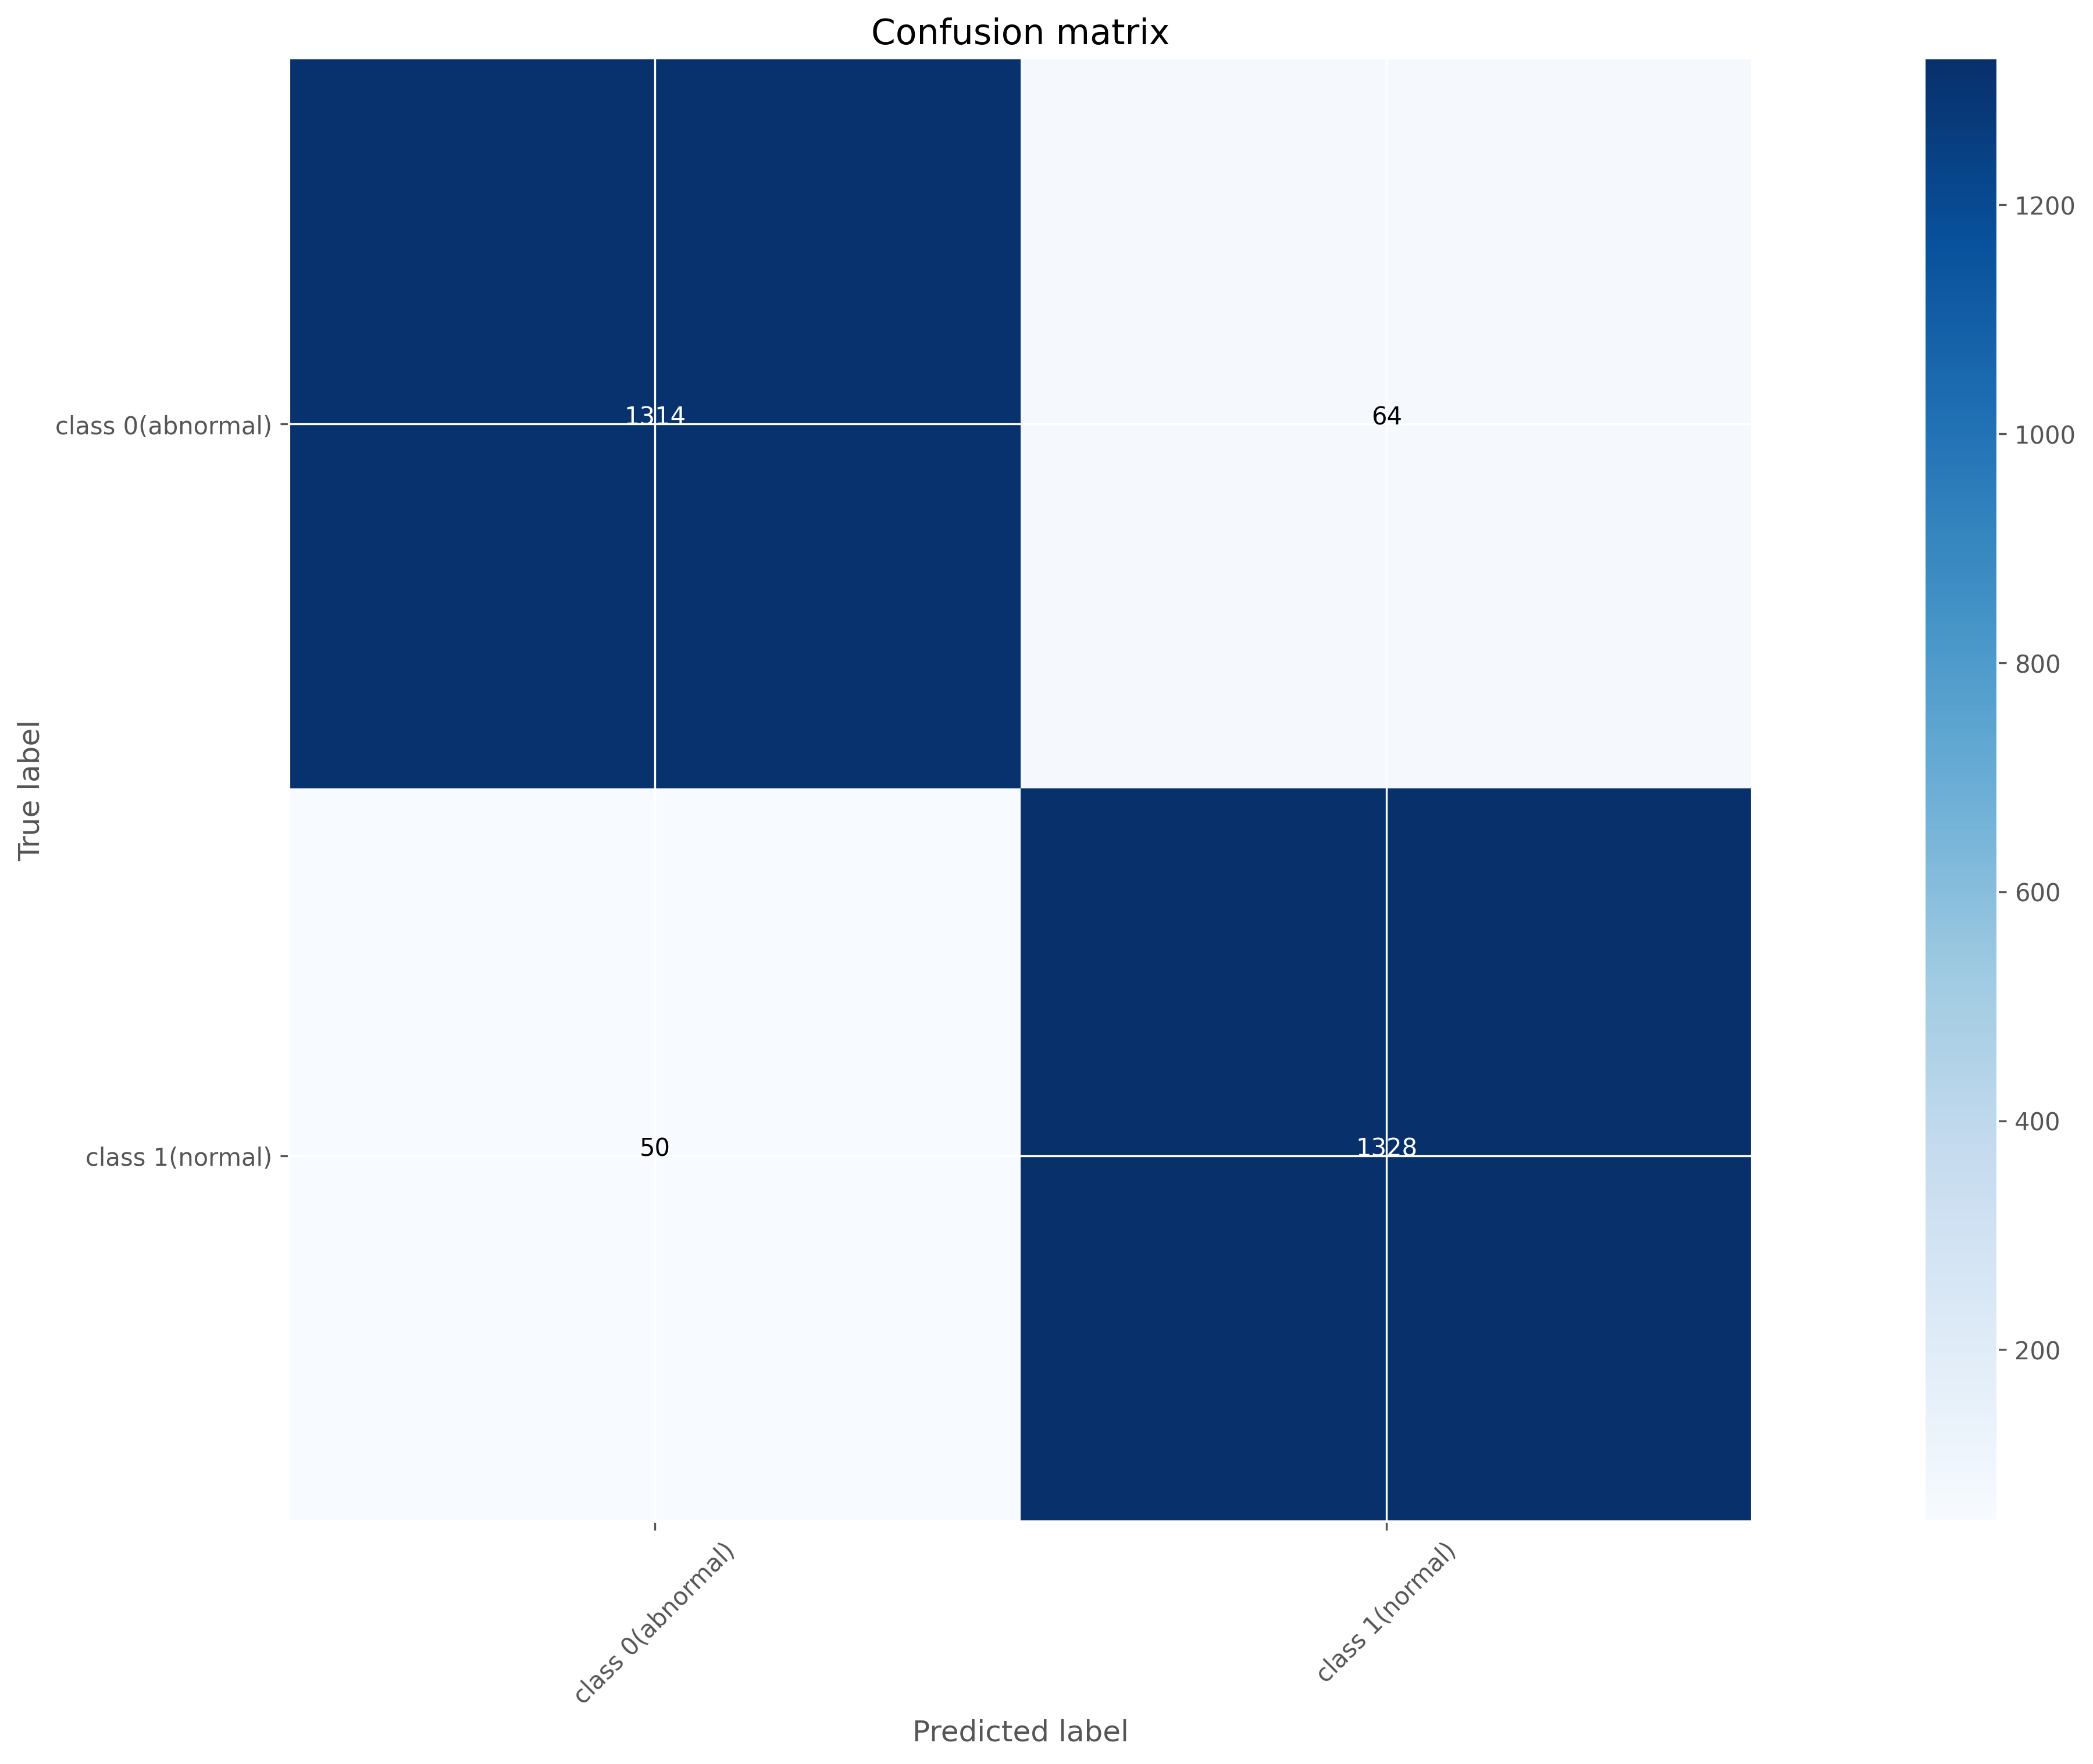

In [ ]:
#%% Pair I

pair_I_ensemble_model = ensemble(pair_I, model_input)
pair_I_ensemble_model.save('weights/ensemblemodel_pairI.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
I_ensem_y_pred = pair_I_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
I_ensemble_model_accuracy = accuracy_score(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair I_ Ensemble model is: ', I_ensemble_model_accuracy)

#evaluate mean squared error
I_ensemble_model_custom_mse = mean_squared_error(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_mse)

#evaluate mean squared log error
I_ensemble_model_custom_msle = mean_squared_log_error(Y_test,I_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,I_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,I_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, I_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()